<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Stocks/Germany/adidas/adidas_1D_High.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "ADS.DE"
data_resample = '1D'
data_label = 'High'
data_label_name = 'y'
start_date = '1 Jan 2009'
finish_date = '1 Jan 2019'
is_duka = False
is_yahoo = True
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

[*********************100%***********************]  1 of 1 downloaded


Open    High     Low   Close  Adj Close   Volume
Date                                                          
2009-01-02   26.60   28.05   26.50   27.81      23.17   580197
2009-01-05   27.96   28.01   27.49   27.88      23.23   801686
2009-01-06   27.99   29.22   27.80   29.20      24.33  1400155
2009-01-07   29.01   29.12   28.45   28.84      24.03  1097019
2009-01-08   28.57   29.25   28.13   28.48      23.73  1065001
...            ...     ...     ...     ...        ...      ...
2018-12-19  186.95  189.05  186.30  187.05     184.54   697398
2018-12-20  184.00  185.30  182.75  183.75     181.29   820234
2018-12-21  183.00  185.55  179.15  184.75     182.27  2238677
2018-12-27  185.15  185.25  178.15  180.10     177.69   807876
2018-12-28  181.15  183.65  181.10  182.40     179.95   443391

[2539 rows x 6 columns]

Open         High          Low        Close    Adj Close        Volume
count  2539.000000  2539.000000  2539.000000  2539.000000  2539.000000  2.539000e+03
mean     90.178283    91.067464    89.240146    90.166467    83.793045  1.031188e+06
std      54.668609    55.106098    54.208416    54.625001    54.582102  6.376025e+05
min      22.410000    23.330000    22.100000    22.730000    18.940000  0.000000e+00
25%      49.425000    50.060000    48.790000    49.430000    42.735000  6.668925e+05
50%      70.550000    71.330000    70.000000    70.620000    65.290000  8.940170e+05
75%     125.975000   127.825000   124.400000   126.725000   120.275000  1.197236e+06
max     217.600000   218.000000   215.600000   216.000000   213.100000  1.198483e+07

7

In [4]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [5]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open    High     Low   Close  Adj Close   Volume  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear        mama        fama      SAREXT      DEMA_8       EMA_8      KAMA_8  MIDPOINT_8  MIDPRICE_8    SAR_0.08      SMA_8      TEMA_8   TRIMA_8       WMA_8     MA_8_0    MAVP_8_0      T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5      MA_8_1    MAVP_8_1      T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       
2009-03-13   25.33   25.33   24.21   24.39      20.32  1250966   13          4         72             31             0               0               0                 0      3        1    11        4             0          11   23.852849   23.924746   22.760446   24.401229   24.242527   23.806704      23.840      23.935   22.824022   23.90875   24.841531   24.0040   24.298333   23.90875   24.696667   24.365427               25.707011                 23.90875               22.110489               26.606142                 23.90875               21.211358               27.505273                 23.90875               20.312227               28.404403                 23.90875               19.413097   24.242527   24.538706   24.190103               26.040789                24.242527               22.444266               26.939919                24.242527               21.545135               27.839050                24.242527               20.646005               28.738181   
2009-03-16   24.61   24.87   23.96   24.39      20.32  1248691   16          0         75             31             0               0               0                 0      3        1    12        0             1          12   23.884230   23.923563   22.924819   24.424223   24.275299   23.869355      23.840      23.935   23.038100   24.09125   24.759075   24.3165   24.405278   24.09125   24.390000   24.312304               25.745742                 24.09125               22.436758               26.572988                 24.09125               21.609512               27.400234                 24.09125               20.782266               28.227480                 24.09125               19.955020   24.275299   24.440349   24.165699               25.929791                24.275299               22.620807               26.757037                24.275299               21.793561               27.584283                24.275299               20.966315               28.411529   
2009-03-17   24.20   24.20   23.46   23.84      19.86   957592

Open         High          Low        Close    Adj Close        Volume          day    dayofweek    dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2.489000e+03  2489.000000  2489.000000  2489.000000    2489.000000   2489.000000     2489.000000     2489.000000       2489.000000  2489.000000  2489.000000  2489.000000  2489.000000   2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000             2489.000000              2489.000000             2489.000000             2489.000000              2489.000000             2489.000000             2489.000000              2489.000000             2489.000000             2489.000000              2489.000000             2489.000000  2489.000000  2489.000000  2489.000000             2489.000000              2489.000000             2489.000000             2489.000000              2489.000000             2489.000000             2489.000000   
mean     91.462692    92.357935    90.517119    91.451149    85.037561  1.022620e+06    15.762555     2.002812   185.324628      30.459221      0.031338        0.028124        0.008437          0.008035     6.595822     2.531137    26.959020     2.002812      2.012455    26.959020    91.189100    90.613033     7.113069    91.457460    91.223871    91.015347    91.199413    91.102252    90.593620    91.227318    91.453223    91.227969    91.302627    91.227318    91.397936    90.752456               94.126449                91.227318               88.328187               95.576014                91.227318               86.878621               97.025580                91.227318               85.429056               98.475145                91.227318               83.979490    91.223871    91.400468    90.824505               94.123002                91.223871               88.324740               95.572567                91.223871               86.875175               97.022133   
std      54.450359    54.891194    53.987938    54.405347    54.409060  6.340082e+05     8.711079     1.408087   103.325294       0.787286      0.174264        0.165360        0.091484          0.089297     3.387334     1.104259    14.776277     1.408087      1.413448    14.776277    54.290199    54.003954   105.514374    54.427892    54.298922    54.319522    54.287590    54.262787    54.130838    54.320422    54.414004    54.328034    54.343457    54.320422    54.387178    54.108793               55.884253                54.320422               52.825248               56.690148                54.320422               52.105265               57.511139                54.320422               51.404721               58.346588                54.320422               50.724424    54.298922    54.379634    54.143211               55.867449                54.298922               52.798807               56.675602                54.298922               52.076262               57.498790   
min      23.500000    24.200000    23.

36

In [6]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [7]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close  Adj Close   Volume  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
2009-03-13  0.009428  0.005831  0.004991  0.003122   0.002587  1250966   13          4         72             31             0               0               0                 0      3        1    11        4             0          11  0.000000  0.000022  0.559554  0.001788  0.000791  0.000000    0.000000    0.000000  0.000000  0.000000  0.004966  0.000000  0.000691  0.000000  0.003658  0.000951                0.003439                 0.000000                0.000000                0.005943                 0.000000                0.000332                0.008219                 0.000000                0.005234                0.010306                 0.000000                0.010106  0.000791  0.002964  0.000317                0.005883                 0.000791                0.000000                0.008148                 0.000791                0.003997                0.010220                 0.000791                0.009348                0.012126                 0.000791   
2009-03-16  0.005719  0.003457  0.003691  0.003122   0.002587  1248691   16          0         75             31             0               0               0                 0      3        1    12        0             1          12  0.000165  0.000016  0.559936  0.001908  0.000964  0.000331    0.000000    0.000000  0.001097  0.000956  0.004537  0.001637  0.001251  0.000956  0.002055  0.000666                0.003638                 0.000956                0.001716                0.005779                 0.000956                0.002429                0.007720                 0.000956                0.007702                0.009499                 0.000956                0.012943  0.000964  0.002451  0.000187                0.005313                 0.000964                0.000933                0.007251                 0.000964                0.005308                0.009023                 0.000964                0.011031                0.010652                 0.000964   
2009-03-17  0.003606  0.000000  0.001092  0.000260  

140070

In [8]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.4" 2019-07-16; OpenJDK Runtime Environment (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3); OpenJDK 64-Bit Server VM (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpdkshxdt6
  JVM stdout: /tmp/tmpdkshxdt6/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpdkshxdt6/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         02 secs
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    2 months and 8 days
H2O cluster name:           H2O_from_python_unknownUser_rt0it8
H2O cluster total nodes:    1
H2O cluster free memory:    9 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper right')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id  auc    logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190827_210353_mod...  0.5  16.783903                   0.5  0.697097  0.485944
1  DeepLearning_grid_1_AutoML_20190827_210353_mod...  0.5  16.783903                   0.5  0.697097  0.485944
2  DeepLearning_grid_1_AutoML_20190827_210353_mod...  0.5   0.694188                   0.5  0.500517  0.250517
3  DeepLearning_grid_1_AutoML_20190827_210353_mod...  0.5  16.783903                   0.5  0.697097  0.485944
4              DeepLearning_1_AutoML_20190827_210353  0.5  16.783903                   0.5  0.697097  0.485944
5  DeepLearning_grid_1_AutoML_20190827_210353_mod...  0.5   0.694477                   0.5  0.500661  0.250661
6  DeepLearning_grid_1_AutoML_20190827_210353_mod...  0.5  16.783903                   0.5  0.697097  0.485944
7  DeepLearning_grid_1_AutoML_20190827_210353_mod...  0.5  16.783903                   0.5  0.697097  0.485944
8  DeepLearning_grid_1_AutoML_20190827_210353_mod...  0.5  16.783903                   0.5  0.697097  0.485944
9  DeepLearning_grid_1_AutoML_20190827_210353_mod...  0.5  16.783903                   0.5  0.697097  0.485944

variable  relative_importance  scaled_importance  percentage
0                         BOP             1.000000           1.000000    0.001650
1              STOCHRSI_fastk             0.734772           0.734772    0.001212
2          CDLCLOSINGMARUBOZU             0.723978           0.723978    0.001194
3                 CDLLONGLINE             0.711947           0.711947    0.001175
4                 CDLBELTHOLD             0.698639           0.698639    0.001153
...                       ...                  ...                ...         ...
1034              MIDPRICE_20             0.539579           0.539579    0.000890
1035  BBANDS_upperband_24_5_2             0.539346           0.539346    0.000890
1036  BBANDS_lowerband_20_2_4             0.539039           0.539039    0.000889
1037  BBANDS_upperband_20_3_4             0.531936           0.531936    0.000878
1038              MIDPOINT_20             0.531418           0.531418    0.000877

[1039 rows x 4 columns]

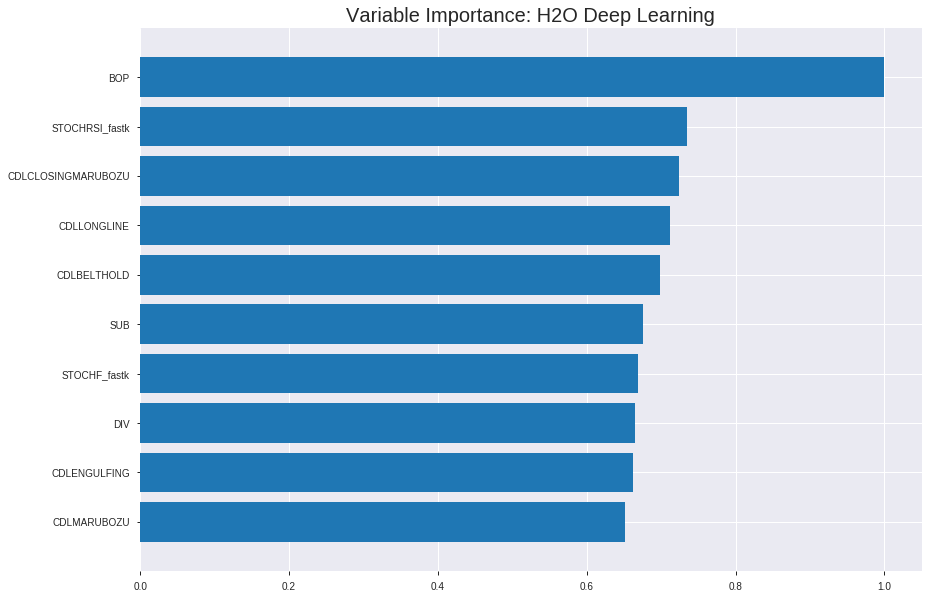

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190827_210353_model_7


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.22642430812285153
RMSE: 0.47584063311454555
LogLoss: 0.6410521092152048
Mean Per-Class Error: 0.34159664420663227
AUC: 0.7255872638393447
pr_auc: 0.7265163125598639
Gini: 0.4511745276786894
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4635589234439921: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      177  664   0.7895   (664.0/841.0)
1      32   868   0.0356   (32.0/900.0)
Total  209  1532  0.3998   (696.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.463559     0.713816  295
max f2                       0.314166     0.8552    338
max f0point5                 0.713358     0.6784    142
max accuracy                 0.713358     0.653073  142
max precision                0.996825     0.983051  4
max recall                   0.062458     1         376
max specificity              0.99971      0.998811  0
max absolute_mcc             0.776429     0.348582  100
max min_per_class_accuracy   0.644782     0.605556  185
max mean_per_class_accuracy  0.713358     0.658403  142

Gains/Lift Table: Avg response rate: 51.69 %, avg score: 64.97 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.999604           1.93444   1.93444            1                0.999827  1                           0.999827            0.02            0.02                       93.4444   93.4444
    2        0.0201034                   0.998676           1.82065   1.87917            0.941176         0.999235  0.971429                    0.999539            0.0177778       0.0377778                  82.0654   87.9175
    3        0.0304423                   0.997034           1.93444   1.89795            1                0.997945  0.981132                    0.998998            0.02            0.0577778                  93.4444   89.7945
    4        0.0402068                   0.992518           1.70686   1.85154            0.882353         0.994787  0.957143                    0.997975            0.0166667       0.0744444                  70.6863   85.154
    5        0.0505457                   0.985449           1.71951   1.82453            0.888889         0.989126  0.943182                    0.996165            0.0177778       0.0922222                  71.9506   82.4533
    6        0.100517                    0.897254           1.66762   1.74653            0.862069         0.942704  0.902857                    0.969587            0.0833333       0.175556                   66.7625   74.6527
    7        0.150488                    0.835023           1.64539   1.71294            0.850575         0.85784   0.885496                    0.93248             0.0822222       0.257778                   64.539    71.2943
    8        0.20046                     0.79606            1.44527   1.64622            0.747126         0.814348  0.851003                    0.903032            0.0722222       0.33                       44.5275   64.6218
    9        0.300402                    0.741816           1.16734   1.4869             0.603448         0.76825   0.768642                    0.858191            0.116667        0.446667                   16.7337   48.6896
    10       0.400345                    0.676601           1.02281   1.37104            0.528736         0.711222  0.708752                    0.821501            0.102222        0.548889                   2.28097   37.1041
    11       0.611143                    0.643381           0.954045  1.22721            0.493188         0.648082  0.634398                    0.761685            0.201111        0.75                       -4.59552  22.7209
    12       0.700172                    0.615437           0.761297  1.16797            0.393548         0.631431  0.603774                    0.745122            0.0677778       0.817778                   -23.8703  16.7966
    13       0.800115                    0.554413           0.84493   1.12762            0.436782         0.588949  0.582915                    0.725615            0.0844444       0.902222                   -15.507   12.7616
    14       0.900057                    0.428495           0.733755  1.08388            0.37931          0.500162  0.560306                    0.700581            0.0733333       0.975556                   -26.6245  8.38814
    15       1                           0.000430514        0.244585  1                  0.126437         0.191902  0.516944                    0.649742            0.0244444       1                          -75.5415  0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.45982740837203334
RMSE: 0.6781057501393373
LogLoss: 15.402876825727843
Mean Per-Class Error: 0.49756935442053407
AUC: 0.49553571428571425
pr_auc: 0.030060616981578605
Gini: -0.008928571428571508
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.6433814476258587: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    230  0.9914   (230.0/232.0)
1      1    265  0.0038   (1.0/266.0)
Total  3    495  0.4639   (231.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.643381     0.696452   11
max f2                       0.605574     0.851472   14
max f0point5                 0.643381     0.589938   11
max accuracy                 0.643381     0.536145   11
max precision                0.643381     0.535354   11
max recall                   0.605574     1          14
max specificity              1            0.0474138  0
max absolute_mcc             0.999669     0.0440574  4
max min_per_class_accuracy   1            0.0474138  0
max mean_per_class_accuracy  0.643381     0.502431   11

Gains/Lift Table: Avg response rate: 53.41 %, avg score: 98.80 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score    cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.943775                    1                  0.995841  0.995841           0.531915         1        0.531915                    1                   0.93985         0.93985                    -0.415933  -0.415933
    2        1                           0.605574           1.06982   1                  0.571429         0.78574  0.534137                    0.987953            0.0601504       1                          6.98174    0


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 21:14:04  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-27 21:14:08  6.829 sec         115 obs/sec       0.265365  1             462        0.676633         3.54549             -0.833436      0.609666        0.473197           1.28963          0.43251                          0.682201           15.7                  -0.870311        0.498112          0.0180422            0.994841           0.465863
    2019-08-27 21:14:36  35.230 sec        161 obs/sec       2.74153   10            4773       0.558182         0.858788            -0.2477        0.651301        0.671623           1.93444          0.396898                         0.681207           15.4597               -0.864864        0.495244          0.0280496            0.995587           0.461847
    2019-08-27 21:15:05  1 min  4.369 sec  189 obs/sec       6.09822   22            10617      0.475841         0.641052            0.0932614      0.725587        0.726516           1.93444          0.39977                          0.678106           15.4029               -0.847923        0.495536          0.0300606            0.995841           0.463855
    2019-08-27 21:15:34  1 min 33.104 sec  198 obs/sec       9.36646   34            16307      0.441972         0.563783            0.217744       0.783717        0.755139           1.93444          0.322229                         0.720772           17.5554               -1.08778         0.504537          0.557324             1.49774            0.465863
    2019-08-27 21:16:01  1 min 59.980 sec  203 obs/sec       12.4302   45            21641      0.420276         0.513959            0.292659       0.815329        0.803577           1.93444          0.271683                         0.721005           17.5717               -1.08913         0.50269           0.549182             1.12331            0.465863
    2019-08-27 21:16:27  2 min 26.474 sec  206 obs/sec       15.4388   56            26879      0.410133         0.491745            0.326389       0.827093        0.786611           1.93444          0.282022                         0.722019           17.6551               -1.09501         0.506838          0.572941             1.49774            0.465863
    2019-08-27 21:16:30  2 min 29.413 sec  206 obs/sec       15.4388   56            26879      0.475841         0.641052            0.0932614      0.725587        0.726516           1.93444          0.39977                          0.678106           15.4029               -0.847923        0.495536          0.0300606            0.995841           0.463855

Variable Importances: 


variable                 relative_importance    scaled_importance    percentage
-----------------------  ---------------------  -------------------  ---------------------
BOP                      1.0                    1.0                  0.0016497752670047857
STOCHRSI_fastk           0.7347716689109802     0.7347716689109802   0.0012122081262651643
CDLCLOSINGMARUBOZU       0.7239781022071838     0.7239781022071838   0.0011944011668744746
CDLLONGLINE              0.7119466662406921     0.7119466662406921   0.0011745520013904049
CDLBELTHOLD              0.6986393928527832     0.6986393928527832   0.0011525979908837618
---                      ---                    ---                  ---
MIDPRICE_20              0.5395792722702026     0.5395792722702026   0.0008901845379798215
BBANDS_upperband_24_5_2  0.5393462777137756     0.5393462777137756   0.0008898001493232814
BBANDS_lowerband_20_2_4  0.5390390157699585     0.5390390157699585   0.0008892932361678802
BBANDS_upperband_20_3_4  0.5319364070892334     0.5319364070892334   0.0008775755280352064
MIDPOINT_20              0.531417727470398      0.531417727470398    0.0008767198232285521


See the whole table with table.as_data_frame()


('accuracy', 0.5140562248995983)

('F1', 0.6790450928381963)

('auc', 0.5)

('logloss', 16.783903388691524)

('mean_per_class_error', 0.5)

('rmse', 0.6970966755769257)

('mse', 0.4859437751004016)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


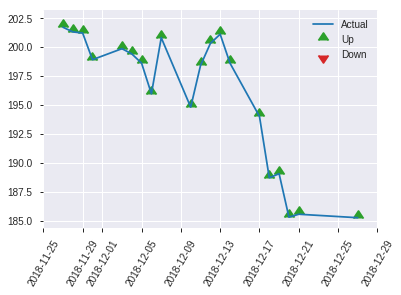


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.4859437751004016
RMSE: 0.6970966755769257
LogLoss: 16.783903388691524
Mean Per-Class Error: 0.5
AUC: 0.5
pr_auc: 0.0
Gini: 0.0
Confusion Matrix (Act/Pred) for max f1 @ threshold = 1.0: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    121  1        (121.0/121.0)
1      0    128  0        (0.0/128.0)
Total  0    249  0.4859   (121.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       1            0.679045  0
max f2                       1            0.840999  0
max f0point5                 1            0.569395  0
max accuracy                 1            0.514056  0
max precision                1            0.514056  0
max recall                   1            1         0
max specificity              1            0         0
max absolute_mcc             1            0         0
max min_per_class_accuracy   1            0         0
max mean_per_class_accuracy  1            0.5       0

Gains/Lift Table: Avg response rate: 51.41 %, avg score: 100.00 %



group    cumulative_data_fraction    lower_threshold    lift    cumulative_lift    response_rate    score    cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain    cumulative_gain
--  -------  --------------------------  -----------------  ------  -----------------  ---------------  -------  --------------------------  ------------------  --------------  -------------------------  ------  -----------------
    1        1                           1                  1       1                  0.514056         1        0.514056                    1                   1               1                          0       0

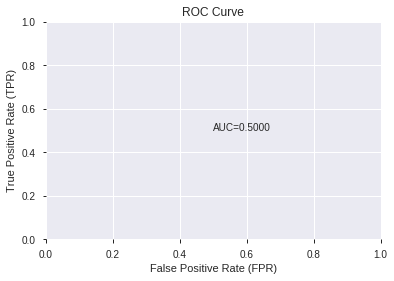

This function is available for GLM models only


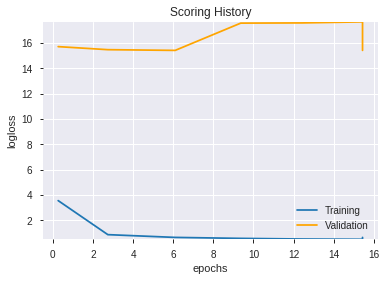

--2019-08-27 21:24:02--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.168.75
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.168.75|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 368257676 (351M) [application/zip]
Saving to: ‘h2o-3.24.0.5.zip’

h2o-3.24.0.5.zip    100%[===================>] 351.20M  16.4MB/s    in 23s     

2019-08-27 21:24:26 (15.5 MB/s) - ‘h2o-3.24.0.5.zip’ saved [368257676/368257676]

Archive:  h2o-3.24.0.5.zip
   creating: h2o-3.24.0.5/
   creating: h2o-3.24.0.5/bindings/
   creating: h2o-3.24.0.5/bindings/java/
 extracting: h2o-3.24.0.5/bindings/java/h2o-bindings-3.24.0.zip  
  inflating: h2o-3.24.0.5/h2o.jar    
   creating: h2o-3.24.0.5/python/
  inflating: h2o-3.24.0.5/python/h2o-3.24.0.5-py2.py3-none-any.whl  
   creating: h2o-3.24.0.5/R/
  inflating: h2o-3.24.0.5/R/h2o_3.24.0.5.tar.gz  
ERROR: Unk

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190827_210353_model_7',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190827_210353_model_7',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_8479',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl

In [10]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190827_212521_model_6  0.705966  0.662046              0.335905  0.485036  0.235260
1  DeepLearning_grid_1_AutoML_20190827_212521_model_9  0.704965  0.634586              0.339585  0.470377  0.221254
2  DeepLearning_grid_1_AutoML_20190827_212521_model_5  0.704933  0.786726              0.383846  0.524377  0.274971
3  DeepLearning_grid_1_AutoML_20190827_212521_model_8  0.703383  0.645415              0.383168  0.474191  0.224857
4  DeepLearning_grid_1_AutoML_20190827_212521_model_7  0.681108  0.783459              0.391206  0.519113  0.269478
5  DeepLearning_grid_1_AutoML_20190827_212521_model_3  0.650245  1.454252              0.389624  0.597982  0.357582
6  DeepLearning_grid_1_AutoML_20190827_212521_model_1  0.645919  1.354528              0.423360  0.570758  0.325765
7  DeepLearning_grid_1_AutoML_20190827_212521_model_4  0.642433  1.256338              0.454545  0.577330  0.333310
8  DeepLearning_grid_1_AutoML_20190827_212521_model_2  0.629132  1.466036              0.419228  0.579742  0.336100
9               DeepLearning_1_AutoML_20190827_212521  0.623515  0.784978              0.428848  0.522185  0.272677

variable  relative_importance  scaled_importance  percentage
0                        BOP             1.000000           1.000000    0.044986
1         CDLCLOSINGMARUBOZU             0.719509           0.719509    0.032368
2               CDLSHORTLINE             0.621897           0.621897    0.027976
3                CDLBELTHOLD             0.614132           0.614132    0.027627
4                        SUB             0.589535           0.589535    0.026521
5                        DIV             0.588295           0.588295    0.026465
6                CDLLONGLINE             0.562115           0.562115    0.025287
7               CDLENGULFING             0.522744           0.522744    0.023516
8                CDLMARUBOZU             0.485136           0.485136    0.021824
9                      ADOSC             0.484715           0.484715    0.021805
10            STOCHRSI_fastk             0.477574           0.477574    0.021484
11                    TRANGE             0.471803           0.471803    0.021224
12              aroondown_24             0.456917           0.456917    0.020555
13             days_in_month             0.450703           0.450703    0.020275
14              STOCHF_fastk             0.445286           0.445286    0.020031
15                 aroonup_8             0.436571           0.436571    0.019639
16               STOCH_slowd             0.432747           0.432747    0.019467
17                   WILLR_8             0.432648           0.432648    0.019463
18                       COS             0.430358           0.430358    0.019360
19                aroonup_30             0.419199           0.419199    0.018858
20                    SAREXT             0.418113           0.418113    0.018809
21              CDLTHRUSTING             0.416276           0.416276    0.018726
22                  WILLR_20             0.415876           0.415876    0.018708
23            CDL3LINESTRIKE             0.411964           0.411964    0.018532
24         LINEARREG_SLOPE_8             0.409750           0.409750    0.018433
25                     month             0.405271           0.405271    0.018231
26                     ROC_8             0.399953           0.399953    0.017992
27    BBANDS_upperband_8_8_3             0.398473           0.398473    0.017926
28  BBANDS_middleband_30_7_3             0.396676           0.396676    0.017845
29                   ROCR_12             0.396409           0.396409    0.017833
30            MACDFIX_hist_8             0.393296           0.393296    0.017693
31   BBANDS_lowerband_30_1_3             0.389436           0.389436    0.017519
32   BBANDS_upperband_24_0_2             0.389113           0.389113    0.017504
33                   TRIMA_8             0.386905           0.386905    0.017405
34             MINMAX_max_30             0.384093           0.384093    0.017279
35    BBANDS_upperband_8_2_3             0.382756           0.382756    0.017219
36                    CMO_20             0.378450           0.378450    0.017025
37                  MAVP_8_0             0.376888           0.376888    0.016955
38   BBANDS_lowerband_30_1_5             0.376156           0.376156    0.016922
39                     MFI_8             0.375526           0.375526    0.016893
40  BBANDS_middleband_14_6_2             0.375268           0.375268    0.016882
41   BBANDS_lowerband_14_2_2             0.374582           0.374582    0.016851
42                 CDLHARAMI             0.374529           0.374529    0.016848
43   BBANDS_lowerband_24_3_3             0.374210           0.374210    0.016834
44    BBANDS_upperband_8_3_3             0.373186           0.373186    0.016788
45   BBANDS_lowerband_20_6_2             0.371322           0.371322    0.016704
46                  SAR_0.14             0.369170           0.369170    0.016607
47            CDLEVENINGSTAR             0.362877           0.362877    0.016324
48               CDLHIGHWAVE             0.361124  

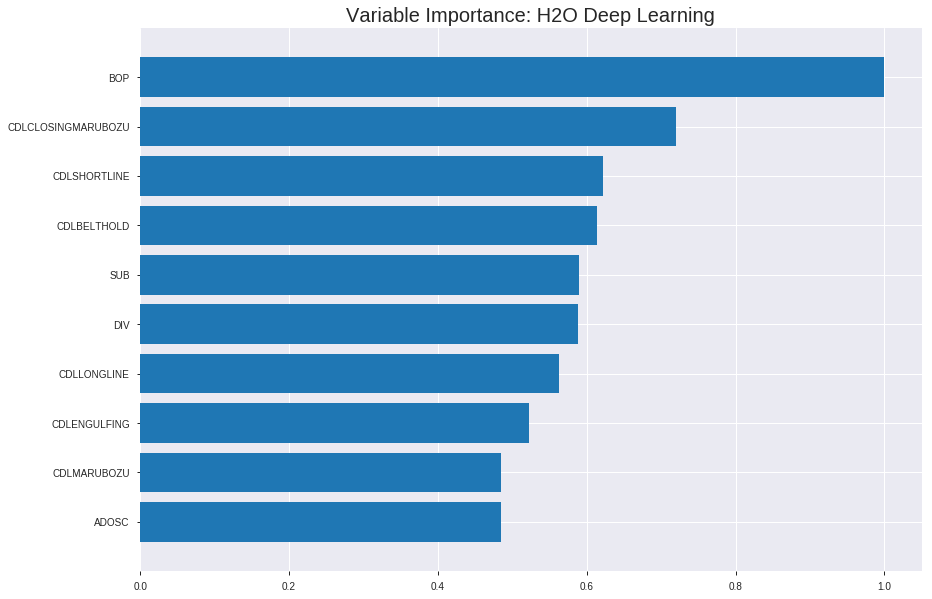

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190827_212521_model_6


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.19147191200371208
RMSE: 0.43757503585523716
LogLoss: 0.5607923797702676
Mean Per-Class Error: 0.29424626767076223
AUC: 0.7771304003170829
pr_auc: 0.77979695800596
Gini: 0.5542608006341658
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3873004672658622: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      412  429   0.5101   (429.0/841.0)
1      111  789   0.1233   (111.0/900.0)
Total  523  1218  0.3102   (540.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.3873       0.745042  262
max f2                       0.144368     0.860039  353
max f0point5                 0.549856     0.720821  183
max accuracy                 0.459431     0.707639  232
max precision                0.988883     1         0
max recall                   0.033324     1         394
max specificity              0.988883     1         0
max absolute_mcc             0.459431     0.41731   232
max min_per_class_accuracy   0.520044     0.695556  199
max mean_per_class_accuracy  0.496752     0.705754  212

Gains/Lift Table: Avg response rate: 51.69 %, avg score: 50.82 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.973594           1.93444   1.93444            1                0.980956   1                           0.980956            0.02            0.02                       93.4444   93.4444
    2        0.0201034                   0.958896           1.93444   1.93444            1                0.965501   1                           0.973449            0.0188889       0.0388889                  93.4444   93.4444
    3        0.0304423                   0.923762           1.82698   1.89795            0.944444         0.944369   0.981132                    0.963573            0.0188889       0.0577778                  82.6975   89.7945
    4        0.0402068                   0.899652           1.70686   1.85154            0.882353         0.908765   0.957143                    0.950262            0.0166667       0.0744444                  70.6863   85.154
    5        0.0505457                   0.885095           1.71951   1.82453            0.888889         0.892082   0.943182                    0.938362            0.0177778       0.0922222                  71.9506   82.4533
    6        0.100517                    0.816143           1.64539   1.73547            0.850575         0.844291   0.897143                    0.891595            0.0822222       0.174444                   64.539    73.5473
    7        0.150488                    0.772818           1.46751   1.64649            0.758621         0.79573    0.851145                    0.859762            0.0733333       0.247778                   46.751    64.6493
    8        0.20046                     0.730055           1.48974   1.60742            0.770115         0.749018   0.830946                    0.832155            0.0744444       0.322222                   48.9745   60.7418
    9        0.300402                    0.648526           1.36745   1.52758            0.706897         0.684933   0.789675                    0.783175            0.136667        0.458889                   36.7452   52.7582
    10       0.400345                    0.581291           1.22292   1.45153            0.632184         0.614249   0.750359                    0.741004            0.122222        0.581111                   22.2925   45.1527
    11       0.500287                    0.521991           1.10063   1.38143            0.568966         0.55       0.714122                    0.702847            0.11            0.691111                   10.0632   38.1429
    12       0.60023                     0.459505           1.05616   1.32727            0.545977         0.491988   0.686124                    0.667738            0.105556        0.796667                   5.61622   32.727
    13       0.700172                    0.385753           0.80046   1.25207            0.413793         0.425465   0.647252                    0.633156            0.08            0.876667                   -19.954   25.2073
    14       0.800115                    0.287902           0.589227  1.16928            0.304598         0.343473   0.604451                    0.596971            0.0588889       0.935556                   -41.0773  16.9277
    15       0.900057                    0.151846           0.511405  1.09623            0.264368         0.215276   0.566688                    0.554588            0.0511111       0.986667                   -48.8595  9.62263
    16       1                           0.00854389         0.13341   1                  0.0689655        0.0907653  0.516944                    0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.21184444301260935
RMSE: 0.4602656222363445
LogLoss: 0.6129941166421184
Mean Per-Class Error: 0.2905593725693545
AUC: 0.7454546927663988
pr_auc: 0.7158104541911219
Gini: 0.4909093855327975
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.31225502783967113: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      97   135  0.5819   (135.0/232.0)
1      22   244  0.0827   (22.0/266.0)
Total  119  379  0.3153   (157.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.312255     0.756589  294
max f2                       0.117578     0.858717  382
max f0point5                 0.430997     0.726619  220
max accuracy                 0.430997     0.712851  220
max precision                0.889692     1         0
max recall                   0.109439     1         388
max specificity              0.889692     1         0
max absolute_mcc             0.430997     0.421398  220
max min_per_class_accuracy   0.453616     0.676724  202
max mean_per_class_accuracy  0.430997     0.709441  220

Gains/Lift Table: Avg response rate: 53.41 %, avg score: 45.96 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100402                   0.868532           1.49774   1.49774            0.8              0.884226  0.8                         0.884226            0.0150376       0.0150376                  49.7744   49.7744
    2        0.0200803                   0.855896           1.49774   1.49774            0.8              0.863541  0.8                         0.873883            0.0150376       0.0300752                  49.7744   49.7744
    3        0.0301205                   0.842579           1.12331   1.37293            0.6              0.852274  0.733333                    0.86668             0.0112782       0.0413534                  12.3308   37.2932
    4        0.0401606                   0.824028           1.49774   1.40414            0.8              0.833547  0.75                        0.858397            0.0150376       0.056391                   49.7744   40.4135
    5        0.0502008                   0.794782           1.12331   1.34797            0.6              0.812329  0.72                        0.849183            0.0112782       0.0676692                  12.3308   34.797
    6        0.100402                    0.719465           1.34797   1.34797            0.72             0.75395   0.72                        0.801567            0.0676692       0.135338                   34.797    34.797
    7        0.150602                    0.681741           1.42286   1.37293            0.76             0.706949  0.733333                    0.770027            0.0714286       0.206767                   42.2857   37.2932
    8        0.200803                    0.635174           1.72241   1.4603             0.92             0.657299  0.78                        0.741845            0.0864662       0.293233                   72.2406   46.0301
    9        0.301205                    0.568875           1.38541   1.43534            0.74             0.598908  0.766667                    0.6942              0.139098        0.432331                   38.5414   43.5338
    10       0.399598                    0.499685           1.26086   1.39238            0.673469         0.536052  0.743719                    0.655259            0.12406         0.556391                   26.0856   39.2375
    11       0.5                         0.45935            1.04842   1.32331            0.56             0.480653  0.706827                    0.620197            0.105263        0.661654                   4.84211   32.3308
    12       0.600402                    0.417769           1.1982    1.30239            0.64             0.436527  0.695652                    0.589483            0.120301        0.781955                   19.8195   30.2386
    13       0.698795                    0.362746           0.764155  1.2266             0.408163         0.387601  0.655172                    0.561057            0.075188        0.857143                   -23.5845  22.6601
    14       0.799197                    0.273867           0.673985  1.15718            0.36             0.321788  0.61809                     0.530998            0.0676692       0.924812                   -32.6015  15.7177
    15       0.899598                    0.176733           0.449323  1.07818            0.24             0.225292  0.575893                    0.496879            0.0451128       0.969925                   -55.0677  7.81753
    16       1                           0.0456856          0.299549  1                  0.16             0.125783  0.534137                    0.459621           


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 21:28:49  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-27 21:28:50  1 min 37.852 sec  961 obs/sec       1         1             1741       0.538964         1.05351             -0.163266      0.686531        0.688661           1.93444          0.400345                         0.727893           3.95424               -1.12924         0.731235          0.700769             0.748872           0.309237
    2019-08-27 21:28:56  1 min 43.455 sec  1778 obs/sec      7         7             12187      0.443036         0.572894            0.213975       0.767481        0.769372           1.93444          0.319357                         0.49528            0.683812              0.0141946        0.767582          0.727555             1.12331            0.279116
    2019-08-27 21:29:02  1 min 49.492 sec  2387 obs/sec      17        17            29597      0.437575         0.560792            0.233232       0.77713         0.779797           1.93444          0.310167                         0.460266           0.612994              0.148654         0.745455          0.71581              1.49774            0.315261
    2019-08-27 21:29:07  1 min 54.837 sec  2725 obs/sec      27        27            47007      0.43366          0.553193            0.246889       0.785315        0.789462           1.93444          0.302125                         0.460984           0.618105              0.145993         0.755987          0.718421             0.748872           0.283133
    2019-08-27 21:29:13  2 min  0.125 sec  2924 obs/sec      37        37            64417      0.430824         0.546483            0.256708       0.791258        0.790831           1.93444          0.302125                         0.460006           0.628172              0.149615         0.72998           0.706561             1.49774            0.327309
    2019-08-27 21:29:18  2 min  5.272 sec  3067 obs/sec      47        47            81827      0.425636         0.534916            0.274503       0.802787        0.799637           1.93444          0.290638                         0.46091            0.640489              0.14627          0.758054          0.724035             1.49774            0.287149
    2019-08-27 21:29:23  2 min 10.309 sec  3179 obs/sec      57        57            99237      0.420726         0.52462             0.291144       0.811375        0.811158           1.93444          0.28834                          0.458084           0.63071               0.156707         0.739597          0.715372             1.49774            0.301205
    2019-08-27 21:29:28  2 min 15.427 sec  3261 obs/sec      67        67            116647     0.414814         0.511534            0.310926       0.821214        0.818516           1.93444          0.274555                         0.458832           0.622096              0.153948         0.743591          0.708771             1.12331            0.305221
    2019-08-27 21:29:29

Variable Importances: 


variable                 relative_importance    scaled_importance    percentage
-----------------------  ---------------------  -------------------  --------------------
BOP                      1.0                    1.0                  0.044985651392224976
CDLCLOSINGMARUBOZU       0.719508707523346      0.719508707523346    0.0323675678903156
CDLSHORTLINE             0.621897280216217      0.621897280216217    0.027976454249579587
CDLBELTHOLD              0.6141318678855896     0.6141318678855896   0.027627122117557096
SUB                      0.5895350575447083     0.5895350575447083   0.026520618582201536
---                      ---                    ---                  ---
BBANDS_lowerband_20_6_2  0.37132203578948975    0.37132203578948975  0.01670416365627727
SAR_0.14                 0.36916977167129517    0.36916977167129517  0.016607342652952176
CDLEVENINGSTAR           0.36287733912467957    0.36287733912467957  0.016324273476001034
CDLHIGHWAVE              0.3611241281032562     0.3611241281032562   0.016245404136174278
MAVP_8_8                 0.34978187084198       0.34978187084198     0.015735165305017573


See the whole table with table.as_data_frame()


('accuracy', 0.6706827309236948)

('F1', 0.7371794871794872)

('auc', 0.7059659090909091)

('logloss', 0.6620464535218683)

('mean_per_class_error', 0.3352272727272727)

('rmse', 0.485036098770132)

('mse', 0.23526001711014924)

deeplearning prediction progress: |███████████████████████████████████████| 100%


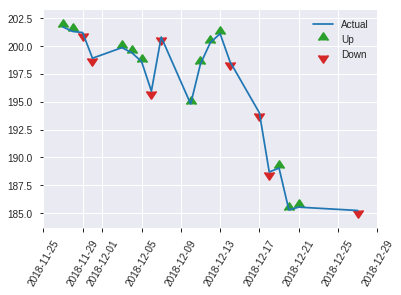


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.23526001711014924
RMSE: 0.485036098770132
LogLoss: 0.6620464535218683
Mean Per-Class Error: 0.3352272727272727
AUC: 0.7059659090909091
pr_auc: 0.6876168247546286
Gini: 0.4119318181818181
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.23823241176108084: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      52   69   0.5702   (69.0/121.0)
1      13   115  0.1016   (13.0/128.0)
Total  65   184  0.3293   (82.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.238232     0.737179  183
max f2                       0.141969     0.852503  226
max f0point5                 0.256875     0.666667  177
max accuracy                 0.256875     0.670683  177
max precision                0.876601     1         0
max recall                   0.0893609    1         242
max specificity              0.876601     1         0
max absolute_mcc             0.238232     0.373471  183
max min_per_class_accuracy   0.367035     0.628099  125
max mean_per_class_accuracy  0.256875     0.664773  177

Gains/Lift Table: Avg response rate: 51.41 %, avg score: 38.50 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.82644            1.94531   1.94531            1                0.857799  1                           0.857799            0.0234375       0.0234375                  94.5313   94.5313
    2        0.0200803                   0.788179           1.94531   1.94531            1                0.805253  1                           0.836781            0.015625        0.0390625                  94.5313   94.5313
    3        0.0321285                   0.761937           1.29688   1.70215            0.666667         0.770965  0.875                       0.8121              0.015625        0.0546875                  29.6875   70.2148
    4        0.0401606                   0.751396           0         1.36172            0                0.758755  0.7                         0.801431            0               0.0546875                  -100      36.1719
    5        0.0522088                   0.704737           1.29688   1.34675            0.666667         0.722764  0.692308                    0.783277            0.015625        0.0703125                  29.6875   34.6755
    6        0.100402                    0.633964           1.62109   1.47844            0.833333         0.674398  0.76                        0.731015            0.078125        0.148438                   62.1094   47.8438
    7        0.15261                     0.58741            1.34675   1.43339            0.692308         0.603424  0.736842                    0.687366            0.0703125       0.21875                    34.6755   43.3388
    8        0.200803                    0.560657           1.62109   1.47844            0.833333         0.574199  0.76                        0.660206            0.078125        0.296875                   62.1094   47.8438
    9        0.301205                    0.479112           1.40063   1.4525             0.72             0.525768  0.746667                    0.615393            0.140625        0.4375                     40.0625   45.25
    10       0.401606                    0.430104           0.778125  1.28391            0.4              0.452445  0.66                        0.574656            0.078125        0.515625                   -22.1875  28.3906
    11       0.502008                    0.367271           1.08938   1.245              0.56             0.398335  0.64                        0.539392            0.109375        0.625                      8.9375    24.5
    12       0.598394                    0.316902           0.972656  1.20113            0.5              0.342716  0.61745                     0.507712            0.09375         0.71875                    -2.73437  20.1133
    13       0.698795                    0.267624           1.245     1.20744            0.64             0.29168   0.62069                     0.476673            0.125           0.84375                    24.5      20.7435
    14       0.799197                    0.206696           0.855938  1.16328            0.44             0.231305  0.59799                     0.445848            0.0859375       0.929688                   -14.4062  16.3277
    15       0.899598                    0.150492           0.389063  1.07687            0.2              0.180719  0.553571                    0.416258            0.0390625       0.96875                    -61.0937  7.68694
    16       1                           0.0291665          0.31125   1                  0.16             0.105067  0.514056                    0.385014            0.

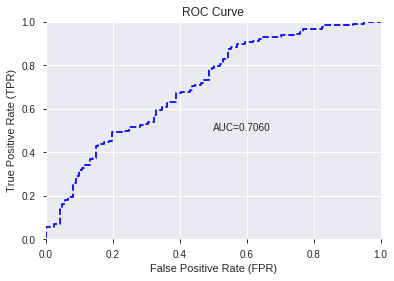

This function is available for GLM models only


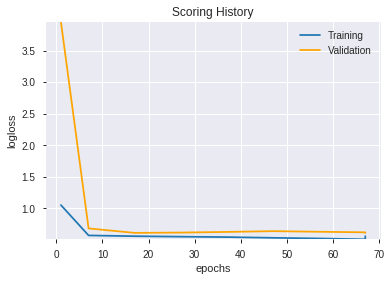

--2019-08-27 21:33:04--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.97.3
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.97.3|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190827_212521_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190827_212521_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_8479',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'CDLCLOSINGMARUBOZU',
 'CDLSHORTLINE',
 'CDLBELTHOLD',
 'SUB',
 'DIV',
 'CDLLONGLINE',
 'CDLENGULFING',
 'CDLMARUBOZU',
 'ADOSC',
 'STOCHRSI_fastk',
 'TRANGE',
 'aroondown_24',
 'days_in_month',
 'STOCHF_fastk',
 'aroonup_8',
 'STOCH_slowd',
 'WILLR_8',
 'COS',
 'aroonup_30',
 'SAREXT',
 'CDLTHRUSTING',
 'WILLR_20',
 'CDL3LINESTRIKE',
 'LINEARREG_SLOPE_8',
 'month',
 'ROC_8',
 'BBANDS_upperband_8_8_3',
 'BBANDS_middleband_30_7_3',
 'ROCR_12',
 'MACDFIX_hist_8',
 'BBANDS_lowerband_30_1_3',
 'BBANDS_upperband_24_0_2',
 'TRIMA_8',
 'MINMAX_max_30',
 'BBANDS_upperband_8_2_3',
 'CMO_20',
 'MAVP_8_0',
 'BBANDS_lowerband_30_1_5',
 'MFI_8',
 'BBANDS_middleband_14_6_2',
 'BBANDS_lowerband_14_2_2',
 'CDLHARAMI',
 'BBANDS_lowerband_24_3_3',
 'BBANDS_upperband_8_3_3',
 'BBANDS_lowerband_20_6_2',
 'SAR_0.14',
 'CDLEVENINGSTAR',
 'CDLHIGHWAVE',
 'MAVP_8_8']

In [11]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse      mse
0  GLM_grid_1_AutoML_20190827_213400_model_1  0.717265  0.723318              0.337939  0.505104  0.25513

variable  relative_importance  scaled_importance  percentage
0                        BOP             0.803023           1.000000    0.154677
1                   SAR_0.14             0.361608           0.450308    0.069653
2                   WILLR_20             0.264394           0.329249    0.050927
3                STOCH_slowd             0.232196           0.289153    0.044725
4                        DIV             0.227345           0.283112    0.043791
5                    ROCR_12             0.207642           0.258576    0.039996
6                        SUB             0.205075           0.255379    0.039501
7                      ADOSC             0.179322           0.223308    0.034541
8         CDLCLOSINGMARUBOZU             0.162546           0.202418    0.031310
9    BBANDS_lowerband_14_2_2             0.144473           0.179911    0.027828
10                 aroonup_8             0.140355           0.174783    0.027035
11              CDLENGULFING             0.134828           0.167901    0.025971
12         LINEARREG_SLOPE_8             0.132359           0.164826    0.025495
13              aroondown_24             0.127320           0.158551    0.024524
14              STOCHF_fastk             0.123304           0.153550    0.023751
15            STOCHRSI_fastk             0.116691           0.145314    0.022477
16    BBANDS_upperband_8_3_3             0.102888           0.128126    0.019818
17                       COS             0.101036           0.125819    0.019461
18                  MAVP_8_0             0.096406           0.120053    0.018570
19   BBANDS_lowerband_24_3_3             0.093947           0.116992    0.018096
20    BBANDS_upperband_8_2_3             0.075126           0.093554    0.014471
21              CDLTHRUSTING             0.074861           0.093223    0.014420
22             MINMAX_max_30             0.073619           0.091677    0.014180
23               CDLMARUBOZU             0.072412           0.090174    0.013948
24                  MAVP_8_8             0.066339           0.082611    0.012778
25                    CMO_20             0.065367           0.081402    0.012591
26    BBANDS_upperband_8_8_3             0.063048           0.078513    0.012144
27                   WILLR_8             0.059596           0.074214    0.011479
28                aroonup_30             0.059175           0.073690    0.011398
29   BBANDS_upperband_24_0_2             0.053869           0.067082    0.010376
30                    SAREXT             0.052779           0.065725    0.010166
31             days_in_month             0.050096           0.062384    0.009649
32               CDLLONGLINE             0.047823           0.059553    0.009212
33               CDLBELTHOLD             0.041014           0.051074    0.007900
34            CDLEVENINGSTAR             0.038229           0.047606    0.007364
35            MACDFIX_hist_8             0.037290           0.046437    0.007183
36                     ROC_8             0.035297           0.043955    0.006799
37                   TRIMA_8             0.033731           0.042005    0.006497
38  BBANDS_middleband_14_6_2             0.032104           0.039979    0.006184
39   BBANDS_lowerband_20_6_2             0.031811           0.039614    0.006127
40              CDLSHORTLINE             0.029960           0.037308    0.005771
41   BBANDS_lowerband_30_1_3             0.027125           0.033778    0.005225
42  BBANDS_middleband_30_7_3             0.026118           0.032525    0.005031
43                    TRANGE             0.022280           0.027746    0.004292
44   BBANDS_lowerband_30_1_5             0.020130           0.025068    0.003877
45                     month             0.019825           0.024688    0.003819
46                 CDLHARAMI             0.011294           0.014064    0.002175
47            CDL3LINESTRIKE             0.009284           0.011562    0.001788
48               CDLHIGHWAVE             0.004603  

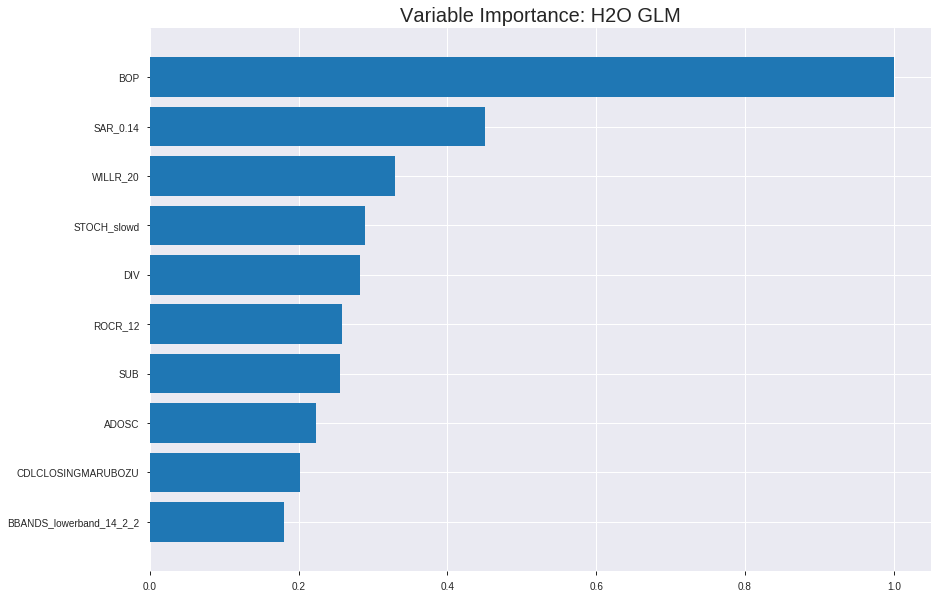

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190827_213400_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.19365308253656346
RMSE: 0.4400603169300357
LogLoss: 0.5684548171305845
Null degrees of freedom: 1740
Residual degrees of freedom: 1690
Null deviance: 2411.5386742145683
Residual deviance: 1979.3596732486953
AIC: 2081.3596732486953
AUC: 0.7721178491214162
pr_auc: 0.7691003126050332
Gini: 0.5442356982428325
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.34517754350775504: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      367  474   0.5636   (474.0/841.0)
1      89   811   0.0989   (89.0/900.0)
Total  456  1285  0.3234   (563.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.345178     0.742334  274
max f2                       0.15273      0.854267  357
max f0point5                 0.561489     0.716522  172
max accuracy                 0.498551     0.707639  204
max precision                0.965021     1         0
max recall                   0.0702809    1         386
max specificity              0.965021     1         0
max absolute_mcc             0.49505      0.414285  205
max min_per_class_accuracy   0.531        0.697778  188
max mean_per_class_accuracy  0.498551     0.706114  204

Gains/Lift Table: Avg response rate: 51.69 %, avg score: 51.69 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.929815           1.93444   1.93444            1                0.945612  1                           0.945612            0.02            0.02                       93.4444   93.4444
    2        0.0201034                   0.907588           1.70686   1.8239             0.882353         0.9184    0.942857                    0.932395            0.0166667       0.0366667                  70.6863   82.3905
    3        0.0304423                   0.884878           1.71951   1.78845            0.888889         0.896216  0.924528                    0.920108            0.0177778       0.0544444                  71.9506   78.8449
    4        0.0402068                   0.870342           1.59307   1.741              0.823529         0.876545  0.9                         0.909528            0.0155556       0.07                       59.3072   74.1
    5        0.0505457                   0.854205           1.93444   1.78057            1                0.861161  0.920455                    0.899635            0.02            0.09                       93.4444   78.0568
    6        0.100517                    0.805796           1.62315   1.70231            0.83908          0.831002  0.88                        0.865515            0.0811111       0.171111                   62.3155   70.2311
    7        0.150488                    0.765857           1.44527   1.61696            0.747126         0.784238  0.835878                    0.838526            0.0722222       0.243333                   44.5275   61.6959
    8        0.20046                     0.736302           1.35633   1.55199            0.701149         0.750436  0.802292                    0.816566            0.0677778       0.311111                   35.6335   55.199
    9        0.300402                    0.678396           1.47863   1.52758            0.764368         0.706394  0.789675                    0.779913            0.147778        0.458889                   47.8627   52.7582
    10       0.400345                    0.616381           1.21181   1.44875            0.626437         0.648657  0.748924                    0.747146            0.121111        0.58                       21.1807   44.8752
    11       0.500287                    0.532849           1.12287   1.38365            0.58046          0.574541  0.71527                     0.712664            0.112222        0.692222                   12.2867   38.365
    12       0.60023                     0.454197           0.989457  1.31801            0.511494         0.495799  0.68134                     0.676555            0.0988889       0.791111                   -1.05428  31.8014
    13       0.700172                    0.377665           0.767107  1.23938            0.396552         0.415901  0.640689                    0.639349            0.0766667       0.867778                   -23.2893  23.9377
    14       0.800115                    0.289413           0.71152   1.17344            0.367816         0.334169  0.606604                    0.601229            0.0711111       0.938889                   -28.848   17.3443
    15       0.900057                    0.187756           0.40023   1.08758            0.206897         0.24053   0.562221                    0.561177            0.04            0.978889                   -59.977   8.75849
    16       1                           0.0125379          0.211232  1                  0.109195         0.118598  0.516944                    0.516944            0.



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.20850894718291
RMSE: 0.4566277993978356
LogLoss: 0.6065116865808649
Null degrees of freedom: 497
Residual degrees of freedom: 447
Null deviance: 688.6415356931332
Residual deviance: 604.0856398345416
AIC: 706.0856398345416
AUC: 0.762615050557428
pr_auc: 0.7303325534124353
Gini: 0.5252301011148559
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.25735765286420637: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      103  129  0.556    (129.0/232.0)
1      21   245  0.0789   (21.0/266.0)
Total  124  374  0.3012   (150.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.257358     0.765625  296
max f2                       0.157632     0.868687  336
max f0point5                 0.433447     0.736926  201
max accuracy                 0.350211     0.714859  251
max precision                0.938324     1         0
max recall                   0.0374026    1         389
max specificity              0.938324     1         0
max absolute_mcc             0.331746     0.430671  260
max min_per_class_accuracy   0.42063      0.711207  207
max mean_per_class_accuracy  0.433447     0.713848  201

Gains/Lift Table: Avg response rate: 53.41 %, avg score: 43.37 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100402                   0.891395           1.12331   1.12331            0.6              0.91955    0.6                         0.91955             0.0112782       0.0112782                  12.3308   12.3308
    2        0.0200803                   0.866686           1.87218   1.49774            1                0.882959   0.8                         0.901254            0.018797        0.0300752                  87.218    49.7744
    3        0.0301205                   0.845478           1.49774   1.49774            0.8              0.854243   0.8                         0.885584            0.0150376       0.0451128                  49.7744   49.7744
    4        0.0401606                   0.832229           1.12331   1.40414            0.6              0.840518   0.75                        0.874317            0.0112782       0.056391                   12.3308   40.4135
    5        0.0502008                   0.806046           0.748872  1.27308            0.4              0.822826   0.68                        0.864019            0.0075188       0.0639098                  -25.1128  27.3083
    6        0.100402                    0.736563           1.64752   1.4603             0.88             0.766593   0.78                        0.815306            0.0827068       0.146617                   64.7519   46.0301
    7        0.150602                    0.695537           1.34797   1.42286            0.72             0.71865    0.76                        0.783087            0.0676692       0.214286                   34.797    42.2857
    8        0.200803                    0.658342           1.49774   1.44158            0.8              0.676008   0.77                        0.756318            0.075188        0.289474                   49.7744   44.1579
    9        0.301205                    0.579991           1.42286   1.43534            0.76             0.620709   0.766667                    0.711115            0.142857        0.432331                   42.2857   43.5338
    10       0.399598                    0.506979           1.33727   1.41119            0.714286         0.541523   0.753769                    0.669356            0.131579        0.56391                    33.7272   41.1191
    11       0.5                         0.431004           1.34797   1.3985             0.72             0.469596   0.746988                    0.629244            0.135338        0.699248                   34.797    39.8496
    12       0.600402                    0.367311           0.861203  1.30865            0.46             0.398149   0.698997                    0.590599            0.0864662       0.785714                   -13.8797  30.8648
    13       0.698795                    0.292507           0.916986  1.2535             0.489796         0.331417   0.66954                     0.554105            0.0902256       0.87594                    -8.30137  25.35
    14       0.799197                    0.199056           0.636541  1.17599            0.34             0.254873   0.628141                    0.516513            0.0639098       0.93985                    -36.3459  17.5993
    15       0.899598                    0.0963583          0.449323  1.09489            0.24             0.151256   0.584821                    0.475748            0.0451128       0.984962                   -55.0677  9.48912
    16       1                           0.00515779         0.149774  1                  0.08             0.0574125  0.534137                    0


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-27 21:34:01  0.000 sec   2            .21E2     51            1.3690942727759043  1.3652769862472427
     2019-08-27 21:34:01  0.067 sec   4            .13E2     51            1.3605664656133625  1.3566458546800173
     2019-08-27 21:34:01  0.118 sec   6            .82E1     51            1.3483949463054479  1.344875089557043
     2019-08-27 21:34:01  0.170 sec   8            .51E1     51            1.331897923067482   1.3295891395115116
     2019-08-27 21:34:01  0.221 sec   10           .32E1     51            1.310948707383916   1.3108679613822816
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-27 21:34:01  0.488 sec   38           .4E-2     51            1.1349275814422066  1.2136335762907062
     2019-08-27 21:34:01  0.510 sec   40           .25E-2    51            1.1328020535397973  1.215555311149472
     2019-08-27 21:34:01  0.529 sec   42           .15E-2    51            1.1303592005792316  1.2196376410623546
     2019-08-27 21:34:01  0.543 sec   44           .96E-3    51            1.1276028044299948  1.226988537126098
     2019-08-27 21:34:01  0.558 sec   46           .6E-3     51            1.1247402757103706  1.238766280891008


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6746987951807228)

('F1', 0.7515151515151515)

('auc', 0.7172649793388429)

('logloss', 0.7233176092315987)

('mean_per_class_error', 0.3319989669421488)

('rmse', 0.5051042635978509)

('mse', 0.2551303171047273)

glm prediction progress: |████████████████████████████████████████████████| 100%


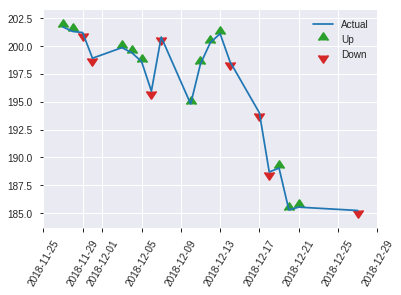


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2551303171047273
RMSE: 0.5051042635978509
LogLoss: 0.7233176092315987
Null degrees of freedom: 248
Residual degrees of freedom: 198
Null deviance: 344.9987988800806
Residual deviance: 360.2121693973361
AIC: 462.2121693973361
AUC: 0.7172649793388429
pr_auc: 0.6981278285023028
Gini: 0.43452995867768585
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.11293378369904025: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      43   78   0.6446   (78.0/121.0)
1      4    124  0.0312   (4.0/128.0)
Total  47   202  0.3293   (82.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.112934     0.751515  201
max f2                       0.112934     0.868347  201
max f0point5                 0.143266     0.668203  184
max accuracy                 0.143266     0.674699  184
max precision                0.901562     1         0
max recall                   0.027629     1         239
max specificity              0.901562     1         0
max absolute_mcc             0.112934     0.413982  201
max min_per_class_accuracy   0.298188     0.648438  124
max mean_per_class_accuracy  0.143266     0.668001  184

Gains/Lift Table: Avg response rate: 51.41 %, avg score: 32.02 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.839677           1.94531   1.94531            1                0.865235   1                           0.865235            0.0234375       0.0234375                  94.5313   94.5313
    2        0.0200803                   0.831362           0.972656  1.55625            0.5              0.831912   0.8                         0.851906            0.0078125       0.03125                    -2.73437  55.625
    3        0.0321285                   0.718549           1.29688   1.45898            0.666667         0.770945   0.75                        0.821545            0.015625        0.046875                   29.6875   45.8984
    4        0.0401606                   0.701311           1.94531   1.55625            1                0.71561    0.8                         0.800358            0.015625        0.0625                     94.5313   55.625
    5        0.0522088                   0.686104           1.29688   1.49639            0.666667         0.694946   0.769231                    0.776032            0.015625        0.078125                   29.6875   49.6394
    6        0.100402                    0.622225           1.62109   1.55625            0.833333         0.650493   0.8                         0.715774            0.078125        0.15625                    62.1094   55.625
    7        0.15261                     0.558001           1.49639   1.53577            0.769231         0.592997   0.789474                    0.673771            0.078125        0.234375                   49.6394   53.5773
    8        0.200803                    0.521243           1.7832    1.59516            0.916667         0.539922   0.82                        0.641647            0.0859375       0.320312                   78.3203   59.5156
    9        0.301205                    0.434947           1.01156   1.40063            0.52             0.472007   0.72                        0.585101            0.101562        0.421875                   1.15625   40.0625
    10       0.401606                    0.355544           1.08938   1.32281            0.56             0.395292   0.68                        0.537649            0.109375        0.53125                    8.9375    32.2813
    11       0.502008                    0.298188           1.16719   1.29169            0.6              0.323884   0.664                       0.494896            0.117188        0.648438                   16.7188   29.1688
    12       0.598394                    0.229694           0.891602  1.22724            0.458333         0.267405   0.630872                    0.458253            0.0859375       0.734375                   -10.8398  22.7244
    13       0.698795                    0.168974           0.93375   1.18508            0.48             0.194414   0.609195                    0.420345            0.09375         0.828125                   -6.625    18.5075
    14       0.799197                    0.113831           1.245     1.1926             0.64             0.138115   0.613065                    0.384889            0.125           0.953125                   24.5      19.2604
    15       0.899598                    0.0667124          0.155625  1.07687            0.08             0.0898721  0.553571                    0.351963            0.015625        0.96875                    -84.4375  7.68694
    16       1                           0.00122236         0.31125   1                  0.16             0.0356747  0.514056                    0.

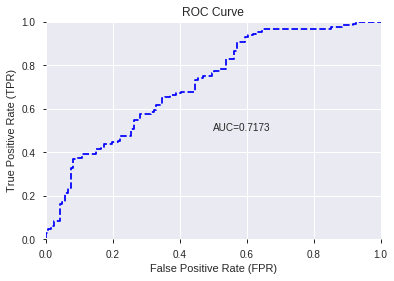

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


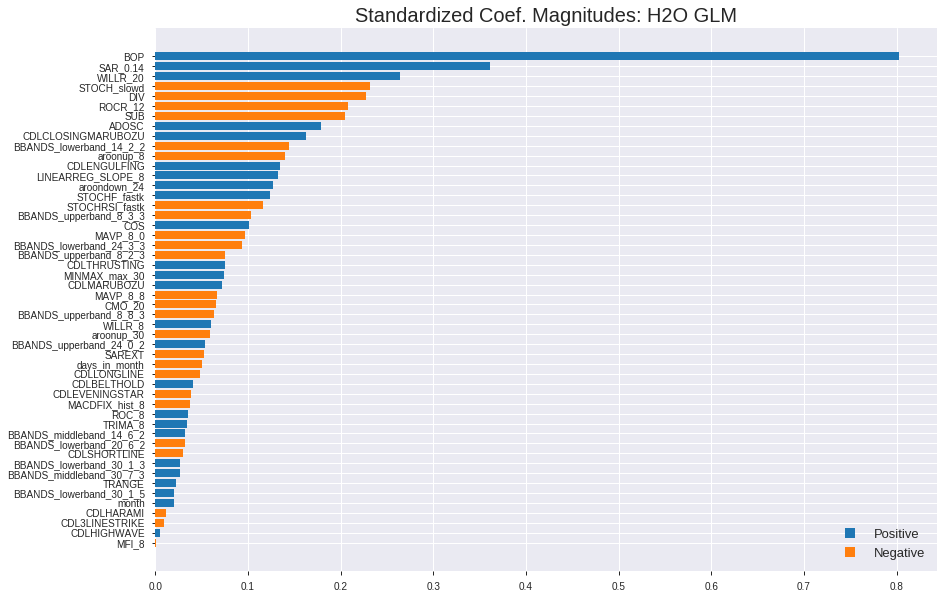

'log_likelihood'
--2019-08-27 21:34:12--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.132.123
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.132.123|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190827_213400_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190827_213400_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_8479',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['BOP',
 'SAR_0.14',
 'WILLR_20',
 'STOCH_slowd',
 'DIV',
 'ROCR_12',
 'SUB',
 'ADOSC',
 'CDLCLOSINGMARUBOZU',
 'BBANDS_lowerband_14_2_2',
 'aroonup_8',
 'CDLENGULFING',
 'LINEARREG_SLOPE_8',
 'aroondown_24',
 'STOCHF_fastk',
 'STOCHRSI_fastk',
 'BBANDS_upperband_8_3_3',
 'COS',
 'MAVP_8_0',
 'BBANDS_lowerband_24_3_3',
 'BBANDS_upperband_8_2_3',
 'CDLTHRUSTING',
 'MINMAX_max_30',
 'CDLMARUBOZU',
 'MAVP_8_8',
 'CMO_20',
 'BBANDS_upperband_8_8_3',
 'WILLR_8',
 'aroonup_30',
 'BBANDS_upperband_24_0_2',
 'SAREXT',
 'days_in_month',
 'CDLLONGLINE',
 'CDLBELTHOLD',
 'CDLEVENINGSTAR',
 'MACDFIX_hist_8',
 'ROC_8',
 'TRIMA_8',
 'BBANDS_middleband_14_6_2',
 'BBANDS_lowerband_20_6_2',
 'CDLSHORTLINE',
 'BBANDS_lowerband_30_1_3',
 'BBANDS_middleband_30_7_3',
 'TRANGE',
 'BBANDS_lowerband_30_1_5',
 'month',
 'CDLHARAMI',
 'CDL3LINESTRIKE',
 'CDLHIGHWAVE',
 'MFI_8']

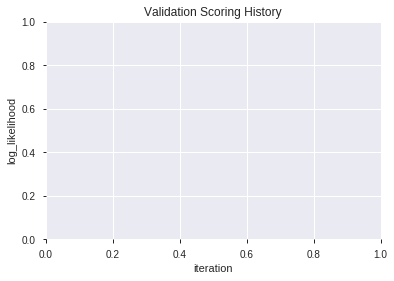

In [12]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_1_AutoML_20190827_213508  0.725142  0.618206              0.403603  0.463096  0.214458
1  XGBoost_grid_1_AutoML_20190827_213508_model_4  0.723270  0.615497              0.317794  0.462174  0.213605
2  XGBoost_grid_1_AutoML_20190827_213508_model_1  0.719848  0.611116              0.339134  0.460670  0.212217
3               XGBoost_3_AutoML_20190827_213508  0.718879  0.616423              0.325381  0.462400  0.213814
4               XGBoost_2_AutoML_20190827_213508  0.714618  0.622704              0.368963  0.465591  0.216775
5  XGBoost_grid_1_AutoML_20190827_213508_model_6  0.714230  0.618837              0.378809  0.463652  0.214973
6  XGBoost_grid_1_AutoML_20190827_213508_model_3  0.709388  0.624202              0.377228  0.465883  0.217047
7  XGBoost_grid_1_AutoML_20190827_213508_model_2  0.702350  0.633404              0.373321  0.470307  0.221188
8  XGBoost_grid_1_AutoML_20190827_213508_model_5  0.700930  0.627839              0.373547  0.468022  0.219044
9  XGBoost_grid_1_AutoML_20190827_213508_model_7  0.698218  0.631485              0.352208  0.470564  0.221431

variable  relative_importance  scaled_importance  percentage
0                        BOP          2209.006348           1.000000    0.243619
1                        SUB           566.156616           0.256295    0.062438
2               STOCHF_fastk           495.736633           0.224416    0.054672
3                        DIV           485.882843           0.219955    0.053585
4                     TRANGE           329.820587           0.149307    0.036374
5                STOCH_slowd           327.457642           0.148238    0.036113
6                   WILLR_20           296.979645           0.134440    0.032752
7             STOCHRSI_fastk           292.236481           0.132293    0.032229
8                      ADOSC           288.185364           0.130459    0.031782
9                    ROCR_12           276.509705           0.125174    0.030495
10                aroonup_30           258.539307           0.117039    0.028513
11                     MFI_8           257.608063           0.116617    0.028410
12                       COS           244.894089           0.110862    0.027008
13                   WILLR_8           239.861435           0.108583    0.026453
14            MACDFIX_hist_8           236.689819           0.107148    0.026103
15                     ROC_8           228.501556           0.103441    0.025200
16                    SAREXT           189.926056           0.085978    0.020946
17         LINEARREG_SLOPE_8           175.385315           0.079396    0.019342
18              aroondown_24           158.364044           0.071690    0.017465
19                 aroonup_8           147.197327           0.066635    0.016234
20                    CMO_20           137.112183           0.062070    0.015121
21   BBANDS_lowerband_30_1_5           118.079361           0.053454    0.013022
22                     month            99.365417           0.044982    0.010958
23   BBANDS_upperband_24_0_2            96.962090           0.043894    0.010693
24   BBANDS_lowerband_30_1_3            96.214279           0.043555    0.010611
25               CDLBELTHOLD            84.614662           0.038304    0.009332
26    BBANDS_upperband_8_2_3            77.334282           0.035009    0.008529
27    BBANDS_upperband_8_3_3            57.918880           0.026219    0.006388
28   BBANDS_lowerband_20_6_2            56.378735           0.025522    0.006218
29    BBANDS_upperband_8_8_3            56.288799           0.025482    0.006208
30  BBANDS_middleband_14_6_2            55.456688           0.025105    0.006116
31                  SAR_0.14            53.325470           0.024140    0.005881
32                   TRIMA_8            51.985466           0.023533    0.005733
33   BBANDS_lowerband_24_3_3            49.998337           0.022634    0.005514
34              CDLSHORTLINE            48.985767           0.022175    0.005402
35                  MAVP_8_0            44.034489           0.019934    0.004856
36        CDLCLOSINGMARUBOZU            41.873619           0.018956    0.004618
37   BBANDS_lowerband_14_2_2            37.416637           0.016938    0.004126
38             days_in_month            35.810055           0.016211    0.003949
39                  MAVP_8_8            26.583416           0.012034    0.002932
40             MINMAX_max_30            13.515503           0.006118    0.001491
41               CDLLONGLINE             8.813705           0.003990    0.000972
42                 CDLHARAMI             5.881460           0.002662    0.000649
43  BBANDS_middleband_30_7_3             5.358531           0.002426    0.000591
44              CDLENGULFING             3.232578           0.001463    0.000357

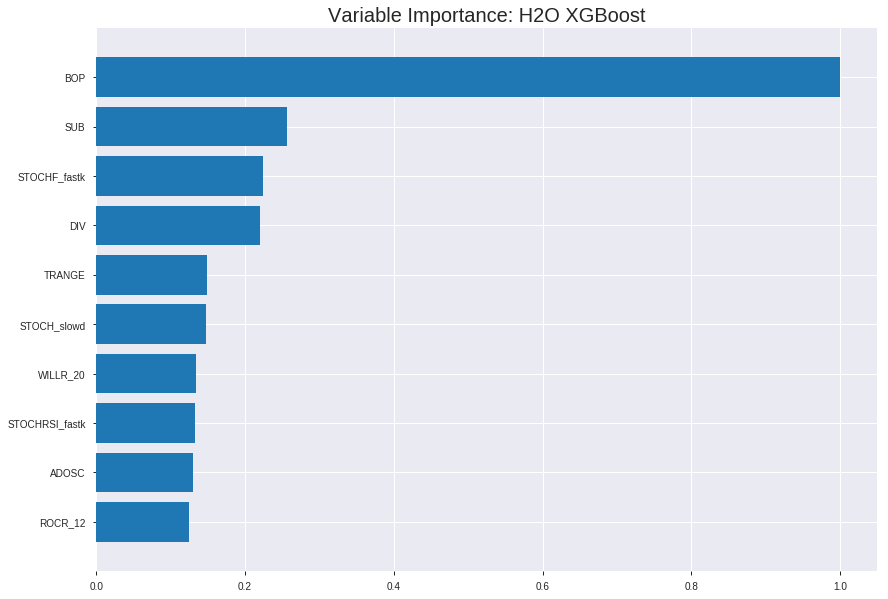

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_1_AutoML_20190827_213508


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.12261900176301942
RMSE: 0.35016996125170335
LogLoss: 0.4058104623823863
Mean Per-Class Error: 0.14182124455013878
AUC: 0.9390144008455542
pr_auc: 0.9454153946796349
Gini: 0.8780288016911084
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48622171580791473: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      687  154  0.1831   (154.0/841.0)
1      96   804  0.1067   (96.0/900.0)
Total  783  958  0.1436   (250.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.486222     0.865447  208
max f2                       0.3766       0.915286  256
max f0point5                 0.602994     0.881443  156
max accuracy                 0.527667     0.858128  192
max precision                0.938258     1         0
max recall                   0.201705     1         334
max specificity              0.938258     1         0
max absolute_mcc             0.527667     0.716108  192
max min_per_class_accuracy   0.527667     0.856667  192
max mean_per_class_accuracy  0.527667     0.858179  192

Gains/Lift Table: Avg response rate: 51.69 %, avg score: 51.43 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.90646            1.93444   1.93444            1                0.916773  1                           0.916773            0.02            0.02                       93.4444   93.4444
    2        0.0201034                   0.892211           1.93444   1.93444            1                0.898994  1                           0.908138            0.0188889       0.0388889                  93.4444   93.4444
    3        0.0304423                   0.88305            1.93444   1.93444            1                0.887489  1                           0.901125            0.02            0.0588889                  93.4444   93.4444
    4        0.0402068                   0.875185           1.93444   1.93444            1                0.877561  1                           0.895402            0.0188889       0.0777778                  93.4444   93.4444
    5        0.0505457                   0.867902           1.93444   1.93444            1                0.871851  1                           0.890585            0.02            0.0977778                  93.4444   93.4444
    6        0.100517                    0.832621           1.93444   1.93444            1                0.848834  1                           0.869829            0.0966667       0.194444                   93.4444   93.4444
    7        0.150488                    0.800145           1.93444   1.93444            1                0.814762  1                           0.851543            0.0966667       0.291111                   93.4444   93.4444
    8        0.20046                     0.770454           1.88997   1.92336            0.977011         0.784064  0.994269                    0.834722            0.0944444       0.385556                   88.9974   92.3359
    9        0.300402                    0.701679           1.8455    1.89746            0.954023         0.737347  0.98088                     0.802326            0.184444        0.57                       84.5504   89.7457
    10       0.400345                    0.622273           1.50086   1.79845            0.775862         0.661794  0.929699                    0.767243            0.15            0.72                       50.0862   79.8451
    11       0.500287                    0.534322           1.24516   1.68792            0.643678         0.579869  0.87256                     0.729811            0.124444        0.844444                   24.516    68.7919
    12       0.60023                     0.437585           0.833812  1.5457             0.431034         0.487233  0.799043                    0.68942             0.0833333       0.927778                   -16.6188  54.5704
    13       0.700172                    0.350637           0.4447    1.38855            0.229885         0.394285  0.717801                    0.647293            0.0444444       0.972222                   -55.53    38.8547
    14       0.800115                    0.249147           0.166762  1.23593            0.0862069        0.300103  0.638909                    0.603925            0.0166667       0.988889                   -83.3238  23.5934
    15       0.900057                    0.160651           0.111175  1.11104            0.0574713        0.201471  0.574346                    0.559237            0.0111111       1                          -88.8825  11.104
    16       1                           0.0558082          0         1                  0                0.109322  0.516944                    0.514271          



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.20711594150799875
RMSE: 0.4550999247505967
LogLoss: 0.6025307282064007
Mean Per-Class Error: 0.3100045372050817
AUC: 0.7371580891884885
pr_auc: 0.7180387858111882
Gini: 0.4743161783769769
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3406056761741638: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      100  132  0.569    (132.0/232.0)
1      29   237  0.109    (29.0/266.0)
Total  129  369  0.3233   (161.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.340606     0.746457  290
max f2                       0.192033     0.864811  357
max f0point5                 0.534696     0.711948  186
max accuracy                 0.44577      0.696787  240
max precision                0.90356      1         0
max recall                   0.10046      1         395
max specificity              0.90356      1         0
max absolute_mcc             0.442086     0.389262  242
max min_per_class_accuracy   0.517463     0.669173  196
max mean_per_class_accuracy  0.44577      0.689995  240

Gains/Lift Table: Avg response rate: 53.41 %, avg score: 50.85 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100402                   0.883273           1.12331   1.12331            0.6              0.896041  0.6                         0.896041            0.0112782       0.0112782                  12.3308   12.3308
    2        0.0200803                   0.858919           1.87218   1.49774            1                0.875822  0.8                         0.885932            0.018797        0.0300752                  87.218    49.7744
    3        0.0301205                   0.84997            1.49774   1.49774            0.8              0.853039  0.8                         0.874968            0.0150376       0.0451128                  49.7744   49.7744
    4        0.0401606                   0.843075           1.87218   1.59135            1                0.847086  0.85                        0.867997            0.018797        0.0639098                  87.218    59.1353
    5        0.0502008                   0.839829           1.12331   1.49774            0.6              0.84126   0.8                         0.86265             0.0112782       0.075188                   12.3308   49.7744
    6        0.100402                    0.809601           1.34797   1.42286            0.72             0.823578  0.76                        0.843114            0.0676692       0.142857                   34.797    42.2857
    7        0.150602                    0.766307           1.42286   1.42286            0.76             0.787259  0.76                        0.824496            0.0714286       0.214286                   42.2857   42.2857
    8        0.200803                    0.730646           1.27308   1.38541            0.68             0.745554  0.74                        0.80476             0.0639098       0.278195                   27.3083   38.5414
    9        0.301205                    0.654313           1.57263   1.44782            0.84             0.693078  0.773333                    0.767533            0.157895        0.43609                    57.2632   44.782
    10       0.399598                    0.580269           1.10803   1.36415            0.591837         0.614839  0.728643                    0.729935            0.109023        0.545113                   10.8025   36.4152
    11       0.5                         0.519756           1.16075   1.32331            0.62             0.551751  0.706827                    0.694155            0.116541        0.661654                   16.0752   32.3308
    12       0.600402                    0.452121           1.12331   1.28986            0.6              0.481547  0.688963                    0.658602            0.112782        0.774436                   12.3308   28.9863
    13       0.698795                    0.383825           0.764155  1.21584            0.408163         0.417453  0.649425                    0.624647            0.075188        0.849624                   -23.5845  21.5841
    14       0.799197                    0.283619           0.561654  1.13366            0.3              0.332651  0.605528                    0.587964            0.056391        0.906015                   -43.8346  13.3657
    15       0.899598                    0.185702           0.748872  1.09071            0.4              0.239459  0.582589                    0.549068            0.075188        0.981203                   -25.1128  9.07123
    16       1                           0.0878195          0.187218  1                  0.1              0.144953  0.534137                    0.508495          


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 21:35:09  0.208 sec   0                  0.5              0.693147            0.5             0                  1                0.483056                         0.5                0.693147              0.5               0                    1                  0.465863
    2019-08-27 21:35:09  0.432 sec   5                  0.470603         0.635699            0.848461        0.850708           1.93444          0.237794                         0.482596           0.658763              0.723384          0.68528              0.802363           0.311245
    2019-08-27 21:35:09  0.537 sec   10                 0.448346         0.593263            0.867528        0.875786           1.93444          0.224009                         0.474519           0.642824              0.725637          0.694077             1.17011            0.325301
    2019-08-27 21:35:09  0.640 sec   15                 0.430646         0.559582            0.87828         0.885349           1.93444          0.214819                         0.467116           0.628013              0.728181          0.695562             0.748872           0.359438
    2019-08-27 21:35:09  0.738 sec   20                 0.416356         0.532231            0.886632        0.8955             1.93444          0.20448                          0.464566           0.622577              0.727654          0.700615             0.748872           0.369478
    2019-08-27 21:35:09  0.841 sec   25                 0.40465          0.509496            0.894414        0.90058            1.93444          0.203906                         0.461219           0.615732              0.730198          0.700823             1.12331            0.345382
    2019-08-27 21:35:09  0.950 sec   30                 0.393463         0.488333            0.906136        0.913261           1.93444          0.188397                         0.458542           0.610313              0.733358          0.707504             1.49774            0.35743
    2019-08-27 21:35:09  1.076 sec   35                 0.384894         0.471504            0.911118        0.918406           1.93444          0.184377                         0.457332           0.607446              0.733512          0.711344             1.12331            0.315261
    2019-08-27 21:35:10  1.201 sec   40                 0.376863         0.455951            0.916748        0.924514           1.93444          0.172315                         0.454869           0.602287              0.736526          0.717721             1.12331            0.333333
    2019-08-27 21:35:10  1.352 sec   45                 0.36988          0.442608            0.922185        0.929372           1.93444          0.165997                         0.454658           0.601654              0.737328          0.719646             1.12331            0.325301
    2019-08-27 21:35:10  1.485 sec   50                 0.363322         0.429921            0.927772        0.93547            1.93444          0.156806                         0.455135           0.602485              0.736048          0.720526             1.49774            0.321285
    2019-08-27 21:35:10  1.627 sec   55                 0.356816         0.418075            0.933762        0.940642           1.93444          0.152211                         0.454913           0.601712              0.738211          0.

Variable Importances: 


variable                  relative_importance    scaled_importance      percentage
------------------------  ---------------------  ---------------------  ---------------------
BOP                       2209.00634765625       1.0                    0.24361857122923716
SUB                       566.1566162109375      0.2562946986601592     0.06243814830121587
STOCHF_fastk              495.73663330078125     0.2244161198661817     0.05467193448260841
DIV                       485.8828430175781      0.21995538561177       0.053585216776915315
TRANGE                    329.8205871582031      0.14930721566651084    0.036374010554890944
---                       ---                    ---                    ---
MINMAX_max_30             13.5155029296875       0.0061183631020469515  0.0014905468771823616
CDLLONGLINE               8.813705444335938      0.00398989593383797    0.0009720127467549492
CDLHARAMI                 5.881459712982178      0.0026624910875527323  0.0006486322746601744
BBANDS_middleband_30_7_3  5.358531475067139      0.0024257655396746716  0.0005909615349126629
CDLENGULFING              3.2325782775878906     0.001463363055075712   0.0003565024166671965


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.678714859437751)

('F1', 0.7134502923976607)

('auc', 0.7251420454545454)

('logloss', 0.6182062468156464)

('mean_per_class_error', 0.3204093491735538)

('rmse', 0.4630959070465152)

('mse', 0.21445781912323467)

xgboost prediction progress: |████████████████████████████████████████████| 100%


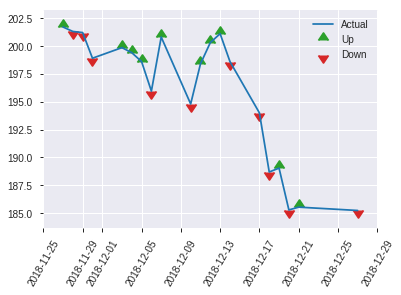


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.21445781912323467
RMSE: 0.4630959070465152
LogLoss: 0.6182062468156464
Mean Per-Class Error: 0.3204093491735538
AUC: 0.7251420454545454
pr_auc: 0.7302377842379069
Gini: 0.45028409090909083
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.21519047021865845: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      29   92   0.7603   (92.0/121.0)
1      6    122  0.0469   (6.0/128.0)
Total  35   214  0.3936   (98.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.21519      0.71345   213
max f2                       0.173357     0.845839  220
max f0point5                 0.480455     0.691667  117
max accuracy                 0.480455     0.678715  117
max precision                0.878638     1         0
max recall                   0.104367     1         244
max specificity              0.878638     1         0
max absolute_mcc             0.607967     0.36149   67
max min_per_class_accuracy   0.472175     0.669421  125
max mean_per_class_accuracy  0.480455     0.679591  117

Gains/Lift Table: Avg response rate: 51.41 %, avg score: 46.31 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.834845           1.94531   1.94531            1                0.856886  1                           0.856886            0.0234375       0.0234375                  94.5313   94.5313
    2        0.0200803                   0.819811           1.94531   1.94531            1                0.826857  1                           0.844874            0.015625        0.0390625                  94.5313   94.5313
    3        0.0321285                   0.811981           1.29688   1.70215            0.666667         0.817356  0.875                       0.834555            0.015625        0.0546875                  29.6875   70.2148
    4        0.0401606                   0.800103           1.94531   1.75078            1                0.804906  0.9                         0.828625            0.015625        0.0703125                  94.5313   75.0781
    5        0.0522088                   0.792739           1.29688   1.64603            0.666667         0.796872  0.846154                    0.821298            0.015625        0.0859375                  29.6875   64.6034
    6        0.100402                    0.743579           1.7832    1.71188            0.916667         0.773848  0.88                        0.798522            0.0859375       0.171875                   78.3203   71.1875
    7        0.15261                     0.698716           1.34675   1.58697            0.692308         0.718444  0.815789                    0.771127            0.0703125       0.242188                   34.6755   58.6965
    8        0.200803                    0.668783           1.7832    1.63406            0.916667         0.684232  0.84                        0.750272            0.0859375       0.328125                   78.3203   63.4063
    9        0.301205                    0.59275            1.245     1.50438            0.64             0.625126  0.773333                    0.708557            0.125           0.453125                   24.5      50.4375
    10       0.401606                    0.512272           1.08938   1.40063            0.56             0.55504   0.72                        0.670177            0.109375        0.5625                     8.9375    40.0625
    11       0.502008                    0.472654           1.01156   1.32281            0.52             0.488808  0.68                        0.633904            0.101562        0.664062                   1.15625   32.2813
    12       0.598394                    0.414748           0.810547  1.2403             0.416667         0.447717  0.637584                    0.603914            0.078125        0.742188                   -18.9453  24.03
    13       0.698795                    0.32867            0.700313  1.16272            0.36             0.371597  0.597701                    0.570535            0.0703125       0.8125                     -29.9688  16.2716
    14       0.799197                    0.256483           0.855938  1.12418            0.44             0.295324  0.577889                    0.535961            0.0859375       0.898438                   -14.4062  12.4176
    15       0.899598                    0.169012           0.700313  1.07687            0.36             0.215064  0.553571                    0.500146            0.0703125       0.96875                    -29.9688  7.68694
    16       1                           0.0867194          0.31125   1                  0.16             0.131124  0.514056                    0.463096           

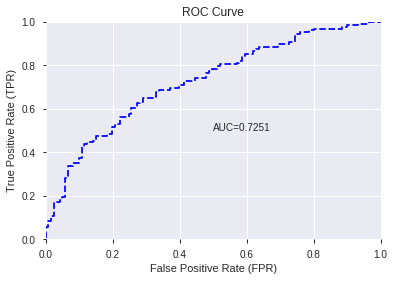

This function is available for GLM models only


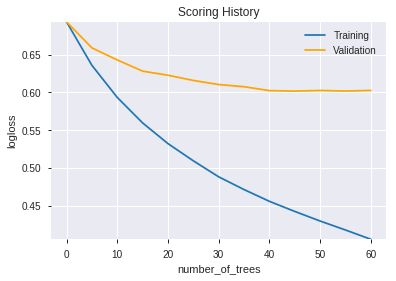

--2019-08-27 21:35:37--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.165.59
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.165.59|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.calculateChildInclusiveNa(SharedTreeNode.java:133)
	at hex.genmodel.algos.tree.SharedTreeNode.setLeftChild(SharedTreeNode.java:207)
	at hex.genmodel.algos.tree.SharedTreeSubgraph.makeLeftEdge(SharedT

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_1_AutoML_20190827_213508',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_1_AutoML_20190827_213508',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_8479',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_26_sid_8479',
   'type

['BOP',
 'SUB',
 'STOCHF_fastk',
 'DIV',
 'TRANGE',
 'STOCH_slowd',
 'WILLR_20',
 'STOCHRSI_fastk',
 'ADOSC',
 'ROCR_12',
 'aroonup_30',
 'MFI_8',
 'COS',
 'WILLR_8',
 'MACDFIX_hist_8',
 'ROC_8',
 'SAREXT',
 'LINEARREG_SLOPE_8',
 'aroondown_24',
 'aroonup_8',
 'CMO_20',
 'BBANDS_lowerband_30_1_5',
 'month',
 'BBANDS_upperband_24_0_2',
 'BBANDS_lowerband_30_1_3',
 'CDLBELTHOLD',
 'BBANDS_upperband_8_2_3',
 'BBANDS_upperband_8_3_3',
 'BBANDS_lowerband_20_6_2',
 'BBANDS_upperband_8_8_3',
 'BBANDS_middleband_14_6_2',
 'SAR_0.14',
 'TRIMA_8',
 'BBANDS_lowerband_24_3_3',
 'CDLSHORTLINE',
 'MAVP_8_0',
 'CDLCLOSINGMARUBOZU',
 'BBANDS_lowerband_14_2_2',
 'days_in_month',
 'MAVP_8_8',
 'MINMAX_max_30',
 'CDLLONGLINE',
 'CDLHARAMI',
 'BBANDS_middleband_30_7_3',
 'CDLENGULFING']

In [13]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id  auc    logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190827_213634_model_1  0.5  16.783903                   0.5  0.697097  0.485944

variable  relative_importance  scaled_importance  percentage
0                         BOP             0.009381           1.000000    0.031900
1                 CDLLONGLINE             0.005882           0.627005    0.020001
2                STOCHF_fastk             0.005552           0.591872    0.018881
3          CDLCLOSINGMARUBOZU             0.005534           0.589916    0.018818
4              STOCHRSI_fastk             0.005423           0.578118    0.018442
...                       ...                  ...                ...         ...
1034  BBANDS_upperband_30_6_3             0.000000           0.000000    0.000000
1035  BBANDS_lowerband_30_7_2             0.000000           0.000000    0.000000
1036              MINUS_DM_20             0.000000           0.000000    0.000000
1037           CDL3LINESTRIKE             0.000000           0.000000    0.000000
1038         CDLCOUNTERATTACK             0.000000           0.000000    0.000000

[1039 rows x 4 columns]

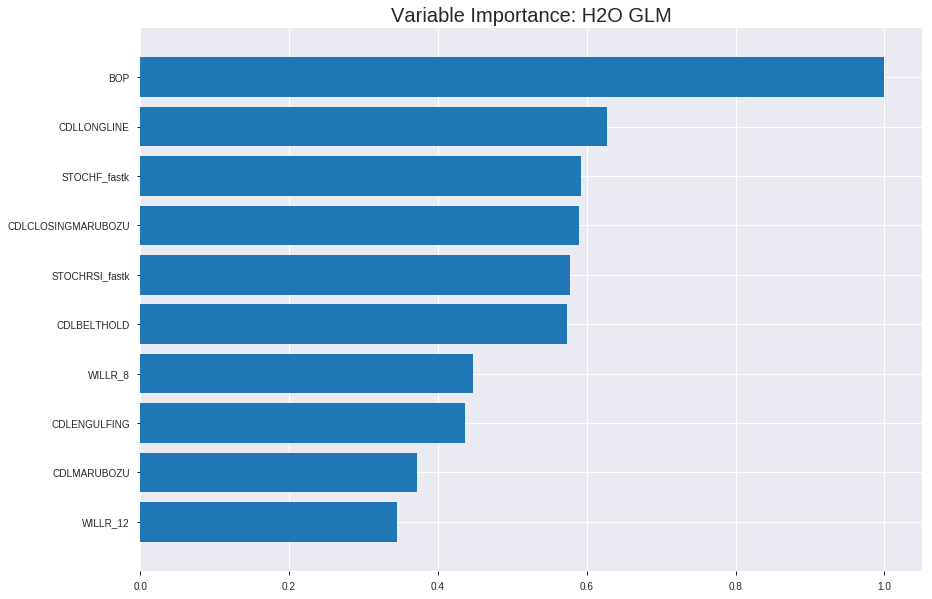

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190827_213634_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24386857765814415
RMSE: 0.4938305151143904
LogLoss: 0.6808527117025068
Null degrees of freedom: 1740
Residual degrees of freedom: 726
Null deviance: 2411.5386742145683
Residual deviance: 2370.7291421481286
AIC: 4400.729142148129
AUC: 0.6607273087594133
pr_auc: 0.6620968903773805
Gini: 0.32145461751882665
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48996814062716737: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      156  685   0.8145   (685.0/841.0)
1      53   847   0.0589   (53.0/900.0)
Total  209  1532  0.4239   (738.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.489968     0.696546  322
max f2                       0.469498     0.844474  379
max f0point5                 0.510069     0.631659  232
max accuracy                 0.510069     0.620333  232
max precision                0.583611     1         0
max recall                   0.456248     1         396
max specificity              0.583611     1         0
max absolute_mcc             0.510069     0.239976  232
max min_per_class_accuracy   0.517376     0.617122  196
max mean_per_class_accuracy  0.517702     0.618678  195

Gains/Lift Table: Avg response rate: 51.69 %, avg score: 51.69 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.563896           1.82698   1.82698            0.944444         0.570152  0.944444                    0.570152            0.0188889       0.0188889                  82.6975   82.6975
    2        0.0201034                   0.558979           1.2517    1.54756            0.647059         0.561455  0.8                         0.565928            0.0122222       0.0311111                  25.1699   54.7556
    3        0.0304423                   0.556939           1.50457   1.53296            0.777778         0.557756  0.792453                    0.563152            0.0155556       0.0466667                  50.4568   53.2956
    4        0.0402068                   0.554166           1.70686   1.57519            0.882353         0.555325  0.814286                    0.561252            0.0166667       0.0633333                  70.6863   57.519
    5        0.0505457                   0.552117           1.18216   1.4948             0.611111         0.553193  0.772727                    0.559603            0.0122222       0.0755556                  18.216    49.4798
    6        0.100517                    0.545786           1.35633   1.42596            0.701149         0.548733  0.737143                    0.554199            0.0677778       0.143333                   35.6335   42.5962
    7        0.150488                    0.540741           1.3341    1.39546            0.689655         0.543084  0.721374                    0.550508            0.0666667       0.21                       33.41     39.5458
    8        0.20046                     0.536827           1.26739   1.36353            0.655172         0.538663  0.704871                    0.547555            0.0633333       0.273333                   26.7395   36.3534
    9        0.300402                    0.52991            1.23404   1.32045            0.637931         0.5331    0.6826                      0.542746            0.123333        0.396667                   23.4042   32.0453
    10       0.400345                    0.52359            1.1451    1.27668            0.591954         0.526607  0.659971                    0.538717            0.114444        0.511111                   14.5102   27.6678
    11       0.500287                    0.517707           1.03393   1.22818            0.534483         0.520704  0.634902                    0.535119            0.103333        0.614444                   3.39272   22.8183
    12       0.60023                     0.511606           0.967222  1.18473            0.5              0.514601  0.61244                     0.531702            0.0966667       0.711111                   -3.27778  18.4732
    13       0.700172                    0.505537           0.833812  1.13464            0.431034         0.508504  0.586546                    0.528391            0.0833333       0.794444                   -16.6188  13.4641
    14       0.800115                    0.497772           0.84493   1.09845            0.436782         0.501759  0.567839                    0.525064            0.0844444       0.878889                   -15.507   9.84534
    15       0.900057                    0.487262           0.722637  1.05672            0.373563         0.492652  0.546267                    0.521465            0.0722222       0.951111                   -27.7363  5.67227
    16       1                           0.440423           0.48917   1                  0.252874         0.476229  0.516944                    0.516944          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.45771641499589477
RMSE: 0.6765474225772313
LogLoss: 15.134336592154611
Null degrees of freedom: 497
Residual degrees of freedom: -517
Null deviance: 688.6415356931332
Residual deviance: 306180.3006491228
AIC: 308210.3006491228
AUC: 0.4947822141560798
pr_auc: 0.0400690002636766
Gini: -0.010435571687840373
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4574500856815741: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    230  0.9914   (230.0/232.0)
1      0    266  0        (0.0/266.0)
Total  2    496  0.4618   (230.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.45745      0.698163   33
max f2                       0.45745      0.852564   33
max f0point5                 0.45745      0.591111   33
max accuracy                 0.45745      0.538153   33
max precision                0.45745      0.53629    33
max recall                   0.45745      1          33
max specificity              1            0.0646552  0
max absolute_mcc             0.45745      0.0679941  33
max min_per_class_accuracy   1            0.0646552  0
max mean_per_class_accuracy  0.45745      0.50431    33

Gains/Lift Table: Avg response rate: 53.41 %, avg score: 97.67 %



group    cumulative_data_fraction    lower_threshold    lift     cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  -------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.923695                    1                  0.99307  0.99307            0.530435         1         0.530435                    1                   0.917293        0.917293                   -0.693037  -0.693037
    2        1                           0.437286           1.08389  1                  0.578947         0.694146  0.534137                    0.976662            0.0827068       1                          8.38939    0


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-27 21:36:36  0.000 sec   2            21        1015          1.36171           614.82
    2019-08-27 21:36:39  2.284 sec   4            15        1039          1.35477           614.893
    2019-08-27 21:36:41  4.519 sec   6            11        1039          1.34608           617.647
    2019-08-27 21:36:43  6.710 sec   8            8.2       1039          1.33541           617.716
    2019-08-27 21:36:45  8.905 sec   10           6         1040          1.32262           617.801

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5140562248995983)

('F1', 0.6790450928381963)

('auc', 0.5)

('logloss', 16.783903388691524)

('mean_per_class_error', 0.5)

('rmse', 0.6970966755769257)

('mse', 0.4859437751004016)

glm prediction progress: |████████████████████████████████████████████████| 100%


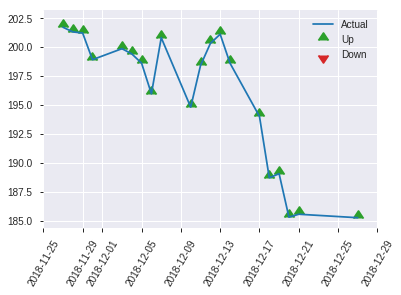


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.4859437751004016
RMSE: 0.6970966755769257
LogLoss: 16.783903388691524
Null degrees of freedom: 248
Residual degrees of freedom: -766
Null deviance: 344.9987988800806
Residual deviance: 171431.9332848079
AIC: 173461.9332848079
AUC: 0.5
pr_auc: 0.0
Gini: 0.0
Confusion Matrix (Act/Pred) for max f1 @ threshold = 1.0: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    121  1        (121.0/121.0)
1      0    128  0        (0.0/128.0)
Total  0    249  0.4859   (121.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       1            0.679045  0
max f2                       1            0.840999  0
max f0point5                 1            0.569395  0
max accuracy                 1            0.514056  0
max precision                1            0.514056  0
max recall                   1            1         0
max specificity              1            0         0
max absolute_mcc             1            0         0
max min_per_class_accuracy   1            0         0
max mean_per_class_accuracy  1            0.5       0

Gains/Lift Table: Avg response rate: 51.41 %, avg score: 100.00 %



group    cumulative_data_fraction    lower_threshold    lift    cumulative_lift    response_rate    score    cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain    cumulative_gain
--  -------  --------------------------  -----------------  ------  -----------------  ---------------  -------  --------------------------  ------------------  --------------  -------------------------  ------  -----------------
    1        1                           1                  1       1                  0.514056         1        0.514056                    1                   1               1                          0       0

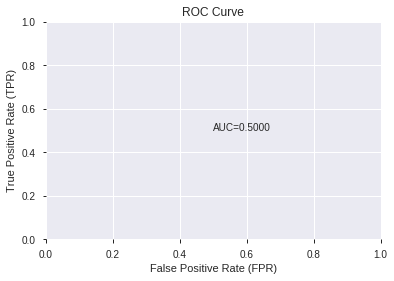

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


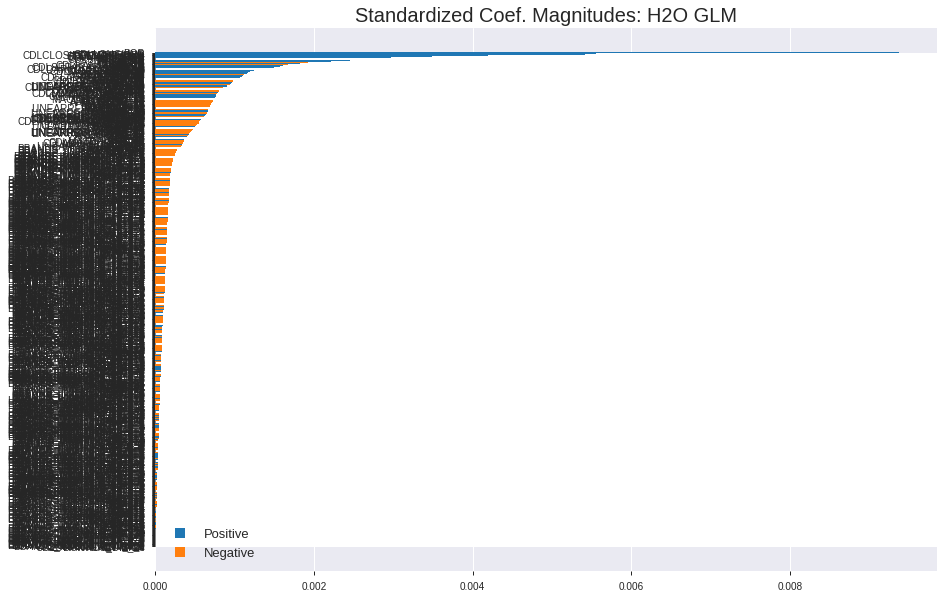

'log_likelihood'
--2019-08-27 21:37:15--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.95.179
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.95.179|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190827_213634_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190827_213634_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_8479',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

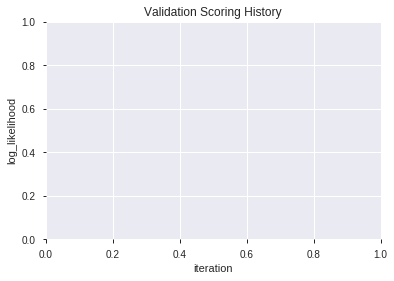

In [14]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [15]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [16]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [17]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_1_AutoML_20190827_213813  0.738314  0.601736              0.328093  0.454932  0.206963
1               XGBoost_2_AutoML_20190827_213813  0.733084  0.611831              0.382942  0.460622  0.212173
2               XGBoost_3_AutoML_20190827_213813  0.731147  0.610120              0.330417  0.459663  0.211290
3  XGBoost_grid_1_AutoML_20190827_213813_model_2  0.728951  0.612912              0.352660  0.460309  0.211884
4  XGBoost_grid_1_AutoML_20190827_213813_model_7  0.728306  0.610197              0.365057  0.460334  0.211908
5  XGBoost_grid_1_AutoML_20190827_213813_model_4  0.727466  0.612813              0.326737  0.460492  0.212053
6  XGBoost_grid_1_AutoML_20190827_213813_model_1  0.716878  0.607320              0.326511  0.459691  0.211316
7  XGBoost_grid_1_AutoML_20190827_213813_model_5  0.712164  0.621208              0.343944  0.465300  0.216504
8  XGBoost_grid_1_AutoML_20190827_213813_model_6  0.708742  0.622946              0.349948  0.466146  0.217292
9  XGBoost_grid_1_AutoML_20190827_213813_model_3  0.700736  0.624290              0.372417  0.467367  0.218432

variable  relative_importance  scaled_importance  percentage
0                        BOP          1915.919922           1.000000    0.180890
1               STOCHF_fastk           451.386749           0.235598    0.042617
2                        SUB           355.426300           0.185512    0.033557
3                     TRANGE           248.334091           0.129616    0.023446
4                        DIV           201.953445           0.105408    0.019067
..                       ...                  ...                ...         ...
302                   RSI_20             0.941025           0.000491    0.000089
303   LINEARREG_INTERCEPT_20             0.696987           0.000364    0.000066
304  BBANDS_lowerband_24_3_5             0.473900           0.000247    0.000045
305  BBANDS_upperband_14_5_2             0.286232           0.000149    0.000027
306  BBANDS_lowerband_20_2_4             0.271030           0.000141    0.000026

[307 rows x 4 columns]

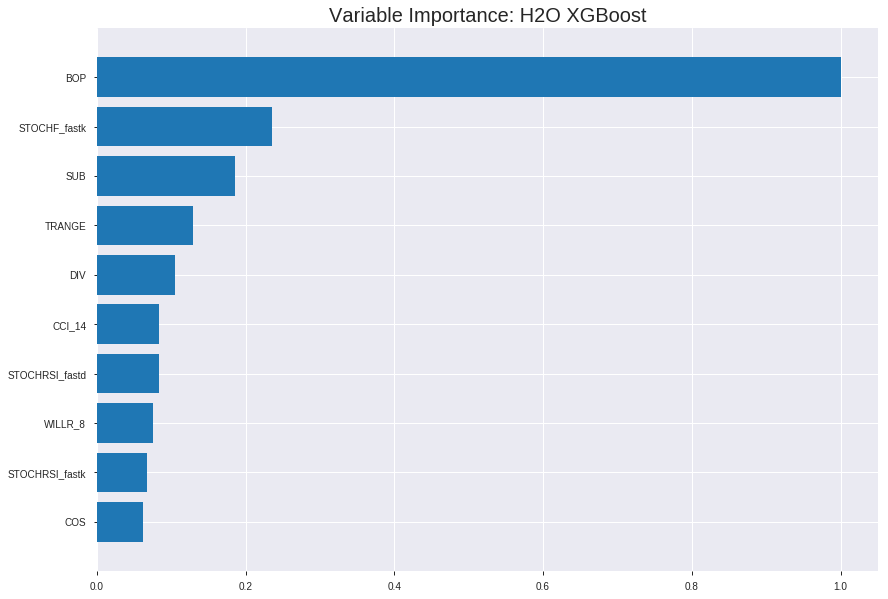

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_1_AutoML_20190827_213813


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.10247308047183755
RMSE: 0.32011416787114805
LogLoss: 0.3615319807902336
Mean Per-Class Error: 0.09205575373232922
AUC: 0.9713575108997226
pr_auc: 0.97305975242205
Gini: 0.9427150217994451
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5106036365032196: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      759  82   0.0975   (82.0/841.0)
1      81   819  0.09     (81.0/900.0)
Total  840  901  0.0936   (163.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.510604     0.909495  194
max f2                       0.390007     0.933575  248
max f0point5                 0.603423     0.933401  158
max accuracy                 0.52869      0.907524  187
max precision                0.945483     1         0
max recall                   0.204431     1         333
max specificity              0.945483     1         0
max absolute_mcc             0.52869      0.815423  187
max min_per_class_accuracy   0.513777     0.903686  193
max mean_per_class_accuracy  0.52869      0.907944  187

Gains/Lift Table: Avg response rate: 51.69 %, avg score: 51.51 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.905472           1.93444    1.93444            1                0.921096  1                           0.921096            0.02            0.02                       93.4444   93.4444
    2        0.0201034                   0.894073           1.93444    1.93444            1                0.898977  1                           0.910353            0.0188889       0.0388889                  93.4444   93.4444
    3        0.0304423                   0.88268            1.93444    1.93444            1                0.887686  1                           0.902655            0.02            0.0588889                  93.4444   93.4444
    4        0.0402068                   0.87521            1.93444    1.93444            1                0.87943   1                           0.897014            0.0188889       0.0777778                  93.4444   93.4444
    5        0.0505457                   0.869378           1.93444    1.93444            1                0.872086  1                           0.891915            0.02            0.0977778                  93.4444   93.4444
    6        0.100517                    0.840919           1.93444    1.93444            1                0.853639  1                           0.872887            0.0966667       0.194444                   93.4444   93.4444
    7        0.150488                    0.817456           1.93444    1.93444            1                0.828234  1                           0.858059            0.0966667       0.291111                   93.4444   93.4444
    8        0.20046                     0.786514           1.93444    1.93444            1                0.801349  1                           0.843922            0.0966667       0.387778                   93.4444   93.4444
    9        0.300402                    0.722012           1.92333    1.93075            0.994253         0.75578   0.998088                    0.814598            0.192222        0.58                       92.3327   93.0746
    10       0.400345                    0.641097           1.74545    1.88449            0.902299         0.683931  0.974175                    0.781978            0.174444        0.754444                   74.5447   88.4487
    11       0.500287                    0.528626           1.4008     1.78786            0.724138         0.588592  0.924225                    0.743345            0.14            0.894444                   40.0805   78.7862
    12       0.60023                     0.41843            0.66705    1.60124            0.344828         0.471759  0.827751                    0.698124            0.0666667       0.961111                   -33.295   60.1239
    13       0.700172                    0.325925           0.289055   1.41394            0.149425         0.370593  0.730927                    0.651372            0.0288889       0.99                       -71.0945  41.3938
    14       0.800115                    0.235648           0.08894    1.24843            0.045977         0.280056  0.64537                     0.604991            0.00888889      0.998889                   -91.106   24.8432
    15       0.900057                    0.152829           0.0111175  1.11104            0.00574713       0.19494   0.574346                    0.559459            0.00111111      1                          -98.8883  11.104
    16       1                           0.0515656          0          1                  0                0.115681  0.516944                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.20899253596904274
RMSE: 0.4571570145683458
LogLoss: 0.606326822982384
Mean Per-Class Error: 0.32607920663728285
AUC: 0.7320132227119522
pr_auc: 0.7294206735306984
Gini: 0.4640264454239045
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3552549481391907: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      93   139  0.5991   (139.0/232.0)
1      26   240  0.0977   (26.0/266.0)
Total  119  379  0.3313   (165.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.355255     0.744186  300
max f2                       0.163334     0.856959  391
max f0point5                 0.622656     0.705689  128
max accuracy                 0.406782     0.676707  268
max precision                0.87515      1         0
max recall                   0.163334     1         391
max specificity              0.87515      1         0
max absolute_mcc             0.622656     0.364921  128
max min_per_class_accuracy   0.524134     0.654135  200
max mean_per_class_accuracy  0.581041     0.673921  159

Gains/Lift Table: Avg response rate: 53.41 %, avg score: 51.42 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100402                   0.848297           1.87218   1.87218            1                0.867967  1                           0.867967            0.018797        0.018797                   87.218    87.218
    2        0.0200803                   0.836345           1.12331   1.49774            0.6              0.842184  0.8                         0.855075            0.0112782       0.0300752                  12.3308   49.7744
    3        0.0301205                   0.807677           1.12331   1.37293            0.6              0.82645   0.733333                    0.845533            0.0112782       0.0413534                  12.3308   37.2932
    4        0.0401606                   0.797113           1.49774   1.40414            0.8              0.804948  0.75                        0.835387            0.0150376       0.056391                   49.7744   40.4135
    5        0.0502008                   0.793176           1.87218   1.49774            1                0.795128  0.8                         0.827335            0.018797        0.075188                   87.218    49.7744
    6        0.100402                    0.757197           1.49774   1.49774            0.8              0.776237  0.8                         0.801786            0.075188        0.150376                   49.7744   49.7744
    7        0.150602                    0.736309           1.49774   1.49774            0.8              0.744725  0.8                         0.782766            0.075188        0.225564                   49.7744   49.7744
    8        0.200803                    0.699651           1.49774   1.49774            0.8              0.715751  0.8                         0.766012            0.075188        0.300752                   49.7744   49.7744
    9        0.301205                    0.646661           1.49774   1.49774            0.8              0.673522  0.8                         0.735182            0.150376        0.451128                   49.7744   49.7744
    10       0.399598                    0.583482           1.06982   1.39238            0.571429         0.613167  0.743719                    0.705138            0.105263        0.556391                   6.98174   39.2375
    11       0.5                         0.528845           0.93609   1.30075            0.5              0.554161  0.694779                    0.674821            0.093985        0.650376                   -6.39098  30.0752
    12       0.600402                    0.460958           0.973534  1.24603            0.52             0.500682  0.665552                    0.645701            0.0977444       0.74812                    -2.64662  24.6033
    13       0.698795                    0.402188           0.955194  1.20508            0.510204         0.431001  0.643678                    0.61547             0.093985        0.842105                   -4.48059  20.5082
    14       0.799197                    0.318831           0.748872  1.14777            0.4              0.363108  0.613065                    0.583767            0.075188        0.917293                   -25.1128  14.7769
    15       0.899598                    0.238082           0.449323  1.06982            0.24             0.280325  0.571429                    0.5499              0.0451128       0.962406                   -55.0677  6.98174
    16       1                           0.111703           0.374436  1                  0.2              0.194543  0.534137                    0.514222          


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 21:38:14  0.016 sec   0                  0.5              0.693147            0.5             0                  1                0.483056                         0.5                0.693147              0.5               0                    1                  0.465863
    2019-08-27 21:38:15  1.504 sec   5                  0.469763         0.634152            0.87006         0.874594           1.93444          0.215393                         0.487289           0.667932              0.700609          0.691531             1.49774            0.339357
    2019-08-27 21:38:15  1.831 sec   10                 0.443613         0.584794            0.898623        0.905754           1.93444          0.178633                         0.478963           0.651463              0.709457          0.698407             1.12331            0.333333
    2019-08-27 21:38:16  2.167 sec   15                 0.421565         0.543853            0.91395         0.92027            1.93444          0.164848                         0.47019            0.634112              0.726682          0.713097             1.12331            0.319277
    2019-08-27 21:38:16  2.499 sec   20                 0.405268         0.513577            0.920719        0.927774           1.93444          0.156232                         0.466618           0.627009              0.726998          0.710827             1.12331            0.317269
    2019-08-27 21:38:16  2.838 sec   25                 0.390796         0.486694            0.928886        0.934746           1.93444          0.147042                         0.463644           0.620831              0.727873          0.716161             1.49774            0.323293
    2019-08-27 21:38:17  3.176 sec   30                 0.377623         0.462418            0.936869        0.943537           1.93444          0.143596                         0.460669           0.614622              0.731373          0.722216             1.12331            0.321285
    2019-08-27 21:38:17  3.502 sec   35                 0.366105         0.441308            0.943872        0.950058           1.93444          0.132682                         0.459265           0.611354              0.729258          0.719042             1.49774            0.319277
    2019-08-27 21:38:17  3.864 sec   40                 0.355429         0.421808            0.949104        0.954563           1.93444          0.126364                         0.458817           0.610174              0.730239          0.71932              1.49774            0.333333
    2019-08-27 21:38:18  4.204 sec   45                 0.344777         0.403511            0.956908        0.960695           1.93444          0.110856                         0.458318           0.60879               0.730182          0.722507             1.87218            0.323293
    2019-08-27 21:38:18  4.513 sec   50                 0.336521         0.389116            0.961942        0.966201           1.93444          0.109707                         0.458114           0.608317              0.72989           0.723781             1.87218            0.323293
    2019-08-27 21:38:18  4.835 sec   55                 0.328567         0.375235            0.965906        0.969462           1.93444          0.106261                         0.457468           0.607013              0.731308          0

Variable Importances: 


variable                 relative_importance    scaled_importance       percentage
-----------------------  ---------------------  ----------------------  ----------------------
BOP                      1915.919921875         1.0                     0.18089031722686416
STOCHF_fastk             451.3867492675781      0.23559792041090738     0.04261738256111853
SUB                      355.4263000488281      0.1855120853386153      0.03355733996631921
TRANGE                   248.33409118652344     0.12961611200508485     0.023446299618312558
DIV                      201.9534454345703      0.10540808262849011     0.019067301504943086
---                      ---                    ---                     ---
RSI_20                   0.9410247802734375     0.0004911608097652176   8.88462346878337e-05
LINEARREG_INTERCEPT_20   0.6969871520996094     0.0003637872043302876   6.580558279437978e-05
BBANDS_lowerband_24_3_5  0.47389984130859375    0.0002473484595560838   4.474294131467618e-05
BBANDS_upperband_14_5_2  0.28623199462890625    0.00014939663780351925  2.7024405204905522e-05
BBANDS_lowerband_20_2_4  0.2710304260253906     0.00014146229335104403  2.5589159119910074e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7028112449799196)

('F1', 0.7452229299363058)

('auc', 0.7383135330578512)

('logloss', 0.6017356432370354)

('mean_per_class_error', 0.2990056818181819)

('rmse', 0.4549323088873083)

('mse', 0.20696340566953728)

xgboost prediction progress: |████████████████████████████████████████████| 100%


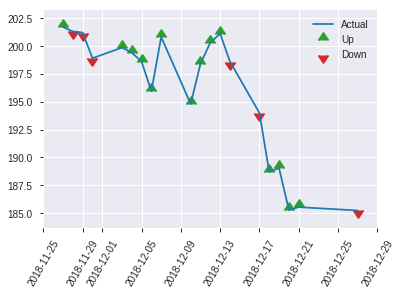


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.20696340566953728
RMSE: 0.4549323088873083
LogLoss: 0.6017356432370354
Mean Per-Class Error: 0.2990056818181819
AUC: 0.7383135330578512
pr_auc: 0.7206869606570337
Gini: 0.4766270661157024
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3378634750843048: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      52   69   0.5702   (69.0/121.0)
1      11   117  0.0859   (11.0/128.0)
Total  63   186  0.3213   (80.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.337863     0.745223  185
max f2                       0.194074     0.845638  232
max f0point5                 0.542048     0.706897  112
max accuracy                 0.46879      0.702811  141
max precision                0.881622     1         0
max recall                   0.158722     1         244
max specificity              0.881622     1         0
max absolute_mcc             0.46879      0.405859  141
max min_per_class_accuracy   0.518307     0.679688  124
max mean_per_class_accuracy  0.46879      0.700994  141

Gains/Lift Table: Avg response rate: 51.41 %, avg score: 49.68 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.820079           1.94531   1.94531            1                0.855025  1                           0.855025            0.0234375       0.0234375                  94.5313   94.5313
    2        0.0200803                   0.810149           0.972656  1.55625            0.5              0.810913  0.8                         0.83738             0.0078125       0.03125                    -2.73437  55.625
    3        0.0321285                   0.801483           1.94531   1.70215            1                0.80816   0.875                       0.826423            0.0234375       0.0546875                  94.5313   70.2148
    4        0.0401606                   0.793149           1.94531   1.75078            1                0.795366  0.9                         0.820211            0.015625        0.0703125                  94.5313   75.0781
    5        0.0522088                   0.791177           1.29688   1.64603            0.666667         0.79248   0.846154                    0.813812            0.015625        0.0859375                  29.6875   64.6034
    6        0.100402                    0.745681           1.45898   1.55625            0.75             0.769704  0.8                         0.79264             0.0703125       0.15625                    45.8984   55.625
    7        0.15261                     0.715559           1.49639   1.53577            0.769231         0.728483  0.789474                    0.770692            0.078125        0.234375                   49.6394   53.5773
    8        0.200803                    0.670806           1.45898   1.51734            0.75             0.694396  0.78                        0.752381            0.0703125       0.304688                   45.8984   51.7344
    9        0.301205                    0.613501           1.16719   1.40063            0.6              0.635897  0.72                        0.713553            0.117188        0.421875                   16.7188   40.0625
    10       0.401606                    0.569384           1.40063   1.40063            0.72             0.590551  0.72                        0.682802            0.140625        0.5625                     40.0625   40.0625
    11       0.502008                    0.518307           1.16719   1.35394            0.6              0.542935  0.696                       0.654829            0.117188        0.679688                   16.7188   35.3938
    12       0.598394                    0.451343           0.972656  1.29252            0.5              0.485911  0.66443                     0.627621            0.09375         0.773438                   -2.73437  29.2523
    13       0.698795                    0.385286           0.855938  1.2298             0.44             0.422615  0.632184                    0.598166            0.0859375       0.859375                   -14.4062  22.9795
    14       0.799197                    0.306366           0.700313  1.16328            0.36             0.339697  0.59799                     0.565695            0.0703125       0.929688                   -29.9688  16.3277
    15       0.899598                    0.225666           0.31125   1.06818            0.16             0.261443  0.549107                    0.531738            0.03125         0.960938                   -68.875   6.8185
    16       1                           0.138452           0.389063  1                  0.2              0.18365   0.514056                    0.49679             

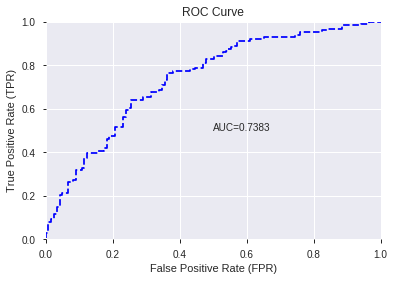

This function is available for GLM models only


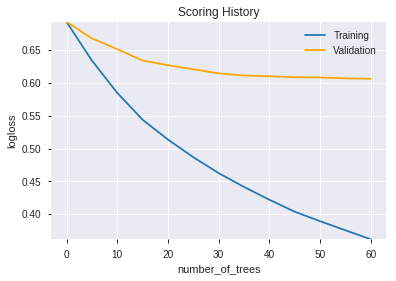

--2019-08-27 21:39:30--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.111.43
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.111.43|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_1_AutoML_20190827_213813',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_1_AutoML_20190827_213813',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_8479',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_42_sid_8479',
   'type

In [18]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190827_214027_model_5  0.719202  0.797978              0.356792  0.536760  0.288111
1  DeepLearning_grid_1_AutoML_20190827_214027_model_8  0.717975  0.629510              0.356566  0.469241  0.220188
2  DeepLearning_grid_1_AutoML_20190827_214027_model_6  0.714941  0.674603              0.340263  0.485293  0.235509
3  DeepLearning_grid_1_AutoML_20190827_214027_model_9  0.710292  0.694091              0.344396  0.494648  0.244676
4  DeepLearning_grid_1_AutoML_20190827_214027_model_7  0.707515  0.659643              0.383168  0.484298  0.234545
5  DeepLearning_grid_1_AutoML_20190827_214027_model_4  0.691890  0.961066              0.382942  0.547759  0.300040
6  DeepLearning_grid_1_AutoML_20190827_214027_model_3  0.649277  2.001089              0.397889  0.631370  0.398628
7  DeepLearning_grid_1_AutoML_20190827_214027_model_1  0.613507  1.414374              0.423586  0.583936  0.340982
8               DeepLearning_1_AutoML_20190827_214027  0.600852  0.892521              0.470848  0.566780  0.321240
9  DeepLearning_grid_1_AutoML_20190827_214027_model_2  0.595816  5.542736              0.445603  0.709302  0.503109

variable  relative_importance  scaled_importance  percentage
0                        BOP             1.000000           1.000000    0.040572
1                        DIV             0.667762           0.667762    0.027092
2                        SUB             0.653348           0.653348    0.026507
3         CDLCLOSINGMARUBOZU             0.638637           0.638637    0.025910
4                     TRANGE             0.585368           0.585368    0.023749
5                STOCH_slowd             0.551835           0.551835    0.022389
6               CDLENGULFING             0.549335           0.549335    0.022287
7               aroondown_24             0.546779           0.546779    0.022184
8               CDLSHORTLINE             0.544946           0.544946    0.022109
9                        COS             0.542465           0.542465    0.022009
10                aroonup_30             0.539000           0.539000    0.021868
11             days_in_month             0.538793           0.538793    0.021860
12              STOCHF_fastk             0.536046           0.536046    0.021748
13            STOCHRSI_fastk             0.528220           0.528220    0.021431
14                     month             0.518025           0.518025    0.021017
15                     ADOSC             0.504416           0.504416    0.020465
16                 aroonup_8             0.497961           0.497961    0.020203
17               CDLMARUBOZU             0.496230           0.496230    0.020133
18                   ROCR_12             0.485283           0.485283    0.019689
19               CDLLONGLINE             0.484936           0.484936    0.019675
20               CDLBELTHOLD             0.483498           0.483498    0.019616
21                   WILLR_8             0.481230           0.481230    0.019524
22   BBANDS_lowerband_30_1_5             0.478987           0.478987    0.019433
23                    CMO_20             0.478880           0.478880    0.019429
24                    SAREXT             0.478838           0.478838    0.019427
25                  WILLR_20             0.475295           0.475295    0.019283
26                     ROC_8             0.471939           0.471939    0.019147
27                     MFI_8             0.470166           0.470166    0.019075
28            MACDFIX_hist_8             0.453256           0.453256    0.018389
29                 CDLHARAMI             0.452919           0.452919    0.018376
30               CDLHIGHWAVE             0.448714           0.448714    0.018205
31              CDLTHRUSTING             0.444476           0.444476    0.018033
32  BBANDS_middleband_30_7_3             0.443594           0.443594    0.017997
33    BBANDS_upperband_8_8_3             0.442509           0.442509    0.017953
34   BBANDS_lowerband_24_3_3             0.438412           0.438412    0.017787
35   BBANDS_lowerband_20_6_2             0.430746           0.430746    0.017476
36                   TRIMA_8             0.429598           0.429598    0.017429
37                  MAVP_8_0             0.428038           0.428038    0.017366
38                  MAVP_8_8             0.427632           0.427632    0.017350
39                  SAR_0.14             0.427477           0.427477    0.017343
40  BBANDS_middleband_14_6_2             0.425076           0.425076    0.017246
41         LINEARREG_SLOPE_8             0.423954           0.423954    0.017200
42   BBANDS_lowerband_30_1_3             0.420820           0.420820    0.017073
43   BBANDS_lowerband_14_2_2             0.419769           0.419769    0.017031
44             MINMAX_max_30             0.418187           0.418187    0.016966
45    BBANDS_upperband_8_3_3             0.415829           0.415829    0.016871
46   BBANDS_upperband_24_0_2             0.411877           0.411877    0.016710
47            CDL3LINESTRIKE             0.411616           0.411616    0.016700
48            CDLEVENINGSTAR             0.406511  

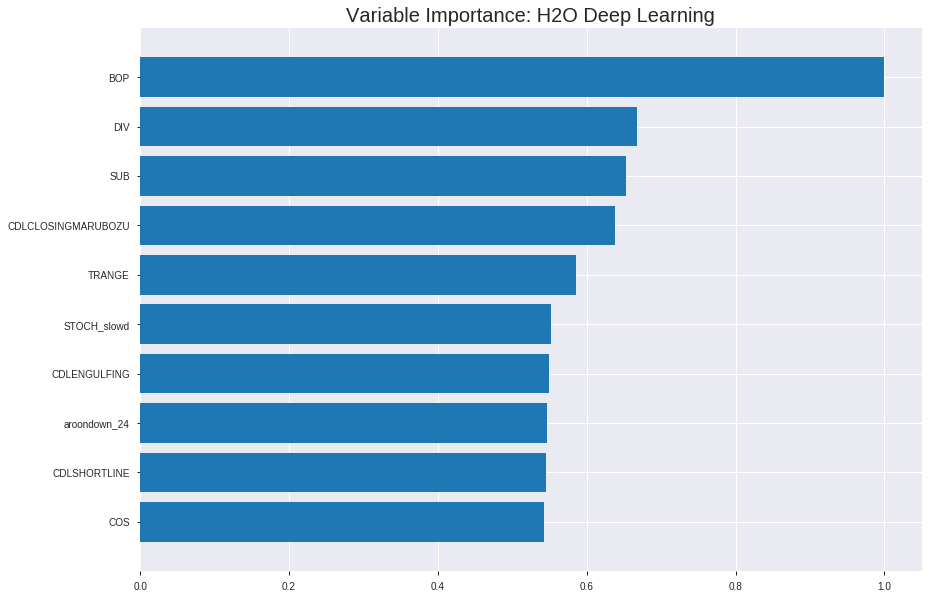

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190827_214027_model_5


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.1929084960383821
RMSE: 0.4392134971040645
LogLoss: 0.5644353717162027
Mean Per-Class Error: 0.29498678821508784
AUC: 0.7739721231338353
pr_auc: 0.7731642629288866
Gini: 0.5479442462676707
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4331396839633448: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      419  422   0.5018   (422.0/841.0)
1      114  786   0.1267   (114.0/900.0)
Total  533  1208  0.3079   (536.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.43314      0.745731  244
max f2                       0.204501     0.861193  330
max f0point5                 0.598594     0.71986   157
max accuracy                 0.520663     0.707065  202
max precision                0.984345     1         0
max recall                   0.0293371    1         391
max specificity              0.984345     1         0
max absolute_mcc             0.511066     0.414532  207
max min_per_class_accuracy   0.55335      0.69679   186
max mean_per_class_accuracy  0.520663     0.705013  202

Gains/Lift Table: Avg response rate: 51.69 %, avg score: 51.49 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.95019            1.93444   1.93444            1                0.963648   1                           0.963648            0.02            0.02                       93.4444   93.4444
    2        0.0201034                   0.92487            1.93444   1.93444            1                0.938215   1                           0.951295            0.0188889       0.0388889                  93.4444   93.4444
    3        0.0304423                   0.898203           1.82698   1.89795            0.944444         0.911819   0.981132                    0.937888            0.0188889       0.0577778                  82.6975   89.7945
    4        0.0402068                   0.885202           1.70686   1.85154            0.882353         0.889788   0.957143                    0.926207            0.0166667       0.0744444                  70.6863   85.154
    5        0.0505457                   0.866077           1.61204   1.80255            0.833333         0.877855   0.931818                    0.916316            0.0166667       0.0911111                  61.2037   80.2551
    6        0.100517                    0.782772           1.62315   1.71337            0.83908          0.819186   0.885714                    0.868029            0.0811111       0.172222                   62.3155   71.3365
    7        0.150488                    0.736696           1.44527   1.62434            0.747126         0.757702   0.839695                    0.831394            0.0722222       0.244444                   44.5275   62.4343
    8        0.20046                     0.692325           1.48974   1.59079            0.770115         0.711436   0.82235                     0.80149             0.0744444       0.318889                   48.9745   59.079
    9        0.300402                    0.641478           1.35633   1.51279            0.701149         0.663967   0.782027                    0.755737            0.135556        0.454444                   35.6335   51.2787
    10       0.400345                    0.598735           1.3341    1.46818            0.689655         0.619451   0.758967                    0.721714            0.133333        0.587778                   33.41     46.8179
    11       0.500287                    0.556393           1.04504   1.38365            0.54023          0.579421   0.71527                     0.693288            0.104444        0.692222                   4.50447   38.365
    12       0.60023                     0.497569           0.989457  1.31801            0.511494         0.52935    0.68134                     0.665991            0.0988889       0.791111                   -1.05428  31.8014
    13       0.700172                    0.428596           0.833812  1.2489             0.431034         0.464269   0.645611                    0.637197            0.0833333       0.874444                   -16.6188  24.8899
    14       0.800115                    0.316918           0.66705   1.17622            0.344828         0.376547   0.60804                     0.60464             0.0666667       0.941111                   -33.295   17.622
    15       0.900057                    0.154644           0.4447    1.09499            0.229885         0.234891   0.56605                     0.563583            0.0444444       0.985556                   -55.53    9.49918
    16       1                           0.00788123         0.144527  1                  0.0747126        0.0768596  0.516944                    0.5



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.23766562694222532
RMSE: 0.48750961728177766
LogLoss: 0.6689745738730614
Mean Per-Class Error: 0.29509657765102415
AUC: 0.7551367643246046
pr_auc: 0.723765500253905
Gini: 0.5102735286492093
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.26159628637218346: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      120  112  0.4828   (112.0/232.0)
1      35   231  0.1316   (35.0/266.0)
Total  155  343  0.2952   (147.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.261596     0.758621  266
max f2                       0.0728316    0.861619  372
max f0point5                 0.373097     0.726795  176
max accuracy                 0.325795     0.706827  215
max precision                0.750721     1         0
max recall                   0.0349495    1         389
max specificity              0.750721     1         0
max absolute_mcc             0.261596     0.415508  266
max min_per_class_accuracy   0.347771     0.695489  203
max mean_per_class_accuracy  0.325795     0.704903  215

Gains/Lift Table: Avg response rate: 53.41 %, avg score: 35.39 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100402                   0.724132           1.49774   1.49774            0.8              0.741055   0.8                         0.741055            0.0150376       0.0150376                  49.7744   49.7744
    2        0.0200803                   0.703234           1.12331   1.31053            0.6              0.718557   0.7                         0.729806            0.0112782       0.0263158                  12.3308   31.0526
    3        0.0301205                   0.685515           1.49774   1.37293            0.8              0.696998   0.733333                    0.71887             0.0150376       0.0413534                  49.7744   37.2932
    4        0.0401606                   0.671494           1.49774   1.40414            0.8              0.677218   0.75                        0.708457            0.0150376       0.056391                   49.7744   40.4135
    5        0.0502008                   0.658328           0.748872  1.27308            0.4              0.665561   0.68                        0.699878            0.0075188       0.0639098                  -25.1128  27.3083
    6        0.100402                    0.608725           1.42286   1.34797            0.76             0.629973   0.72                        0.664925            0.0714286       0.135338                   42.2857   34.797
    7        0.150602                    0.553914           1.64752   1.44782            0.88             0.580227   0.773333                    0.636693            0.0827068       0.218045                   64.7519   44.782
    8        0.200803                    0.500327           1.57263   1.47902            0.84             0.525152   0.79                        0.608807            0.0789474       0.296992                   57.2632   47.9023
    9        0.301205                    0.443261           1.4603    1.47278            0.78             0.474851   0.786667                    0.564155            0.146617        0.443609                   46.0301   47.2782
    10       0.399598                    0.396988           1.26086   1.4206             0.673469         0.420596   0.758794                    0.528807            0.12406         0.567669                   26.0856   42.0599
    11       0.5                         0.350109           1.12331   1.3609             0.6              0.371354   0.726908                    0.497189            0.112782        0.680451                   12.3308   36.0902
    12       0.600402                    0.297854           0.973534  1.29612            0.52             0.325226   0.692308                    0.468433            0.0977444       0.778195                   -2.64662  29.6125
    13       0.698795                    0.259317           0.916986  1.24274            0.489796         0.281205   0.663793                    0.44207             0.0902256       0.868421                   -8.30137  24.274
    14       0.799197                    0.198045           0.599098  1.16188            0.32             0.233898   0.620603                    0.415918            0.0601504       0.928571                   -40.0902  16.1881
    15       0.899598                    0.114064           0.41188   1.07818            0.22             0.153592   0.575893                    0.386641            0.0413534       0.969925                   -58.812   7.81753
    16       1                           0.00493084         0.299549  1                  0.16             0.0601064  0.534137                    0.


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 21:43:41  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-27 21:43:42  53.131 sec        1222 obs/sec      1         1             1741       0.482344         0.662006            0.0683086      0.675125        0.67644            1.71951          0.440551                         0.635576           1.19735               -0.623395        0.678264          0.666338             1.12331            0.391566
    2019-08-27 21:43:48  58.340 sec        2285 obs/sec      8         8             13928      0.439213         0.564435            0.227479       0.773972        0.773164           1.93444          0.307869                         0.48751            0.668975              0.0448855        0.755137          0.723766             1.49774            0.295181
    2019-08-27 21:43:53  1 min  3.878 sec  2656 obs/sec      17        17            29597      0.428467         0.538875            0.264819       0.79832         0.79955            1.93444          0.294658                         0.493213           0.682854              0.0224065        0.755518          0.718494             1.12331            0.301205
    2019-08-27 21:43:58  1 min  9.165 sec  2839 obs/sec      26        26            45266      0.422994         0.52512             0.283483       0.806087        0.811861           1.93444          0.281447                         0.552816           0.889259              -0.228146        0.761862          0.721418             0.748872           0.309237
    2019-08-27 21:44:04  1 min 14.382 sec  2949 obs/sec      35        35            60935      0.409707         0.496288            0.327789       0.829813        0.830486           1.93444          0.278001                         0.484342           0.68449               0.0572565        0.746411          0.709214             1.12331            0.303213
    2019-08-27 21:44:09  1 min 19.488 sec  3032 obs/sec      44        44            76604      0.398317         0.471982            0.364646       0.84732         0.843386           1.93444          0.24641                          0.488904           0.728813              0.039413         0.722752          0.704803             0.748872           0.337349
    2019-08-27 21:44:14  1 min 24.944 sec  3110 obs/sec      54        54            94014      0.387982         0.451374            0.397187       0.865417        0.8482             1.93444          0.236071                         0.510142           0.771871              -0.0458561       0.71367           0.701732             1.12331            0.379518
    2019-08-27 21:44:20  1 min 30.312 sec  3175 obs/sec      64        64            111424     0.374021         0.422908            0.43979        0.88283         0.862639           1.93444          0.216542                         0.500864           0.782201              -0.00815839      0.68114           0.672668             1.49774            0.405622
    2019-08-27 21:44:25

Variable Importances: 


variable                 relative_importance    scaled_importance    percentage
-----------------------  ---------------------  -------------------  --------------------
BOP                      1.0                    1.0                  0.04057152826073871
DIV                      0.6677623391151428     0.6677623391151428   0.027092138612867005
SUB                      0.6533480882644653     0.6533480882644653   0.02650733042712137
CDLCLOSINGMARUBOZU       0.6386368274688721     0.6386368274688721   0.02591047209400186
TRANGE                   0.5853677988052368     0.5853677988052368   0.02374926619215308
---                      ---                    ---                  ---
BBANDS_upperband_8_3_3   0.4158290922641754     0.4158290922641754   0.016870821768433318
BBANDS_upperband_24_0_2  0.4118766188621521     0.4118766188621521   0.016710463882103312
CDL3LINESTRIKE           0.41161611676216125    0.41161611676216125  0.016699894913791553
CDLEVENINGSTAR           0.40651094913482666    0.40651094913482666  0.016492770461123338
BBANDS_upperband_8_2_3   0.3985993564128876     0.3985993564128876   0.016171785053417733


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6666666666666666)

('F1', 0.7272727272727273)

('auc', 0.7192019628099173)

('logloss', 0.7979778673299787)

('mean_per_class_error', 0.3321280991735538)

('rmse', 0.5367597967652473)

('mse', 0.2881110794234696)

deeplearning prediction progress: |███████████████████████████████████████| 100%


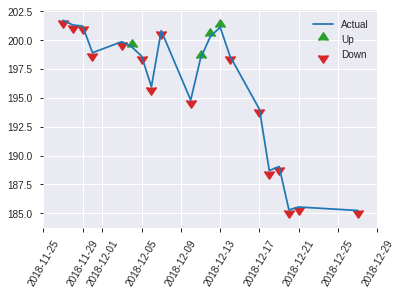


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2881110794234696
RMSE: 0.5367597967652473
LogLoss: 0.7979778673299787
Mean Per-Class Error: 0.3321280991735538
AUC: 0.7192019628099173
pr_auc: 0.7172613768556261
Gini: 0.43840392561983466
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.12177354312765118: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      46   75   0.6198   (75.0/121.0)
1      12   116  0.0938   (12.0/128.0)
Total  58   191  0.3494   (87.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.121774     0.727273  190
max f2                       0.0655478    0.859482  220
max f0point5                 0.248569     0.680272  114
max accuracy                 0.248569     0.666667  114
max precision                0.689553     1         0
max recall                   0.0481769    1         233
max specificity              0.689553     1         0
max absolute_mcc             0.121774     0.338659  190
max min_per_class_accuracy   0.23045      0.644628  125
max mean_per_class_accuracy  0.248569     0.667872  114

Gains/Lift Table: Avg response rate: 51.41 %, avg score: 24.56 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.627359           1.94531   1.94531            1                0.682555   1                           0.682555            0.0234375       0.0234375                  94.5313   94.5313
    2        0.0200803                   0.56848            1.94531   1.94531            1                0.577348   1                           0.640472            0.015625        0.0390625                  94.5313   94.5313
    3        0.0321285                   0.535762           1.29688   1.70215            0.666667         0.549066   0.875                       0.606195            0.015625        0.0546875                  29.6875   70.2148
    4        0.0401606                   0.514907           0.972656  1.55625            0.5              0.53127    0.8                         0.59121             0.0078125       0.0625                     -2.73437  55.625
    5        0.0522088                   0.497491           1.29688   1.49639            0.666667         0.505381   0.769231                    0.571403            0.015625        0.078125                   29.6875   49.6394
    6        0.100402                    0.425304           1.7832    1.63406            0.916667         0.454212   0.84                        0.515151            0.0859375       0.164062                   78.3203   63.4063
    7        0.15261                     0.390625           1.64603   1.63816            0.846154         0.403857   0.842105                    0.477077            0.0859375       0.25                       64.6034   63.8158
    8        0.200803                    0.362122           1.29688   1.55625            0.666667         0.377144   0.8                         0.453093            0.0625          0.3125                     29.6875   55.625
    9        0.301205                    0.329194           1.16719   1.42656            0.6              0.340775   0.733333                    0.415654            0.117188        0.429688                   16.7188   42.6562
    10       0.401606                    0.279909           1.08938   1.34227            0.56             0.309489   0.69                        0.389113            0.109375        0.539062                   8.9375    34.2266
    11       0.502008                    0.235187           1.01156   1.27613            0.52             0.254525   0.656                       0.362195            0.101562        0.640625                   1.15625   27.6125
    12       0.598394                    0.188902           0.891602  1.21419            0.458333         0.214965   0.624161                    0.33848             0.0859375       0.726562                   -10.8398  21.4188
    13       0.698795                    0.156556           0.855938  1.16272            0.44             0.172875   0.597701                    0.314686            0.0859375       0.8125                     -14.4062  16.2716
    14       0.799197                    0.108292           1.08938   1.1535             0.56             0.132274   0.592965                    0.29177             0.109375        0.921875                   8.9375    15.3502
    15       0.899598                    0.0611146          0.6225    1.09424            0.32             0.0856092  0.5625                      0.268761            0.0625          0.984375                   -37.75    9.42383
    16       1                           0.00197416         0.155625  1                  0.08             0.0385319  0.514056                    0

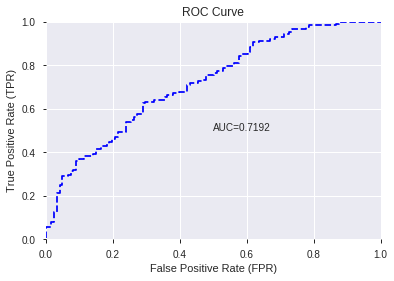

This function is available for GLM models only


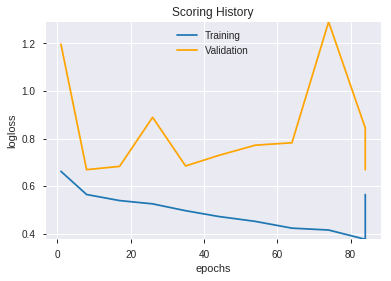

--2019-08-27 21:48:23--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.113.99
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.113.99|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190827_214027_model_5',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190827_214027_model_5',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_8479',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'DIV',
 'SUB',
 'CDLCLOSINGMARUBOZU',
 'TRANGE',
 'STOCH_slowd',
 'CDLENGULFING',
 'aroondown_24',
 'CDLSHORTLINE',
 'COS',
 'aroonup_30',
 'days_in_month',
 'STOCHF_fastk',
 'STOCHRSI_fastk',
 'month',
 'ADOSC',
 'aroonup_8',
 'CDLMARUBOZU',
 'ROCR_12',
 'CDLLONGLINE',
 'CDLBELTHOLD',
 'WILLR_8',
 'BBANDS_lowerband_30_1_5',
 'CMO_20',
 'SAREXT',
 'WILLR_20',
 'ROC_8',
 'MFI_8',
 'MACDFIX_hist_8',
 'CDLHARAMI',
 'CDLHIGHWAVE',
 'CDLTHRUSTING',
 'BBANDS_middleband_30_7_3',
 'BBANDS_upperband_8_8_3',
 'BBANDS_lowerband_24_3_3',
 'BBANDS_lowerband_20_6_2',
 'TRIMA_8',
 'MAVP_8_0',
 'MAVP_8_8',
 'SAR_0.14',
 'BBANDS_middleband_14_6_2',
 'LINEARREG_SLOPE_8',
 'BBANDS_lowerband_30_1_3',
 'BBANDS_lowerband_14_2_2',
 'MINMAX_max_30',
 'BBANDS_upperband_8_3_3',
 'BBANDS_upperband_24_0_2',
 'CDL3LINESTRIKE',
 'CDLEVENINGSTAR',
 'BBANDS_upperband_8_2_3']

In [19]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse      mse
0  GLM_grid_1_AutoML_20190827_214919_model_1  0.717265  0.723318              0.337939  0.505104  0.25513

variable  relative_importance  scaled_importance  percentage
0                        BOP             0.803023           1.000000    0.154677
1                   SAR_0.14             0.361608           0.450308    0.069653
2                   WILLR_20             0.264394           0.329249    0.050927
3                STOCH_slowd             0.232196           0.289153    0.044725
4                        DIV             0.227345           0.283112    0.043791
5                    ROCR_12             0.207642           0.258576    0.039996
6                        SUB             0.205075           0.255379    0.039501
7                      ADOSC             0.179322           0.223308    0.034541
8         CDLCLOSINGMARUBOZU             0.162546           0.202418    0.031310
9    BBANDS_lowerband_14_2_2             0.144473           0.179911    0.027828
10                 aroonup_8             0.140355           0.174783    0.027035
11              CDLENGULFING             0.134828           0.167901    0.025971
12         LINEARREG_SLOPE_8             0.132359           0.164826    0.025495
13              aroondown_24             0.127320           0.158551    0.024524
14              STOCHF_fastk             0.123304           0.153550    0.023751
15            STOCHRSI_fastk             0.116691           0.145314    0.022477
16    BBANDS_upperband_8_3_3             0.102888           0.128126    0.019818
17                       COS             0.101036           0.125819    0.019461
18                  MAVP_8_0             0.096406           0.120053    0.018570
19   BBANDS_lowerband_24_3_3             0.093947           0.116992    0.018096
20    BBANDS_upperband_8_2_3             0.075126           0.093554    0.014471
21              CDLTHRUSTING             0.074861           0.093223    0.014420
22             MINMAX_max_30             0.073619           0.091677    0.014180
23               CDLMARUBOZU             0.072412           0.090174    0.013948
24                  MAVP_8_8             0.066339           0.082611    0.012778
25                    CMO_20             0.065367           0.081402    0.012591
26    BBANDS_upperband_8_8_3             0.063048           0.078513    0.012144
27                   WILLR_8             0.059596           0.074214    0.011479
28                aroonup_30             0.059175           0.073690    0.011398
29   BBANDS_upperband_24_0_2             0.053869           0.067082    0.010376
30                    SAREXT             0.052779           0.065725    0.010166
31             days_in_month             0.050096           0.062384    0.009649
32               CDLLONGLINE             0.047823           0.059553    0.009212
33               CDLBELTHOLD             0.041014           0.051074    0.007900
34            CDLEVENINGSTAR             0.038229           0.047606    0.007364
35            MACDFIX_hist_8             0.037290           0.046437    0.007183
36                     ROC_8             0.035297           0.043955    0.006799
37                   TRIMA_8             0.033731           0.042005    0.006497
38  BBANDS_middleband_14_6_2             0.032104           0.039979    0.006184
39   BBANDS_lowerband_20_6_2             0.031811           0.039614    0.006127
40              CDLSHORTLINE             0.029960           0.037308    0.005771
41   BBANDS_lowerband_30_1_3             0.027125           0.033778    0.005225
42  BBANDS_middleband_30_7_3             0.026118           0.032525    0.005031
43                    TRANGE             0.022280           0.027746    0.004292
44   BBANDS_lowerband_30_1_5             0.020130           0.025068    0.003877
45                     month             0.019825           0.024688    0.003819
46                 CDLHARAMI             0.011294           0.014064    0.002175
47            CDL3LINESTRIKE             0.009284           0.011562    0.001788
48               CDLHIGHWAVE             0.004603  

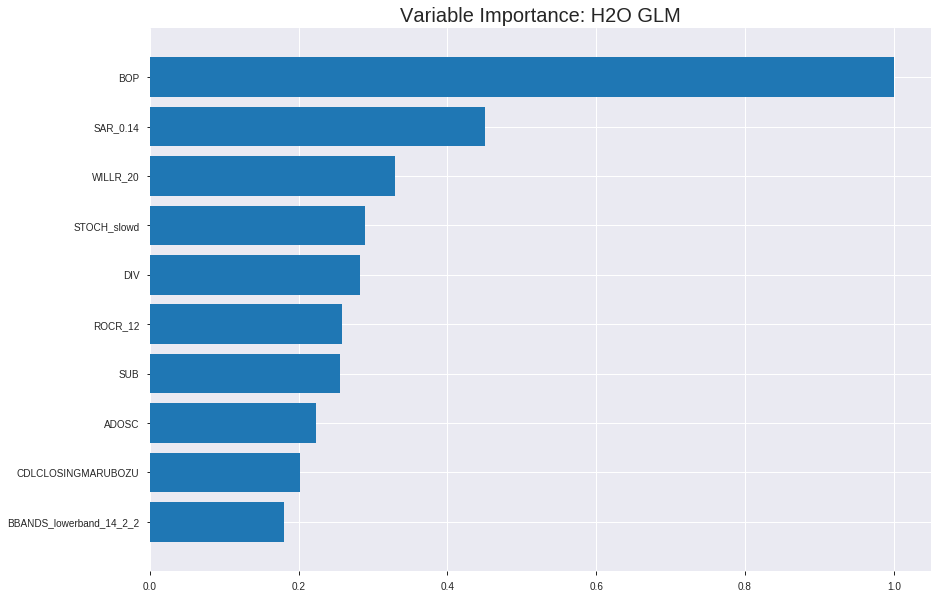

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190827_214919_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.19365308253656346
RMSE: 0.4400603169300357
LogLoss: 0.5684548171305845
Null degrees of freedom: 1740
Residual degrees of freedom: 1690
Null deviance: 2411.5386742145683
Residual deviance: 1979.3596732486953
AIC: 2081.3596732486953
AUC: 0.7721178491214162
pr_auc: 0.7691003126050332
Gini: 0.5442356982428325
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.34517754350775504: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      367  474   0.5636   (474.0/841.0)
1      89   811   0.0989   (89.0/900.0)
Total  456  1285  0.3234   (563.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.345178     0.742334  274
max f2                       0.15273      0.854267  357
max f0point5                 0.561489     0.716522  172
max accuracy                 0.498551     0.707639  204
max precision                0.965021     1         0
max recall                   0.0702809    1         386
max specificity              0.965021     1         0
max absolute_mcc             0.49505      0.414285  205
max min_per_class_accuracy   0.531        0.697778  188
max mean_per_class_accuracy  0.498551     0.706114  204

Gains/Lift Table: Avg response rate: 51.69 %, avg score: 51.69 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.929815           1.93444   1.93444            1                0.945612  1                           0.945612            0.02            0.02                       93.4444   93.4444
    2        0.0201034                   0.907588           1.70686   1.8239             0.882353         0.9184    0.942857                    0.932395            0.0166667       0.0366667                  70.6863   82.3905
    3        0.0304423                   0.884878           1.71951   1.78845            0.888889         0.896216  0.924528                    0.920108            0.0177778       0.0544444                  71.9506   78.8449
    4        0.0402068                   0.870342           1.59307   1.741              0.823529         0.876545  0.9                         0.909528            0.0155556       0.07                       59.3072   74.1
    5        0.0505457                   0.854205           1.93444   1.78057            1                0.861161  0.920455                    0.899635            0.02            0.09                       93.4444   78.0568
    6        0.100517                    0.805796           1.62315   1.70231            0.83908          0.831002  0.88                        0.865515            0.0811111       0.171111                   62.3155   70.2311
    7        0.150488                    0.765857           1.44527   1.61696            0.747126         0.784238  0.835878                    0.838526            0.0722222       0.243333                   44.5275   61.6959
    8        0.20046                     0.736302           1.35633   1.55199            0.701149         0.750436  0.802292                    0.816566            0.0677778       0.311111                   35.6335   55.199
    9        0.300402                    0.678396           1.47863   1.52758            0.764368         0.706394  0.789675                    0.779913            0.147778        0.458889                   47.8627   52.7582
    10       0.400345                    0.616381           1.21181   1.44875            0.626437         0.648657  0.748924                    0.747146            0.121111        0.58                       21.1807   44.8752
    11       0.500287                    0.532849           1.12287   1.38365            0.58046          0.574541  0.71527                     0.712664            0.112222        0.692222                   12.2867   38.365
    12       0.60023                     0.454197           0.989457  1.31801            0.511494         0.495799  0.68134                     0.676555            0.0988889       0.791111                   -1.05428  31.8014
    13       0.700172                    0.377665           0.767107  1.23938            0.396552         0.415901  0.640689                    0.639349            0.0766667       0.867778                   -23.2893  23.9377
    14       0.800115                    0.289413           0.71152   1.17344            0.367816         0.334169  0.606604                    0.601229            0.0711111       0.938889                   -28.848   17.3443
    15       0.900057                    0.187756           0.40023   1.08758            0.206897         0.24053   0.562221                    0.561177            0.04            0.978889                   -59.977   8.75849
    16       1                           0.0125379          0.211232  1                  0.109195         0.118598  0.516944                    0.516944            0.



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.20850894718291
RMSE: 0.4566277993978356
LogLoss: 0.6065116865808649
Null degrees of freedom: 497
Residual degrees of freedom: 447
Null deviance: 688.6415356931332
Residual deviance: 604.0856398345416
AIC: 706.0856398345416
AUC: 0.762615050557428
pr_auc: 0.7303325534124353
Gini: 0.5252301011148559
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.25735765286420637: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      103  129  0.556    (129.0/232.0)
1      21   245  0.0789   (21.0/266.0)
Total  124  374  0.3012   (150.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.257358     0.765625  296
max f2                       0.157632     0.868687  336
max f0point5                 0.433447     0.736926  201
max accuracy                 0.350211     0.714859  251
max precision                0.938324     1         0
max recall                   0.0374026    1         389
max specificity              0.938324     1         0
max absolute_mcc             0.331746     0.430671  260
max min_per_class_accuracy   0.42063      0.711207  207
max mean_per_class_accuracy  0.433447     0.713848  201

Gains/Lift Table: Avg response rate: 53.41 %, avg score: 43.37 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100402                   0.891395           1.12331   1.12331            0.6              0.91955    0.6                         0.91955             0.0112782       0.0112782                  12.3308   12.3308
    2        0.0200803                   0.866686           1.87218   1.49774            1                0.882959   0.8                         0.901254            0.018797        0.0300752                  87.218    49.7744
    3        0.0301205                   0.845478           1.49774   1.49774            0.8              0.854243   0.8                         0.885584            0.0150376       0.0451128                  49.7744   49.7744
    4        0.0401606                   0.832229           1.12331   1.40414            0.6              0.840518   0.75                        0.874317            0.0112782       0.056391                   12.3308   40.4135
    5        0.0502008                   0.806046           0.748872  1.27308            0.4              0.822826   0.68                        0.864019            0.0075188       0.0639098                  -25.1128  27.3083
    6        0.100402                    0.736563           1.64752   1.4603             0.88             0.766593   0.78                        0.815306            0.0827068       0.146617                   64.7519   46.0301
    7        0.150602                    0.695537           1.34797   1.42286            0.72             0.71865    0.76                        0.783087            0.0676692       0.214286                   34.797    42.2857
    8        0.200803                    0.658342           1.49774   1.44158            0.8              0.676008   0.77                        0.756318            0.075188        0.289474                   49.7744   44.1579
    9        0.301205                    0.579991           1.42286   1.43534            0.76             0.620709   0.766667                    0.711115            0.142857        0.432331                   42.2857   43.5338
    10       0.399598                    0.506979           1.33727   1.41119            0.714286         0.541523   0.753769                    0.669356            0.131579        0.56391                    33.7272   41.1191
    11       0.5                         0.431004           1.34797   1.3985             0.72             0.469596   0.746988                    0.629244            0.135338        0.699248                   34.797    39.8496
    12       0.600402                    0.367311           0.861203  1.30865            0.46             0.398149   0.698997                    0.590599            0.0864662       0.785714                   -13.8797  30.8648
    13       0.698795                    0.292507           0.916986  1.2535             0.489796         0.331417   0.66954                     0.554105            0.0902256       0.87594                    -8.30137  25.35
    14       0.799197                    0.199056           0.636541  1.17599            0.34             0.254873   0.628141                    0.516513            0.0639098       0.93985                    -36.3459  17.5993
    15       0.899598                    0.0963583          0.449323  1.09489            0.24             0.151256   0.584821                    0.475748            0.0451128       0.984962                   -55.0677  9.48912
    16       1                           0.00515779         0.149774  1                  0.08             0.0574125  0.534137                    0


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-27 21:49:20  0.000 sec   2            .21E2     51            1.3690942727759043  1.3652769862472427
     2019-08-27 21:49:20  0.008 sec   4            .13E2     51            1.3605664656133625  1.3566458546800173
     2019-08-27 21:49:20  0.016 sec   6            .82E1     51            1.3483949463054479  1.344875089557043
     2019-08-27 21:49:20  0.023 sec   8            .51E1     51            1.331897923067482   1.3295891395115116
     2019-08-27 21:49:20  0.032 sec   10           .32E1     51            1.310948707383916   1.3108679613822816
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-27 21:49:20  0.162 sec   38           .4E-2     51            1.1349275814422066  1.2136335762907062
     2019-08-27 21:49:20  0.174 sec   40           .25E-2    51            1.1328020535397973  1.215555311149472
     2019-08-27 21:49:20  0.185 sec   42           .15E-2    51            1.1303592005792316  1.2196376410623546
     2019-08-27 21:49:20  0.195 sec   44           .96E-3    51            1.1276028044299948  1.226988537126098
     2019-08-27 21:49:20  0.205 sec   46           .6E-3     51            1.1247402757103706  1.238766280891008


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6746987951807228)

('F1', 0.7515151515151515)

('auc', 0.7172649793388429)

('logloss', 0.7233176092315987)

('mean_per_class_error', 0.3319989669421488)

('rmse', 0.5051042635978509)

('mse', 0.2551303171047273)

glm prediction progress: |████████████████████████████████████████████████| 100%


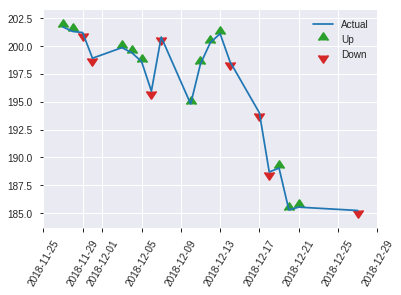


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2551303171047273
RMSE: 0.5051042635978509
LogLoss: 0.7233176092315987
Null degrees of freedom: 248
Residual degrees of freedom: 198
Null deviance: 344.9987988800806
Residual deviance: 360.2121693973361
AIC: 462.2121693973361
AUC: 0.7172649793388429
pr_auc: 0.6981278285023028
Gini: 0.43452995867768585
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.11293378369904025: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      43   78   0.6446   (78.0/121.0)
1      4    124  0.0312   (4.0/128.0)
Total  47   202  0.3293   (82.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.112934     0.751515  201
max f2                       0.112934     0.868347  201
max f0point5                 0.143266     0.668203  184
max accuracy                 0.143266     0.674699  184
max precision                0.901562     1         0
max recall                   0.027629     1         239
max specificity              0.901562     1         0
max absolute_mcc             0.112934     0.413982  201
max min_per_class_accuracy   0.298188     0.648438  124
max mean_per_class_accuracy  0.143266     0.668001  184

Gains/Lift Table: Avg response rate: 51.41 %, avg score: 32.02 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.839677           1.94531   1.94531            1                0.865235   1                           0.865235            0.0234375       0.0234375                  94.5313   94.5313
    2        0.0200803                   0.831362           0.972656  1.55625            0.5              0.831912   0.8                         0.851906            0.0078125       0.03125                    -2.73437  55.625
    3        0.0321285                   0.718549           1.29688   1.45898            0.666667         0.770945   0.75                        0.821545            0.015625        0.046875                   29.6875   45.8984
    4        0.0401606                   0.701311           1.94531   1.55625            1                0.71561    0.8                         0.800358            0.015625        0.0625                     94.5313   55.625
    5        0.0522088                   0.686104           1.29688   1.49639            0.666667         0.694946   0.769231                    0.776032            0.015625        0.078125                   29.6875   49.6394
    6        0.100402                    0.622225           1.62109   1.55625            0.833333         0.650493   0.8                         0.715774            0.078125        0.15625                    62.1094   55.625
    7        0.15261                     0.558001           1.49639   1.53577            0.769231         0.592997   0.789474                    0.673771            0.078125        0.234375                   49.6394   53.5773
    8        0.200803                    0.521243           1.7832    1.59516            0.916667         0.539922   0.82                        0.641647            0.0859375       0.320312                   78.3203   59.5156
    9        0.301205                    0.434947           1.01156   1.40063            0.52             0.472007   0.72                        0.585101            0.101562        0.421875                   1.15625   40.0625
    10       0.401606                    0.355544           1.08938   1.32281            0.56             0.395292   0.68                        0.537649            0.109375        0.53125                    8.9375    32.2813
    11       0.502008                    0.298188           1.16719   1.29169            0.6              0.323884   0.664                       0.494896            0.117188        0.648438                   16.7188   29.1688
    12       0.598394                    0.229694           0.891602  1.22724            0.458333         0.267405   0.630872                    0.458253            0.0859375       0.734375                   -10.8398  22.7244
    13       0.698795                    0.168974           0.93375   1.18508            0.48             0.194414   0.609195                    0.420345            0.09375         0.828125                   -6.625    18.5075
    14       0.799197                    0.113831           1.245     1.1926             0.64             0.138115   0.613065                    0.384889            0.125           0.953125                   24.5      19.2604
    15       0.899598                    0.0667124          0.155625  1.07687            0.08             0.0898721  0.553571                    0.351963            0.015625        0.96875                    -84.4375  7.68694
    16       1                           0.00122236         0.31125   1                  0.16             0.0356747  0.514056                    0.

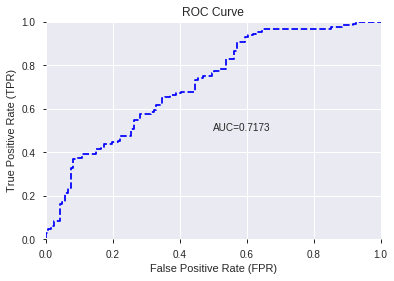

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


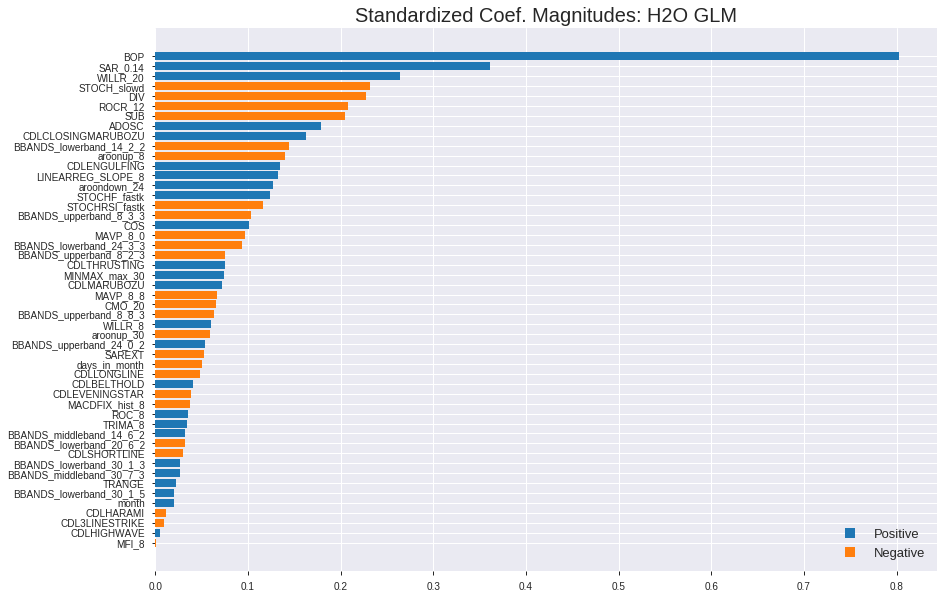

'log_likelihood'
--2019-08-27 21:49:30--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.107.164
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.107.164|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190827_214919_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190827_214919_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_8479',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['BOP',
 'SAR_0.14',
 'WILLR_20',
 'STOCH_slowd',
 'DIV',
 'ROCR_12',
 'SUB',
 'ADOSC',
 'CDLCLOSINGMARUBOZU',
 'BBANDS_lowerband_14_2_2',
 'aroonup_8',
 'CDLENGULFING',
 'LINEARREG_SLOPE_8',
 'aroondown_24',
 'STOCHF_fastk',
 'STOCHRSI_fastk',
 'BBANDS_upperband_8_3_3',
 'COS',
 'MAVP_8_0',
 'BBANDS_lowerband_24_3_3',
 'BBANDS_upperband_8_2_3',
 'CDLTHRUSTING',
 'MINMAX_max_30',
 'CDLMARUBOZU',
 'MAVP_8_8',
 'CMO_20',
 'BBANDS_upperband_8_8_3',
 'WILLR_8',
 'aroonup_30',
 'BBANDS_upperband_24_0_2',
 'SAREXT',
 'days_in_month',
 'CDLLONGLINE',
 'CDLBELTHOLD',
 'CDLEVENINGSTAR',
 'MACDFIX_hist_8',
 'ROC_8',
 'TRIMA_8',
 'BBANDS_middleband_14_6_2',
 'BBANDS_lowerband_20_6_2',
 'CDLSHORTLINE',
 'BBANDS_lowerband_30_1_3',
 'BBANDS_middleband_30_7_3',
 'TRANGE',
 'BBANDS_lowerband_30_1_5',
 'month',
 'CDLHARAMI',
 'CDL3LINESTRIKE',
 'CDLHIGHWAVE',
 'MFI_8']

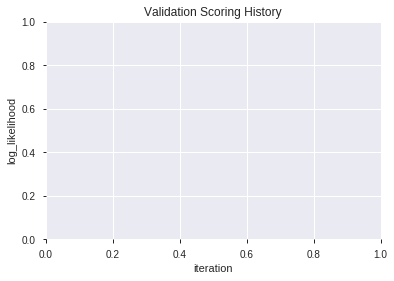

In [20]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_1_AutoML_20190827_215026  0.725142  0.618206              0.403603  0.463096  0.214458
1  XGBoost_grid_1_AutoML_20190827_215026_model_4  0.723270  0.615497              0.317794  0.462174  0.213605
2  XGBoost_grid_1_AutoML_20190827_215026_model_1  0.719848  0.611116              0.339134  0.460670  0.212217
3               XGBoost_3_AutoML_20190827_215026  0.718879  0.616423              0.325381  0.462400  0.213814
4               XGBoost_2_AutoML_20190827_215026  0.714618  0.622704              0.368963  0.465591  0.216775
5  XGBoost_grid_1_AutoML_20190827_215026_model_6  0.714230  0.618837              0.378809  0.463652  0.214973
6  XGBoost_grid_1_AutoML_20190827_215026_model_3  0.709388  0.624202              0.377228  0.465883  0.217047
7  XGBoost_grid_1_AutoML_20190827_215026_model_2  0.702350  0.633404              0.373321  0.470307  0.221188
8  XGBoost_grid_1_AutoML_20190827_215026_model_5  0.700930  0.627839              0.373547  0.468022  0.219044
9  XGBoost_grid_1_AutoML_20190827_215026_model_7  0.698218  0.631485              0.352208  0.470564  0.221431

variable  relative_importance  scaled_importance  percentage
0                        BOP          2209.006348           1.000000    0.243619
1                        SUB           566.156616           0.256295    0.062438
2               STOCHF_fastk           495.736633           0.224416    0.054672
3                        DIV           485.882843           0.219955    0.053585
4                     TRANGE           329.820587           0.149307    0.036374
5                STOCH_slowd           327.457642           0.148238    0.036113
6                   WILLR_20           296.979645           0.134440    0.032752
7             STOCHRSI_fastk           292.236481           0.132293    0.032229
8                      ADOSC           288.185364           0.130459    0.031782
9                    ROCR_12           276.509705           0.125174    0.030495
10                aroonup_30           258.539307           0.117039    0.028513
11                     MFI_8           257.608063           0.116617    0.028410
12                       COS           244.894089           0.110862    0.027008
13                   WILLR_8           239.861435           0.108583    0.026453
14            MACDFIX_hist_8           236.689819           0.107148    0.026103
15                     ROC_8           228.501556           0.103441    0.025200
16                    SAREXT           189.926056           0.085978    0.020946
17         LINEARREG_SLOPE_8           175.385315           0.079396    0.019342
18              aroondown_24           158.364044           0.071690    0.017465
19                 aroonup_8           147.197327           0.066635    0.016234
20                    CMO_20           137.112183           0.062070    0.015121
21   BBANDS_lowerband_30_1_5           118.079361           0.053454    0.013022
22                     month            99.365417           0.044982    0.010958
23   BBANDS_upperband_24_0_2            96.962090           0.043894    0.010693
24   BBANDS_lowerband_30_1_3            96.214279           0.043555    0.010611
25               CDLBELTHOLD            84.614662           0.038304    0.009332
26    BBANDS_upperband_8_2_3            77.334282           0.035009    0.008529
27    BBANDS_upperband_8_3_3            57.918880           0.026219    0.006388
28   BBANDS_lowerband_20_6_2            56.378735           0.025522    0.006218
29    BBANDS_upperband_8_8_3            56.288799           0.025482    0.006208
30  BBANDS_middleband_14_6_2            55.456688           0.025105    0.006116
31                  SAR_0.14            53.325470           0.024140    0.005881
32                   TRIMA_8            51.985466           0.023533    0.005733
33   BBANDS_lowerband_24_3_3            49.998337           0.022634    0.005514
34              CDLSHORTLINE            48.985767           0.022175    0.005402
35                  MAVP_8_0            44.034489           0.019934    0.004856
36        CDLCLOSINGMARUBOZU            41.873619           0.018956    0.004618
37   BBANDS_lowerband_14_2_2            37.416637           0.016938    0.004126
38             days_in_month            35.810055           0.016211    0.003949
39                  MAVP_8_8            26.583416           0.012034    0.002932
40             MINMAX_max_30            13.515503           0.006118    0.001491
41               CDLLONGLINE             8.813705           0.003990    0.000972
42                 CDLHARAMI             5.881460           0.002662    0.000649
43  BBANDS_middleband_30_7_3             5.358531           0.002426    0.000591
44              CDLENGULFING             3.232578           0.001463    0.000357

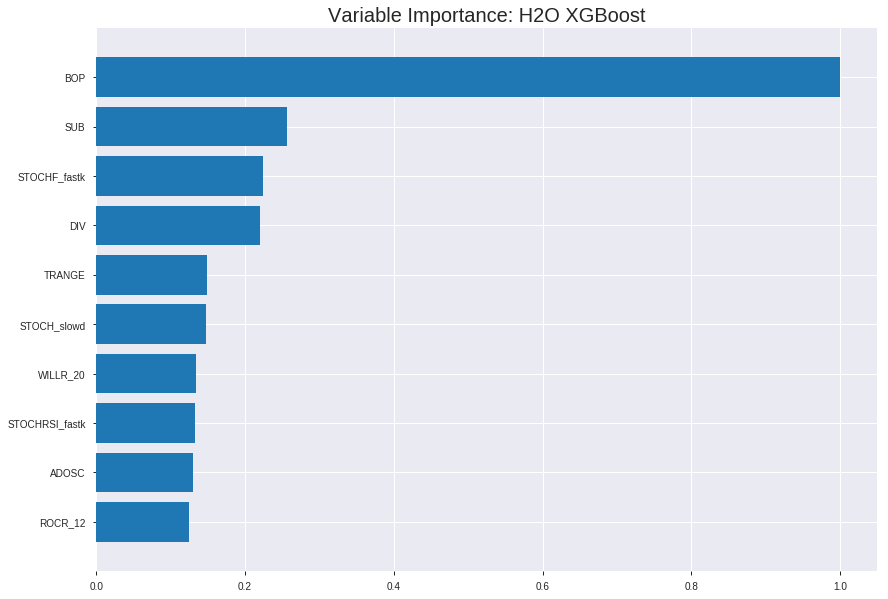

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_1_AutoML_20190827_215026


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.12261900176301942
RMSE: 0.35016996125170335
LogLoss: 0.4058104623823863
Mean Per-Class Error: 0.14182124455013878
AUC: 0.9390144008455542
pr_auc: 0.9454153946796349
Gini: 0.8780288016911084
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48622171580791473: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      687  154  0.1831   (154.0/841.0)
1      96   804  0.1067   (96.0/900.0)
Total  783  958  0.1436   (250.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.486222     0.865447  208
max f2                       0.3766       0.915286  256
max f0point5                 0.602994     0.881443  156
max accuracy                 0.527667     0.858128  192
max precision                0.938258     1         0
max recall                   0.201705     1         334
max specificity              0.938258     1         0
max absolute_mcc             0.527667     0.716108  192
max min_per_class_accuracy   0.527667     0.856667  192
max mean_per_class_accuracy  0.527667     0.858179  192

Gains/Lift Table: Avg response rate: 51.69 %, avg score: 51.43 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.90646            1.93444   1.93444            1                0.916773  1                           0.916773            0.02            0.02                       93.4444   93.4444
    2        0.0201034                   0.892211           1.93444   1.93444            1                0.898994  1                           0.908138            0.0188889       0.0388889                  93.4444   93.4444
    3        0.0304423                   0.88305            1.93444   1.93444            1                0.887489  1                           0.901125            0.02            0.0588889                  93.4444   93.4444
    4        0.0402068                   0.875185           1.93444   1.93444            1                0.877561  1                           0.895402            0.0188889       0.0777778                  93.4444   93.4444
    5        0.0505457                   0.867902           1.93444   1.93444            1                0.871851  1                           0.890585            0.02            0.0977778                  93.4444   93.4444
    6        0.100517                    0.832621           1.93444   1.93444            1                0.848834  1                           0.869829            0.0966667       0.194444                   93.4444   93.4444
    7        0.150488                    0.800145           1.93444   1.93444            1                0.814762  1                           0.851543            0.0966667       0.291111                   93.4444   93.4444
    8        0.20046                     0.770454           1.88997   1.92336            0.977011         0.784064  0.994269                    0.834722            0.0944444       0.385556                   88.9974   92.3359
    9        0.300402                    0.701679           1.8455    1.89746            0.954023         0.737347  0.98088                     0.802326            0.184444        0.57                       84.5504   89.7457
    10       0.400345                    0.622273           1.50086   1.79845            0.775862         0.661794  0.929699                    0.767243            0.15            0.72                       50.0862   79.8451
    11       0.500287                    0.534322           1.24516   1.68792            0.643678         0.579869  0.87256                     0.729811            0.124444        0.844444                   24.516    68.7919
    12       0.60023                     0.437585           0.833812  1.5457             0.431034         0.487233  0.799043                    0.68942             0.0833333       0.927778                   -16.6188  54.5704
    13       0.700172                    0.350637           0.4447    1.38855            0.229885         0.394285  0.717801                    0.647293            0.0444444       0.972222                   -55.53    38.8547
    14       0.800115                    0.249147           0.166762  1.23593            0.0862069        0.300103  0.638909                    0.603925            0.0166667       0.988889                   -83.3238  23.5934
    15       0.900057                    0.160651           0.111175  1.11104            0.0574713        0.201471  0.574346                    0.559237            0.0111111       1                          -88.8825  11.104
    16       1                           0.0558082          0         1                  0                0.109322  0.516944                    0.514271          



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.20711594150799875
RMSE: 0.4550999247505967
LogLoss: 0.6025307282064007
Mean Per-Class Error: 0.3100045372050817
AUC: 0.7371580891884885
pr_auc: 0.7180387858111882
Gini: 0.4743161783769769
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3406056761741638: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      100  132  0.569    (132.0/232.0)
1      29   237  0.109    (29.0/266.0)
Total  129  369  0.3233   (161.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.340606     0.746457  290
max f2                       0.192033     0.864811  357
max f0point5                 0.534696     0.711948  186
max accuracy                 0.44577      0.696787  240
max precision                0.90356      1         0
max recall                   0.10046      1         395
max specificity              0.90356      1         0
max absolute_mcc             0.442086     0.389262  242
max min_per_class_accuracy   0.517463     0.669173  196
max mean_per_class_accuracy  0.44577      0.689995  240

Gains/Lift Table: Avg response rate: 53.41 %, avg score: 50.85 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100402                   0.883273           1.12331   1.12331            0.6              0.896041  0.6                         0.896041            0.0112782       0.0112782                  12.3308   12.3308
    2        0.0200803                   0.858919           1.87218   1.49774            1                0.875822  0.8                         0.885932            0.018797        0.0300752                  87.218    49.7744
    3        0.0301205                   0.84997            1.49774   1.49774            0.8              0.853039  0.8                         0.874968            0.0150376       0.0451128                  49.7744   49.7744
    4        0.0401606                   0.843075           1.87218   1.59135            1                0.847086  0.85                        0.867997            0.018797        0.0639098                  87.218    59.1353
    5        0.0502008                   0.839829           1.12331   1.49774            0.6              0.84126   0.8                         0.86265             0.0112782       0.075188                   12.3308   49.7744
    6        0.100402                    0.809601           1.34797   1.42286            0.72             0.823578  0.76                        0.843114            0.0676692       0.142857                   34.797    42.2857
    7        0.150602                    0.766307           1.42286   1.42286            0.76             0.787259  0.76                        0.824496            0.0714286       0.214286                   42.2857   42.2857
    8        0.200803                    0.730646           1.27308   1.38541            0.68             0.745554  0.74                        0.80476             0.0639098       0.278195                   27.3083   38.5414
    9        0.301205                    0.654313           1.57263   1.44782            0.84             0.693078  0.773333                    0.767533            0.157895        0.43609                    57.2632   44.782
    10       0.399598                    0.580269           1.10803   1.36415            0.591837         0.614839  0.728643                    0.729935            0.109023        0.545113                   10.8025   36.4152
    11       0.5                         0.519756           1.16075   1.32331            0.62             0.551751  0.706827                    0.694155            0.116541        0.661654                   16.0752   32.3308
    12       0.600402                    0.452121           1.12331   1.28986            0.6              0.481547  0.688963                    0.658602            0.112782        0.774436                   12.3308   28.9863
    13       0.698795                    0.383825           0.764155  1.21584            0.408163         0.417453  0.649425                    0.624647            0.075188        0.849624                   -23.5845  21.5841
    14       0.799197                    0.283619           0.561654  1.13366            0.3              0.332651  0.605528                    0.587964            0.056391        0.906015                   -43.8346  13.3657
    15       0.899598                    0.185702           0.748872  1.09071            0.4              0.239459  0.582589                    0.549068            0.075188        0.981203                   -25.1128  9.07123
    16       1                           0.0878195          0.187218  1                  0.1              0.144953  0.534137                    0.508495          


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 21:50:26  0.007 sec   0                  0.5              0.693147            0.5             0                  1                0.483056                         0.5                0.693147              0.5               0                    1                  0.465863
    2019-08-27 21:50:27  0.148 sec   5                  0.470603         0.635699            0.848461        0.850708           1.93444          0.237794                         0.482596           0.658763              0.723384          0.68528              0.802363           0.311245
    2019-08-27 21:50:27  0.252 sec   10                 0.448346         0.593263            0.867528        0.875786           1.93444          0.224009                         0.474519           0.642824              0.725637          0.694077             1.17011            0.325301
    2019-08-27 21:50:27  0.347 sec   15                 0.430646         0.559582            0.87828         0.885349           1.93444          0.214819                         0.467116           0.628013              0.728181          0.695562             0.748872           0.359438
    2019-08-27 21:50:27  0.441 sec   20                 0.416356         0.532231            0.886632        0.8955             1.93444          0.20448                          0.464566           0.622577              0.727654          0.700615             0.748872           0.369478
    2019-08-27 21:50:27  0.534 sec   25                 0.40465          0.509496            0.894414        0.90058            1.93444          0.203906                         0.461219           0.615732              0.730198          0.700823             1.12331            0.345382
    2019-08-27 21:50:27  0.628 sec   30                 0.393463         0.488333            0.906136        0.913261           1.93444          0.188397                         0.458542           0.610313              0.733358          0.707504             1.49774            0.35743
    2019-08-27 21:50:27  0.718 sec   35                 0.384894         0.471504            0.911118        0.918406           1.93444          0.184377                         0.457332           0.607446              0.733512          0.711344             1.12331            0.315261
    2019-08-27 21:50:27  0.809 sec   40                 0.376863         0.455951            0.916748        0.924514           1.93444          0.172315                         0.454869           0.602287              0.736526          0.717721             1.12331            0.333333
    2019-08-27 21:50:27  0.906 sec   45                 0.36988          0.442608            0.922185        0.929372           1.93444          0.165997                         0.454658           0.601654              0.737328          0.719646             1.12331            0.325301
    2019-08-27 21:50:27  1.000 sec   50                 0.363322         0.429921            0.927772        0.93547            1.93444          0.156806                         0.455135           0.602485              0.736048          0.720526             1.49774            0.321285
    2019-08-27 21:50:28  1.102 sec   55                 0.356816         0.418075            0.933762        0.940642           1.93444          0.152211                         0.454913           0.601712              0.738211          0.

Variable Importances: 


variable                  relative_importance    scaled_importance      percentage
------------------------  ---------------------  ---------------------  ---------------------
BOP                       2209.00634765625       1.0                    0.24361857122923716
SUB                       566.1566162109375      0.2562946986601592     0.06243814830121587
STOCHF_fastk              495.73663330078125     0.2244161198661817     0.05467193448260841
DIV                       485.8828430175781      0.21995538561177       0.053585216776915315
TRANGE                    329.8205871582031      0.14930721566651084    0.036374010554890944
---                       ---                    ---                    ---
MINMAX_max_30             13.5155029296875       0.0061183631020469515  0.0014905468771823616
CDLLONGLINE               8.813705444335938      0.00398989593383797    0.0009720127467549492
CDLHARAMI                 5.881459712982178      0.0026624910875527323  0.0006486322746601744
BBANDS_middleband_30_7_3  5.358531475067139      0.0024257655396746716  0.0005909615349126629
CDLENGULFING              3.2325782775878906     0.001463363055075712   0.0003565024166671965


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.678714859437751)

('F1', 0.7134502923976607)

('auc', 0.7251420454545454)

('logloss', 0.6182062468156464)

('mean_per_class_error', 0.3204093491735538)

('rmse', 0.4630959070465152)

('mse', 0.21445781912323467)

xgboost prediction progress: |████████████████████████████████████████████| 100%


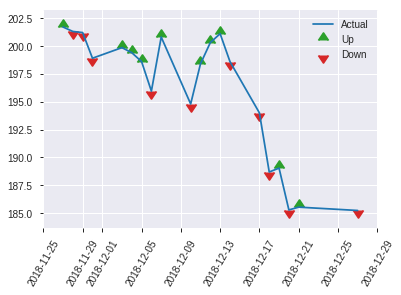


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.21445781912323467
RMSE: 0.4630959070465152
LogLoss: 0.6182062468156464
Mean Per-Class Error: 0.3204093491735538
AUC: 0.7251420454545454
pr_auc: 0.7302377842379069
Gini: 0.45028409090909083
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.21519047021865845: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      29   92   0.7603   (92.0/121.0)
1      6    122  0.0469   (6.0/128.0)
Total  35   214  0.3936   (98.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.21519      0.71345   213
max f2                       0.173357     0.845839  220
max f0point5                 0.480455     0.691667  117
max accuracy                 0.480455     0.678715  117
max precision                0.878638     1         0
max recall                   0.104367     1         244
max specificity              0.878638     1         0
max absolute_mcc             0.607967     0.36149   67
max min_per_class_accuracy   0.472175     0.669421  125
max mean_per_class_accuracy  0.480455     0.679591  117

Gains/Lift Table: Avg response rate: 51.41 %, avg score: 46.31 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.834845           1.94531   1.94531            1                0.856886  1                           0.856886            0.0234375       0.0234375                  94.5313   94.5313
    2        0.0200803                   0.819811           1.94531   1.94531            1                0.826857  1                           0.844874            0.015625        0.0390625                  94.5313   94.5313
    3        0.0321285                   0.811981           1.29688   1.70215            0.666667         0.817356  0.875                       0.834555            0.015625        0.0546875                  29.6875   70.2148
    4        0.0401606                   0.800103           1.94531   1.75078            1                0.804906  0.9                         0.828625            0.015625        0.0703125                  94.5313   75.0781
    5        0.0522088                   0.792739           1.29688   1.64603            0.666667         0.796872  0.846154                    0.821298            0.015625        0.0859375                  29.6875   64.6034
    6        0.100402                    0.743579           1.7832    1.71188            0.916667         0.773848  0.88                        0.798522            0.0859375       0.171875                   78.3203   71.1875
    7        0.15261                     0.698716           1.34675   1.58697            0.692308         0.718444  0.815789                    0.771127            0.0703125       0.242188                   34.6755   58.6965
    8        0.200803                    0.668783           1.7832    1.63406            0.916667         0.684232  0.84                        0.750272            0.0859375       0.328125                   78.3203   63.4063
    9        0.301205                    0.59275            1.245     1.50438            0.64             0.625126  0.773333                    0.708557            0.125           0.453125                   24.5      50.4375
    10       0.401606                    0.512272           1.08938   1.40063            0.56             0.55504   0.72                        0.670177            0.109375        0.5625                     8.9375    40.0625
    11       0.502008                    0.472654           1.01156   1.32281            0.52             0.488808  0.68                        0.633904            0.101562        0.664062                   1.15625   32.2813
    12       0.598394                    0.414748           0.810547  1.2403             0.416667         0.447717  0.637584                    0.603914            0.078125        0.742188                   -18.9453  24.03
    13       0.698795                    0.32867            0.700313  1.16272            0.36             0.371597  0.597701                    0.570535            0.0703125       0.8125                     -29.9688  16.2716
    14       0.799197                    0.256483           0.855938  1.12418            0.44             0.295324  0.577889                    0.535961            0.0859375       0.898438                   -14.4062  12.4176
    15       0.899598                    0.169012           0.700313  1.07687            0.36             0.215064  0.553571                    0.500146            0.0703125       0.96875                    -29.9688  7.68694
    16       1                           0.0867194          0.31125   1                  0.16             0.131124  0.514056                    0.463096           

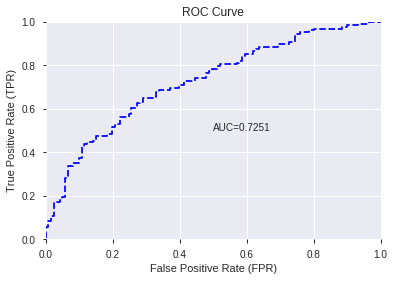

This function is available for GLM models only


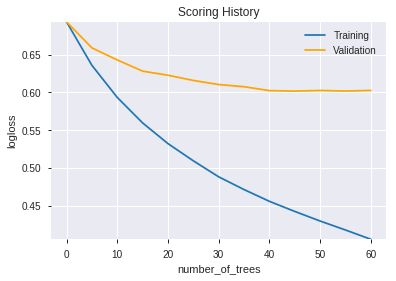

--2019-08-27 21:50:54--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.113.83
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.113.83|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_1_AutoML_20190827_215026',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_1_AutoML_20190827_215026',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_8479',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_66_sid_8479',
   'type

['BOP',
 'SUB',
 'STOCHF_fastk',
 'DIV',
 'TRANGE',
 'STOCH_slowd',
 'WILLR_20',
 'STOCHRSI_fastk',
 'ADOSC',
 'ROCR_12',
 'aroonup_30',
 'MFI_8',
 'COS',
 'WILLR_8',
 'MACDFIX_hist_8',
 'ROC_8',
 'SAREXT',
 'LINEARREG_SLOPE_8',
 'aroondown_24',
 'aroonup_8',
 'CMO_20',
 'BBANDS_lowerband_30_1_5',
 'month',
 'BBANDS_upperband_24_0_2',
 'BBANDS_lowerband_30_1_3',
 'CDLBELTHOLD',
 'BBANDS_upperband_8_2_3',
 'BBANDS_upperband_8_3_3',
 'BBANDS_lowerband_20_6_2',
 'BBANDS_upperband_8_8_3',
 'BBANDS_middleband_14_6_2',
 'SAR_0.14',
 'TRIMA_8',
 'BBANDS_lowerband_24_3_3',
 'CDLSHORTLINE',
 'MAVP_8_0',
 'CDLCLOSINGMARUBOZU',
 'BBANDS_lowerband_14_2_2',
 'days_in_month',
 'MAVP_8_8',
 'MINMAX_max_30',
 'CDLLONGLINE',
 'CDLHARAMI',
 'BBANDS_middleband_30_7_3',
 'CDLENGULFING']

In [21]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [23]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [24]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [25]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [27]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [28]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [29]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [31]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [32]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [33]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [35]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [36]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [37]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [39]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [40]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [41]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [43]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [44]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [45]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [46]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [906 929] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:721: RuntimeWarning: invalid value encountered in less
  return (self.pvalues_ < self.alpha / len(self.pvalues_))


25

['BOP',
 'CCI_8',
 'CMO_8',
 'RSI_8',
 'WILLR_8',
 'CMO_12',
 'RSI_12',
 'WILLR_12',
 'WILLR_14',
 'WILLR_20',
 'WILLR_24',
 'WILLR_30',
 'STOCHF_fastk',
 'STOCHRSI_fastk',
 'ULTOSC',
 'ADOSC',
 'TRANGE',
 'CDLBELTHOLD',
 'CDLCLOSINGMARUBOZU',
 'CDLENGULFING',
 'CDLLONGLINE',
 'CDLMARUBOZU',
 'CDLSHORTLINE',
 'DIV',
 'SUB']

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190827_215152_model_9  0.720041  0.625262              0.365509  0.467324  0.218391
1  DeepLearning_grid_1_AutoML_20190827_215152_model_8  0.718427  0.635432              0.383168  0.471199  0.222028
2  DeepLearning_grid_1_AutoML_20190827_215152_model_5  0.714230  0.720450              0.364153  0.489933  0.240035
3  DeepLearning_grid_1_AutoML_20190827_215152_model_6  0.713649  0.699991              0.360699  0.493381  0.243424
4  DeepLearning_grid_1_AutoML_20190827_215152_model_7  0.708226  0.832765              0.383394  0.508208  0.258276
5               DeepLearning_1_AutoML_20190827_215152  0.701898  1.160043              0.365735  0.574003  0.329480
6  DeepLearning_grid_1_AutoML_20190827_215152_model_4  0.694602  0.766778              0.382716  0.507819  0.257880
7  DeepLearning_grid_1_AutoML_20190827_215152_model_1  0.684982  1.671544              0.387074  0.598799  0.358560
8  DeepLearning_grid_1_AutoML_20190827_215152_model_3  0.674974  1.543665              0.347398  0.608950  0.370820
9  DeepLearning_grid_1_AutoML_20190827_215152_model_2  0.644305  1.527640              0.406605  0.604624  0.365570

variable  relative_importance  scaled_importance  percentage
0                  BOP             1.000000           1.000000    0.083845
1   CDLCLOSINGMARUBOZU             0.845843           0.845843    0.070920
2          CDLBELTHOLD             0.712620           0.712620    0.059750
3          CDLLONGLINE             0.655690           0.655690    0.054976
4         CDLSHORTLINE             0.630117           0.630117    0.052832
5         CDLENGULFING             0.623741           0.623741    0.052298
6                  DIV             0.580758           0.580758    0.048694
7          CDLMARUBOZU             0.571130           0.571130    0.047886
8                  SUB             0.558000           0.558000    0.046786
9                CCI_8             0.466388           0.466388    0.039104
10              TRANGE             0.440365           0.440365    0.036922
11        STOCHF_fastk             0.418286           0.418286    0.035071
12      STOCHRSI_fastk             0.393723           0.393723    0.033012
13               ADOSC             0.370694           0.370694    0.031081
14              ULTOSC             0.352814           0.352814    0.029582
15             WILLR_8             0.348983           0.348983    0.029261
16            WILLR_20             0.340498           0.340498    0.028549
17            WILLR_30             0.337017           0.337017    0.028257
18            WILLR_12             0.331398           0.331398    0.027786
19              RSI_12             0.331345           0.331345    0.027782
20            WILLR_14             0.327287           0.327287    0.027441
21               RSI_8             0.326691           0.326691    0.027391
22            WILLR_24             0.325858           0.325858    0.027322
23               CMO_8             0.321714           0.321714    0.026974
24              CMO_12             0.315789           0.315789    0.026477

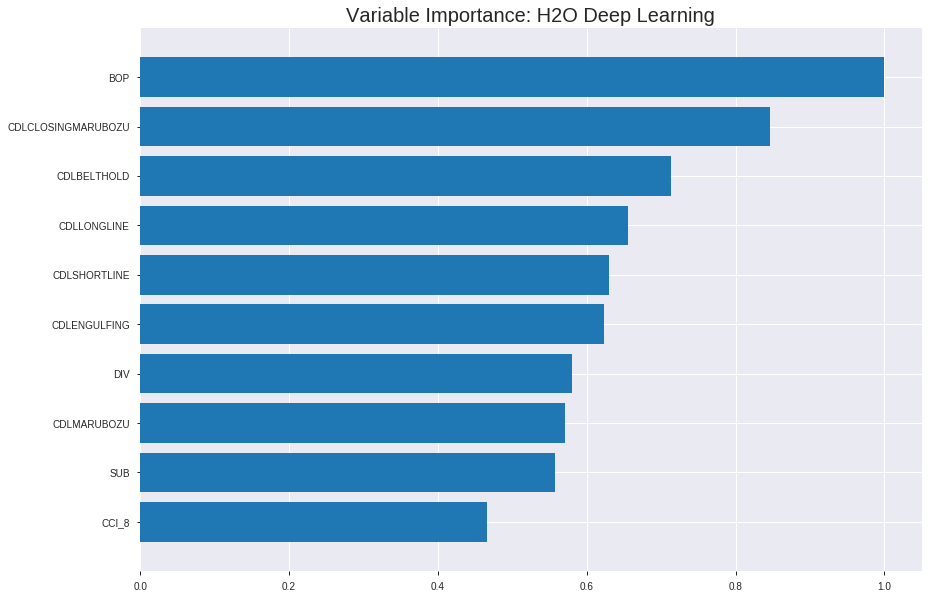

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190827_215152_model_9


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.20044375679703932
RMSE: 0.44770945578247434
LogLoss: 0.5864348165486059
Mean Per-Class Error: 0.28630334258158285
AUC: 0.7678299643281807
pr_auc: 0.7648778789709758
Gini: 0.5356599286563615
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4786505160203207: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      384  457   0.5434   (457.0/841.0)
1      107  793   0.1189   (107.0/900.0)
Total  491  1250  0.324    (564.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.478651     0.737674  260
max f2                       0.248336     0.85086   367
max f0point5                 0.608939     0.726802  171
max accuracy                 0.584509     0.713383  188
max precision                0.945338     1         0
max recall                   0.199479     1         392
max specificity              0.945338     1         0
max absolute_mcc             0.584509     0.427151  188
max min_per_class_accuracy   0.579712     0.711111  191
max mean_per_class_accuracy  0.584509     0.713697  188

Gains/Lift Table: Avg response rate: 51.69 %, avg score: 56.45 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.927013           1.93444   1.93444            1                0.934531  1                           0.934531            0.02            0.02                       93.4444   93.4444
    2        0.0201034                   0.91906            1.82065   1.87917            0.941176         0.923148  0.971429                    0.929002            0.0177778       0.0377778                  82.0654   87.9175
    3        0.0304423                   0.854328           1.61204   1.78845            0.833333         0.877864  0.924528                    0.911634            0.0166667       0.0544444                  61.2037   78.8449
    4        0.0402068                   0.846538           1.59307   1.741              0.823529         0.850174  0.9                         0.896708            0.0155556       0.07                       59.3072   74.1
    5        0.0505457                   0.82423            1.71951   1.7366             0.888889         0.837109  0.897727                    0.884518            0.0177778       0.0877778                  71.9506   73.6604
    6        0.100517                    0.79209            1.57868   1.6581             0.816092         0.80682   0.857143                    0.845891            0.0788889       0.166667                   57.8685   65.8095
    7        0.150488                    0.771738           1.53421   1.61696            0.793103         0.781038  0.835878                    0.824356            0.0766667       0.243333                   53.4215   61.6959
    8        0.20046                     0.74624            1.4008    1.56308            0.724138         0.76081   0.808023                    0.808515            0.07            0.313333                   40.0805   56.3075
    9        0.300402                    0.681679           1.35633   1.49429            0.701149         0.70329   0.772467                    0.773507            0.135556        0.448889                   35.6335   49.4294
    10       0.400345                    0.639547           1.32298   1.45153            0.683908         0.663956  0.750359                    0.746159            0.132222        0.581111                   32.2982   45.1527
    11       0.500287                    0.581793           1.24516   1.4103             0.643678         0.610498  0.729047                    0.719058            0.124444        0.705556                   24.516    41.0301
    12       0.60023                     0.527522           0.878282  1.32172            0.454023         0.552273  0.683254                    0.691287            0.0877778       0.793333                   -12.1718  32.1716
    13       0.700172                    0.487081           0.744872  1.23938            0.385057         0.509449  0.640689                    0.665331            0.0744444       0.867778                   -25.5128  23.9377
    14       0.800115                    0.372765           0.62258   1.16233            0.321839         0.441738  0.600861                    0.637402            0.0622222       0.93                       -37.742   16.2333
    15       0.900057                    0.271579           0.455817  1.08388            0.235632         0.309283  0.560306                    0.600968            0.0455556       0.975556                   -54.4183  8.38814
    16       1                           0.170666           0.244585  1                  0.126437         0.235719  0.516944                    0.564464            



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.19746497310508174
RMSE: 0.44437031078266437
LogLoss: 0.5848532212992583
Mean Per-Class Error: 0.282538242157117
AUC: 0.7679381643764585
pr_auc: 0.7394022645202077
Gini: 0.5358763287529169
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.43058910761730795: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      123  109  0.4698   (109.0/232.0)
1      32   234  0.1203   (32.0/266.0)
Total  155  343  0.2831   (141.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.430589     0.768473  261
max f2                       0.26854      0.862995  336
max f0point5                 0.541489     0.737774  179
max accuracy                 0.487606     0.722892  224
max precision                0.942213     1         0
max recall                   0.167364     1         394
max specificity              0.942213     1         0
max absolute_mcc             0.450015     0.44585   251
max min_per_class_accuracy   0.522142     0.695489  197
max mean_per_class_accuracy  0.487606     0.717462  224

Gains/Lift Table: Avg response rate: 53.41 %, avg score: 53.55 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100402                   0.9373             1.49774   1.49774            0.8              0.940661  0.8                         0.940661            0.0150376       0.0150376                  49.7744   49.7744
    2        0.0200803                   0.92329            1.49774   1.49774            0.8              0.927218  0.8                         0.93394             0.0150376       0.0300752                  49.7744   49.7744
    3        0.0301205                   0.921744           1.49774   1.49774            0.8              0.922811  0.8                         0.93023             0.0150376       0.0451128                  49.7744   49.7744
    4        0.0401606                   0.905858           1.12331   1.40414            0.6              0.917956  0.75                        0.927162            0.0112782       0.056391                   12.3308   40.4135
    5        0.0502008                   0.855561           1.49774   1.42286            0.8              0.885708  0.76                        0.918871            0.0150376       0.0714286                  49.7744   42.2857
    6        0.100402                    0.808772           1.64752   1.53519            0.88             0.830046  0.82                        0.874458            0.0827068       0.154135                   64.7519   53.5188
    7        0.150602                    0.785861           1.49774   1.52271            0.8              0.796511  0.813333                    0.848476            0.075188        0.229323                   49.7744   52.2707
    8        0.200803                    0.766874           1.49774   1.51647            0.8              0.774579  0.81                        0.830002            0.075188        0.304511                   49.7744   51.6466
    9        0.301205                    0.654559           1.23564   1.42286            0.66             0.714423  0.76                        0.791476            0.12406         0.428571                   23.5639   42.2857
    10       0.399598                    0.582836           1.52831   1.44882            0.816327         0.621018  0.773869                    0.749504            0.150376        0.578947                   52.8311   44.8823
    11       0.5                         0.525818           1.08586   1.37594            0.58             0.551789  0.73494                     0.709802            0.109023        0.68797                    8.58647   37.594
    12       0.600402                    0.485966           1.12331   1.33369            0.6              0.50589   0.712375                    0.675703            0.112782        0.800752                   12.3308   33.3694
    13       0.698795                    0.423814           0.802363  1.25888            0.428571         0.456156  0.672414                    0.64479             0.0789474       0.879699                   -19.7637  25.888
    14       0.799197                    0.314027           0.599098  1.17599            0.32             0.371801  0.628141                    0.610495            0.0601504       0.93985                    -40.0902  17.5993
    15       0.899598                    0.24135            0.336992  1.08235            0.18             0.272258  0.578125                    0.572745            0.0338346       0.973684                   -66.3008  8.23543
    16       1                           0.0953228          0.262105  1                  0.14             0.201367  0.534137                    0.535458           


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 21:58:26  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-27 21:58:28  2 min  9.751 sec  535 obs/sec       0.589316  1             1026       0.515804         0.85371             -0.0654395     0.747529        0.716361           1.82698          0.337737                         0.507328           0.87393               -0.0343463       0.73433           0.704895             1.12331            0.303213
    2019-08-27 21:58:38  2 min 19.321 sec  872 obs/sec       5.33429   9             9287       0.454371         0.600966            0.173238       0.762449        0.7578             1.93444          0.33027                          0.454147           0.601329              0.17114          0.762866          0.732085             1.49774            0.279116
    2019-08-27 21:58:47  2 min 28.094 sec  1060 obs/sec      11.3038   19            19680      0.451112         0.593797            0.185056       0.764203        0.756689           1.82698          0.329696                         0.45707            0.60528               0.160436         0.762907          0.751197             1.87218            0.295181
    2019-08-27 21:58:56  2 min 37.166 sec  1207 obs/sec      18.5709   31            32332      0.451052         0.594598            0.185271       0.767111        0.759723           1.93444          0.323377                         0.45408            0.59927               0.171383         0.770312          0.746616             1.49774            0.287149
    2019-08-27 21:59:04  2 min 46.023 sec  1324 obs/sec      26.4618   44            46070      0.447709         0.586435            0.197303       0.76783         0.764878           1.93444          0.323952                         0.44437            0.584853              0.206441         0.767938          0.739402             1.49774            0.283133
    2019-08-27 21:59:13  2 min 54.897 sec  1422 obs/sec      34.9569   58            60860      0.44226          0.575461            0.216725       0.77075         0.764658           1.82698          0.296956                         0.449519           0.599673              0.187945         0.765767          0.736955             1.49774            0.277108
    2019-08-27 21:59:22  3 min  3.971 sec  1504 obs/sec      44.0431   73            76679      0.440584         0.572459            0.222651       0.776866        0.773196           1.93444          0.301551                         0.446538           0.589276              0.198681         0.767792          0.745756             1.49774            0.287149
    2019-08-27 21:59:23  3 min  4.849 sec  1503 obs/sec      44.0431   73            76679      0.447709         0.586435            0.197303       0.76783         0.764878           1.93444          0.323952                         0.44437            0.584853              0.206441         0.767938          0.739402             1.49774            0.283133

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
BOP                 1.0                    1.0                  0.08384514658982198
CDLCLOSINGMARUBOZU  0.8458427786827087     0.8458427786827087   0.07091981177059406
CDLBELTHOLD         0.7126200795173645     0.7126200795173645   0.05974973502998403
CDLLONGLINE         0.6556899547576904     0.6556899547576904   0.0549764203741323
CDLSHORTLINE        0.6301165819168091     0.6301165819168091   0.05283221717949243
---                 ---                    ---                  ---
WILLR_14            0.32728713750839233    0.32728713750839233  0.02744143802135438
RSI_8               0.3266906440258026     0.3266906440258026   0.02739142493786677
WILLR_24            0.32585805654525757    0.32585805654525757  0.027321616518511622
CMO_8               0.3217144310474396     0.3217144310474396   0.026974193631233746
CMO_12              0.3157886564731598     0.3157886564731598   0.026477346193395018


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.678714859437751)

('F1', 0.7261538461538461)

('auc', 0.7200413223140496)

('logloss', 0.6252618885006771)

('mean_per_class_error', 0.32515495867768596)

('rmse', 0.4673235822182071)

('mse', 0.21839133049725734)

deeplearning prediction progress: |███████████████████████████████████████| 100%


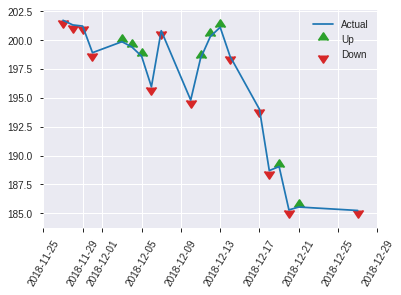


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.21839133049725734
RMSE: 0.4673235822182071
LogLoss: 0.6252618885006771
Mean Per-Class Error: 0.32515495867768596
AUC: 0.7200413223140496
pr_auc: 0.7120942047234851
Gini: 0.4400826446280992
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2539591821480605: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      42   79   0.6529   (79.0/121.0)
1      10   118  0.0781   (10.0/128.0)
Total  52   197  0.3574   (89.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.253959     0.726154  196
max f2                       0.214466     0.851499  221
max f0point5                 0.535709     0.678879  83
max accuracy                 0.324317     0.678715  159
max precision                0.943072     1         0
max recall                   0.163126     1         242
max specificity              0.943072     1         0
max absolute_mcc             0.324317     0.364692  159
max min_per_class_accuracy   0.424328     0.625     123
max mean_per_class_accuracy  0.324317     0.674845  159

Gains/Lift Table: Avg response rate: 51.41 %, avg score: 46.14 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.925476           1.94531   1.94531            1                0.932781  1                           0.932781            0.0234375       0.0234375                  94.5313   94.5313
    2        0.0200803                   0.916035           1.94531   1.94531            1                0.921203  1                           0.92815             0.015625        0.0390625                  94.5313   94.5313
    3        0.0321285                   0.885447           1.29688   1.70215            0.666667         0.910079  0.875                       0.921373            0.015625        0.0546875                  29.6875   70.2148
    4        0.0401606                   0.846663           0.972656  1.55625            0.5              0.857369  0.8                         0.908572            0.0078125       0.0625                     -2.73437  55.625
    5        0.0522088                   0.843229           1.29688   1.49639            0.666667         0.844837  0.769231                    0.893864            0.015625        0.078125                   29.6875   49.6394
    6        0.100402                    0.790269           1.62109   1.55625            0.833333         0.815219  0.8                         0.856114            0.078125        0.15625                    62.1094   55.625
    7        0.15261                     0.759702           1.64603   1.58697            0.846154         0.768747  0.815789                    0.826226            0.0859375       0.242188                   64.6034   58.6965
    8        0.200803                    0.717257           1.45898   1.55625            0.75             0.743624  0.8                         0.806401            0.0703125       0.3125                     45.8984   55.625
    9        0.301205                    0.550087           1.32281   1.47844            0.68             0.634369  0.76                        0.749057            0.132812        0.445312                   32.2813   47.8438
    10       0.401606                    0.48791            1.01156   1.36172            0.52             0.516886  0.7                         0.691015            0.101562        0.546875                   1.15625   36.1719
    11       0.502008                    0.423996           0.778125  1.245              0.4              0.45196   0.64                        0.643204            0.078125        0.625                      -22.1875  24.5
    12       0.598394                    0.349395           1.21582   1.2403             0.625            0.383503  0.637584                    0.601373            0.117188        0.742188                   21.582    24.03
    13       0.698795                    0.302165           0.93375   1.19626            0.48             0.321874  0.614943                    0.561215            0.09375         0.835938                   -6.625    19.6255
    14       0.799197                    0.246177           0.855938  1.1535             0.44             0.281765  0.592965                    0.526108            0.0859375       0.921875                   -14.4062  15.3502
    15       0.899598                    0.212007           0.544688  1.08555            0.28             0.228822  0.558036                    0.492929            0.0546875       0.976562                   -45.5312  8.55539
    16       1                           0.0973431          0.233438  1                  0.12             0.17877   0.514056                    0.461387            0.023

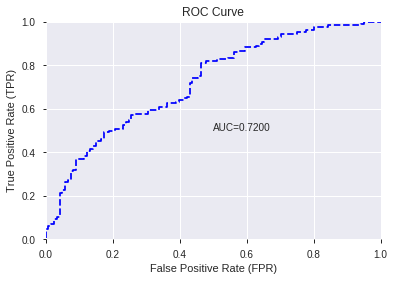

This function is available for GLM models only


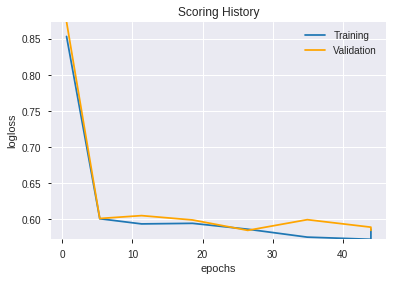

--2019-08-27 21:59:35--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.102.51
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.102.51|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190827_215152_model_9',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190827_215152_model_9',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_74_sid_8479',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'CDLCLOSINGMARUBOZU',
 'CDLBELTHOLD',
 'CDLLONGLINE',
 'CDLSHORTLINE',
 'CDLENGULFING',
 'DIV',
 'CDLMARUBOZU',
 'SUB',
 'CCI_8',
 'TRANGE',
 'STOCHF_fastk',
 'STOCHRSI_fastk',
 'ADOSC',
 'ULTOSC',
 'WILLR_8',
 'WILLR_20',
 'WILLR_30',
 'WILLR_12',
 'RSI_12',
 'WILLR_14',
 'RSI_8',
 'WILLR_24',
 'CMO_8',
 'CMO_12']

In [47]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id      auc  logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190827_220031_model_1  0.71578  0.72047              0.378357  0.501133  0.251134

variable  relative_importance  scaled_importance  percentage
0                  BOP             0.845924           1.000000    0.202536
1                CCI_8             0.427230           0.505045    0.102290
2             WILLR_20             0.336345           0.397607    0.080530
3                  SUB             0.301847           0.356826    0.072270
4         STOCHF_fastk             0.280547           0.331646    0.067170
5              WILLR_8             0.215377           0.254606    0.051567
6               ULTOSC             0.174272           0.206014    0.041725
7             WILLR_12             0.169770           0.200692    0.040647
8                  DIV             0.161864           0.191345    0.038754
9               CMO_12             0.157499           0.186186    0.037709
10            WILLR_14             0.156809           0.185371    0.037544
11              RSI_12             0.145156           0.171594    0.034754
12  CDLCLOSINGMARUBOZU             0.139925           0.165411    0.033502
13        CDLENGULFING             0.106270           0.125627    0.025444
14         CDLMARUBOZU             0.076787           0.090773    0.018385
15         CDLLONGLINE             0.070223           0.083013    0.016813
16            WILLR_24             0.067949           0.080325    0.016269
17              TRANGE             0.061040           0.072158    0.014615
18         CDLBELTHOLD             0.061025           0.072140    0.014611
19               CMO_8             0.056155           0.066383    0.013445
20        CDLSHORTLINE             0.048644           0.057504    0.011647
21            WILLR_30             0.043237           0.051112    0.010352
22               RSI_8             0.038613           0.045646    0.009245
23      STOCHRSI_fastk             0.028183           0.033316    0.006748
24               ADOSC             0.005971           0.007058    0.001429

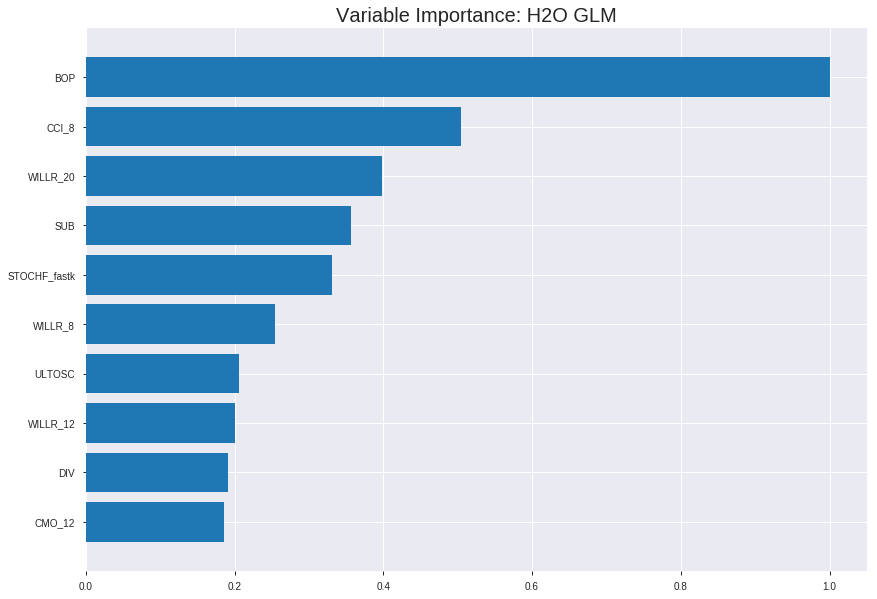

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190827_220031_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.19546133802979762
RMSE: 0.44211009718145733
LogLoss: 0.5727744256019498
Null degrees of freedom: 1740
Residual degrees of freedom: 1715
Null deviance: 2411.5386742145683
Residual deviance: 1994.400549945989
AIC: 2046.400549945989
AUC: 0.7674686220108337
pr_auc: 0.7653176289051763
Gini: 0.5349372440216673
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3534132308603774: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      383  458   0.5446   (458.0/841.0)
1      98   802   0.1089   (98.0/900.0)
Total  481  1260  0.3194   (556.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.353413     0.742593  272
max f2                       0.139217     0.855804  362
max f0point5                 0.593338     0.722362  161
max accuracy                 0.533742     0.703044  186
max precision                0.967452     1         0
max recall                   0.0658214    1         389
max specificity              0.967452     1         0
max absolute_mcc             0.593338     0.409527  161
max min_per_class_accuracy   0.533742     0.702735  186
max mean_per_class_accuracy  0.586982     0.703833  163

Gains/Lift Table: Avg response rate: 51.69 %, avg score: 51.69 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.924339           1.93444   1.93444            1                0.937698  1                           0.937698            0.02            0.02                       93.4444   93.4444
    2        0.0201034                   0.906              1.70686   1.8239             0.882353         0.91687   0.942857                    0.927581            0.0166667       0.0366667                  70.6863   82.3905
    3        0.0304423                   0.88257            1.61204   1.75195            0.833333         0.895794  0.90566                     0.916786            0.0166667       0.0533333                  61.2037   75.195
    4        0.0402068                   0.863759           1.82065   1.76863            0.941176         0.871626  0.914286                    0.905818            0.0177778       0.0711111                  82.0654   76.8635
    5        0.0505457                   0.849717           1.61204   1.7366             0.833333         0.855531  0.897727                    0.895532            0.0166667       0.0877778                  61.2037   73.6604
    6        0.100517                    0.804438           1.68986   1.71337            0.873563         0.825728  0.885714                    0.86083             0.0844444       0.172222                   68.986    71.3365
    7        0.150488                    0.771343           1.48974   1.63911            0.770115         0.787922  0.847328                    0.83662             0.0744444       0.246667                   48.9745   63.9109
    8        0.20046                     0.736406           1.4008    1.5797             0.724138         0.753933  0.816619                    0.816007            0.07            0.316667                   40.0805   57.9704
    9        0.300402                    0.677126           1.36745   1.50909            0.706897         0.707512  0.780115                    0.779911            0.136667        0.453333                   36.7452   50.9089
    10       0.400345                    0.620072           1.26739   1.44875            0.655172         0.648876  0.748924                    0.7472              0.126667        0.58                       26.7395   44.8752
    11       0.500287                    0.539073           1.1451    1.38809            0.591954         0.582603  0.717566                    0.714318            0.114444        0.694444                   14.5102   38.8092
    12       0.60023                     0.453499           0.956105  1.31616            0.494253         0.497048  0.680383                    0.678141            0.0955556       0.79                       -4.38953  31.6163
    13       0.700172                    0.372179           0.722637  1.23144            0.373563         0.414429  0.636587                    0.640499            0.0722222       0.862222                   -27.7363  23.1443
    14       0.800115                    0.286807           0.71152   1.1665             0.367816         0.3299    0.603015                    0.601702            0.0711111       0.933333                   -28.848   16.6499
    15       0.900057                    0.182968           0.48917   1.09129            0.252874         0.235859  0.564135                    0.561079            0.0488889       0.982222                   -51.083   9.12884
    16       1                           0.0141074          0.17788   1                  0.091954         0.119491  0.516944                    0.516945          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.20159899320778352
RMSE: 0.448997765259231
LogLoss: 0.5937693844926993
Null degrees of freedom: 497
Residual degrees of freedom: 472
Null deviance: 688.6415356931332
Residual deviance: 591.3943069547286
AIC: 643.3943069547286
AUC: 0.7716732564169043
pr_auc: 0.7368307693494688
Gini: 0.5433465128338086
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.32454575542726793: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      125  107  0.4612   (107.0/232.0)
1      31   235  0.1165   (31.0/266.0)
Total  156  342  0.2771   (138.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.324546     0.773026  265
max f2                       0.131697     0.868984  345
max f0point5                 0.530294     0.736648  158
max accuracy                 0.390533     0.726908  232
max precision                0.668102     0.811881  83
max recall                   0.0252372    1         393
max specificity              0.94466      0.99569   0
max absolute_mcc             0.324546     0.454131  265
max min_per_class_accuracy   0.455889     0.698276  196
max mean_per_class_accuracy  0.390533     0.72067   232

Gains/Lift Table: Avg response rate: 53.41 %, avg score: 45.14 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100402                   0.918211           1.12331   1.12331            0.6              0.935142   0.6                         0.935142            0.0112782       0.0112782                  12.3308   12.3308
    2        0.0200803                   0.882936           1.49774   1.31053            0.8              0.904279   0.7                         0.91971             0.0150376       0.0263158                  49.7744   31.0526
    3        0.0301205                   0.861113           1.49774   1.37293            0.8              0.874673   0.733333                    0.904698            0.0150376       0.0413534                  49.7744   37.2932
    4        0.0401606                   0.849326           1.49774   1.40414            0.8              0.85617    0.75                        0.892566            0.0150376       0.056391                   49.7744   40.4135
    5        0.0502008                   0.828128           1.12331   1.34797            0.6              0.837203   0.72                        0.881493            0.0112782       0.0676692                  12.3308   34.797
    6        0.100402                    0.758664           1.49774   1.42286            0.8              0.796646   0.76                        0.83907             0.075188        0.142857                   49.7744   42.2857
    7        0.150602                    0.706976           1.64752   1.49774            0.88             0.727256   0.8                         0.801798            0.0827068       0.225564                   64.7519   49.7744
    8        0.200803                    0.67051            1.57263   1.51647            0.84             0.690769   0.81                        0.774041            0.0789474       0.304511                   57.2632   51.6466
    9        0.301205                    0.603487           1.38541   1.47278            0.74             0.637231   0.786667                    0.728438            0.139098        0.443609                   38.5414   47.2782
    10       0.399598                    0.539542           1.4519    1.46764            0.77551          0.570954   0.78392                     0.68966             0.142857        0.586466                   45.1895   46.7639
    11       0.5                         0.46492            0.973534  1.36842            0.52             0.501553   0.730924                    0.651888            0.0977444       0.684211                   -2.64662  36.8421
    12       0.600402                    0.392507           1.16075   1.33369            0.62             0.426545   0.712375                    0.614205            0.116541        0.800752                   16.0752   33.3694
    13       0.698795                    0.307835           0.916986  1.27502            0.489796         0.352107   0.681034                    0.5773              0.0902256       0.890977                   -8.30137  27.5019
    14       0.799197                    0.216026           0.524211  1.1807             0.28             0.264494   0.630653                    0.538003            0.0526316       0.943609                   -47.5789  18.0697
    15       0.899598                    0.103316           0.374436  1.09071            0.2              0.155694   0.582589                    0.495335            0.037594        0.981203                   -62.5564  9.07123
    16       1                           0.00274604         0.187218  1                  0.1              0.0573023  0.534137                    


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-27 22:00:32  0.000 sec   2            .21E2     26            1.367241867133161   1.3626433824520259
     2019-08-27 22:00:32  0.008 sec   4            .13E2     26            1.3583206891360513  1.3527254974628418
     2019-08-27 22:00:32  0.014 sec   6            .82E1     26            1.3461826743637006  1.339409340033246
     2019-08-27 22:00:32  0.020 sec   8            .51E1     26            1.3305952191929356  1.3226764353641487
     2019-08-27 22:00:32  0.025 sec   10           .32E1     26            1.3116709171934338  1.3030445387241105
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-27 22:00:32  0.097 sec   40           .15E-2    26            1.145273992383751   1.1876426230923944
     2019-08-27 22:00:32  0.100 sec   41           .96E-3    26            1.145121621212228   1.1878971134312015
     2019-08-27 22:00:32  0.103 sec   42           .6E-3     26            1.1450450661297051  1.1881534413621353
     2019-08-27 22:00:32  0.105 sec   43           .37E-3    26            1.1450029918689695  1.188404302525986
     2019-08-27 22:00:32  0.109 sec   44           .23E-3    26            1.1449831073806644  1.1886150240959383


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6546184738955824)

('F1', 0.7228915662650602)

('auc', 0.715779958677686)

('logloss', 0.7204697899263333)

('mean_per_class_error', 0.33955320247933884)

('rmse', 0.5011327689969519)

('mse', 0.25113405216255236)

glm prediction progress: |████████████████████████████████████████████████| 100%


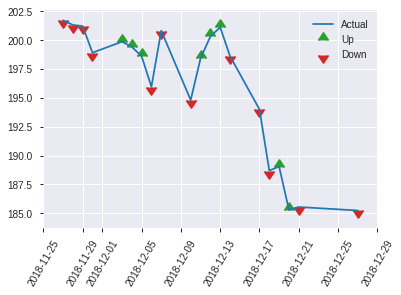


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.25113405216255236
RMSE: 0.5011327689969519
LogLoss: 0.7204697899263333
Null degrees of freedom: 248
Residual degrees of freedom: 223
Null deviance: 344.9987988800806
Residual deviance: 358.7939553833139
AIC: 410.7939553833139
AUC: 0.715779958677686
pr_auc: 0.709526739291557
Gini: 0.4315599173553719
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.09763263080307548: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      37   84   0.6942   (84.0/121.0)
1      8    120  0.0625   (8.0/128.0)
Total  45   204  0.3695   (92.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0976326    0.722892  203
max f2                       0.0319559    0.854473  236
max f0point5                 0.447078     0.683962  73
max accuracy                 0.447078     0.654618  73
max precision                0.928869     1         0
max recall                   0.0319559    1         236
max specificity              0.928869     1         0
max absolute_mcc             0.447078     0.350933  73
max min_per_class_accuracy   0.307929     0.636364  125
max mean_per_class_accuracy  0.447078     0.660447  73

Gains/Lift Table: Avg response rate: 51.41 %, avg score: 32.90 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.869529           1.94531   1.94531            1                0.901105   1                           0.901105            0.0234375       0.0234375                  94.5313   94.5313
    2        0.0200803                   0.82704            1.94531   1.94531            1                0.852108   1                           0.881506            0.015625        0.0390625                  94.5313   94.5313
    3        0.0321285                   0.755029           1.29688   1.70215            0.666667         0.804876   0.875                       0.85277             0.015625        0.0546875                  29.6875   70.2148
    4        0.0401606                   0.718268           1.94531   1.75078            1                0.730553   0.9                         0.828327            0.015625        0.0703125                  94.5313   75.0781
    5        0.0522088                   0.706695           1.94531   1.79567            1                0.714136   0.923077                    0.801975            0.0234375       0.09375                    94.5313   79.5673
    6        0.100402                    0.638476           1.45898   1.63406            0.75             0.666006   0.84                        0.73671             0.0703125       0.164062                   45.8984   63.4063
    7        0.15261                     0.588563           1.34675   1.53577            0.692308         0.60976    0.789474                    0.69328             0.0703125       0.234375                   34.6755   53.5773
    8        0.200803                    0.525386           1.45898   1.51734            0.75             0.562192   0.78                        0.661819            0.0703125       0.304688                   45.8984   51.7344
    9        0.301205                    0.444787           1.47844   1.50438            0.76             0.482901   0.773333                    0.602179            0.148438        0.453125                   47.8438   50.4375
    10       0.401606                    0.367957           0.855938  1.34227            0.44             0.409933   0.69                        0.554118            0.0859375       0.539062                   -14.4062  34.2266
    11       0.502008                    0.312941           0.93375   1.26056            0.48             0.338795   0.648                       0.511053            0.09375         0.632812                   -6.625    26.0563
    12       0.598394                    0.245055           0.972656  1.21419            0.5              0.272325   0.624161                    0.4726              0.09375         0.726562                   -2.73437  21.4188
    13       0.698795                    0.174166           1.01156   1.18508            0.52             0.206513   0.609195                    0.434369            0.101562        0.828125                   1.15625   18.5075
    14       0.799197                    0.112852           0.855938  1.14373            0.44             0.139883   0.58794                     0.397374            0.0859375       0.914062                   -14.4062  14.3726
    15       0.899598                    0.057815           0.544688  1.07687            0.28             0.0812328  0.553571                    0.36209             0.0546875       0.96875                    -45.5312  7.68694
    16       1                           0.00108843         0.31125   1                  0.16             0.0328741  0.514056                   

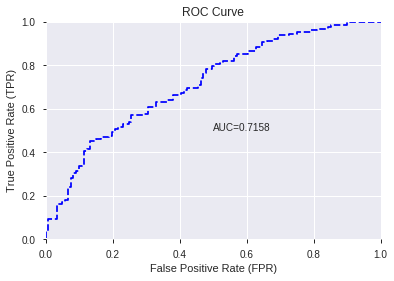

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


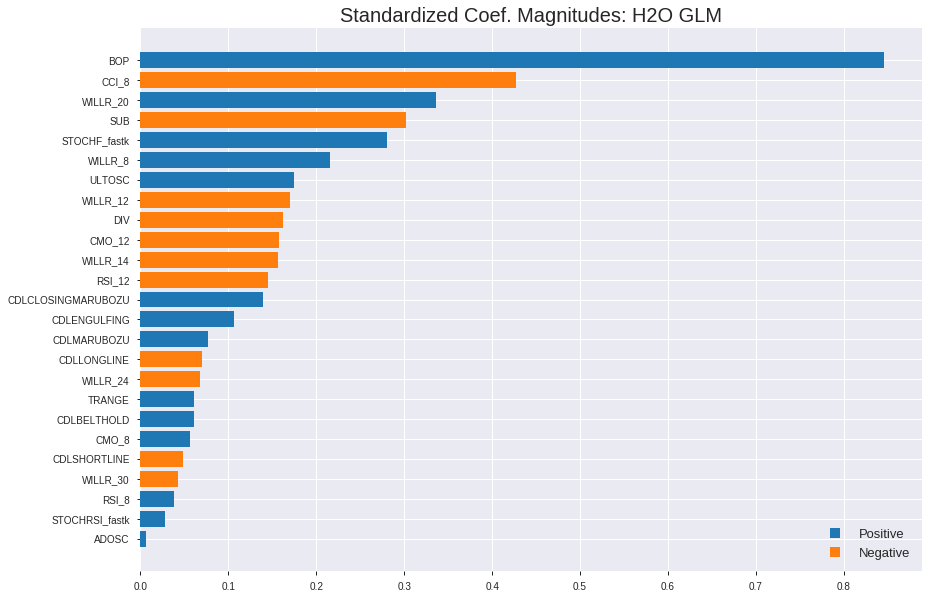

'log_likelihood'
--2019-08-27 22:00:42--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.229.179
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.229.179|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190827_220031_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190827_220031_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_8479',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['BOP',
 'CCI_8',
 'WILLR_20',
 'SUB',
 'STOCHF_fastk',
 'WILLR_8',
 'ULTOSC',
 'WILLR_12',
 'DIV',
 'CMO_12',
 'WILLR_14',
 'RSI_12',
 'CDLCLOSINGMARUBOZU',
 'CDLENGULFING',
 'CDLMARUBOZU',
 'CDLLONGLINE',
 'WILLR_24',
 'TRANGE',
 'CDLBELTHOLD',
 'CMO_8',
 'CDLSHORTLINE',
 'WILLR_30',
 'RSI_8',
 'STOCHRSI_fastk',
 'ADOSC']

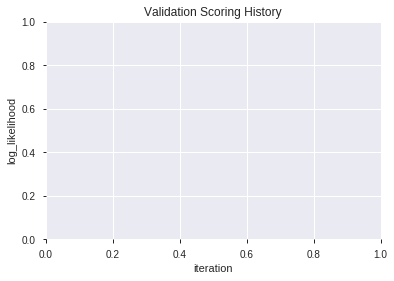

In [48]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190827_220138_model_7  0.730114  0.621283              0.374451  0.465788  0.216959
1               XGBoost_1_AutoML_20190827_220138  0.728177  0.618610              0.368737  0.463620  0.214944
2               XGBoost_2_AutoML_20190827_220138  0.727854  0.622522              0.391432  0.465300  0.216505
3  XGBoost_grid_1_AutoML_20190827_220138_model_1  0.726627  0.616783              0.391658  0.463527  0.214857
4               XGBoost_3_AutoML_20190827_220138  0.723399  0.624473              0.386848  0.466511  0.217632
5  XGBoost_grid_1_AutoML_20190827_220138_model_4  0.723140  0.621945              0.356340  0.465229  0.216438
6  XGBoost_grid_1_AutoML_20190827_220138_model_2  0.719783  0.623525              0.386848  0.465825  0.216993
7  XGBoost_grid_1_AutoML_20190827_220138_model_3  0.717652  0.628582              0.396242  0.467796  0.218833
8  XGBoost_grid_1_AutoML_20190827_220138_model_6  0.711712  0.630598              0.356340  0.469698  0.220616
9  XGBoost_grid_1_AutoML_20190827_220138_model_5  0.688791  0.660785              0.429074  0.482746  0.233044

variable  relative_importance  scaled_importance  percentage
0                  BOP          1971.651367           1.000000    0.209928
1         STOCHF_fastk           825.084900           0.418474    0.087849
2                CCI_8           700.249023           0.355159    0.074558
3                  DIV           661.584351           0.335548    0.070441
4                  SUB           620.294128           0.314606    0.066045
5               TRANGE           530.776550           0.269204    0.056513
6                ADOSC           511.246979           0.259299    0.054434
7               ULTOSC           448.655548           0.227553    0.047770
8       STOCHRSI_fastk           383.062531           0.194285    0.040786
9             WILLR_30           338.113953           0.171488    0.036000
10            WILLR_12           322.072632           0.163352    0.034292
11            WILLR_20           320.988800           0.162802    0.034177
12             WILLR_8           313.451202           0.158979    0.033374
13              CMO_12           285.479095           0.144792    0.030396
14            WILLR_14           245.065292           0.124294    0.026093
15            WILLR_24           243.197586           0.123347    0.025894
16               CMO_8           229.405838           0.116352    0.024426
17         CDLBELTHOLD           131.035873           0.066460    0.013952
18              RSI_12            98.213120           0.049813    0.010457
19               RSI_8            90.858177           0.046082    0.009674
20  CDLCLOSINGMARUBOZU            87.395935           0.044326    0.009305
21        CDLSHORTLINE            17.463604           0.008857    0.001859
22        CDLENGULFING             8.880804           0.004504    0.000946
23         CDLLONGLINE             7.815217           0.003964    0.000832

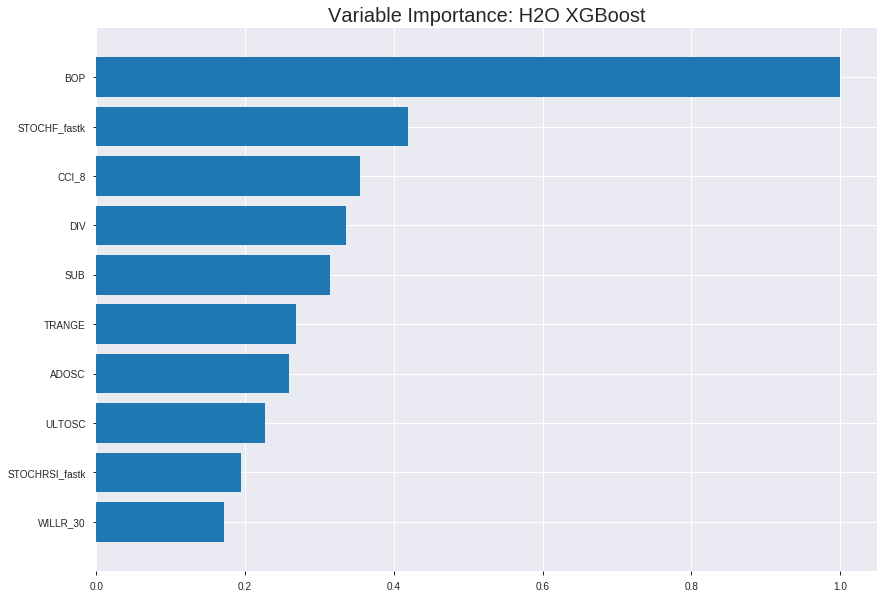

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190827_220138_model_7


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.12254034382890057
RMSE: 0.3500576292968067
LogLoss: 0.4040968277016009
Mean Per-Class Error: 0.14671356850310469
AUC: 0.9352563086272956
pr_auc: 0.940753746244465
Gini: 0.8705126172545912
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.46914663910865784: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      667  174  0.2069   (174.0/841.0)
1      82   818  0.0911   (82.0/900.0)
Total  749  992  0.147    (256.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.469147     0.864693  211
max f2                       0.371934     0.911092  254
max f0point5                 0.629816     0.874317  143
max accuracy                 0.484671     0.854681  205
max precision                0.935765     1         0
max recall                   0.176619     1         344
max specificity              0.935765     1         0
max absolute_mcc             0.484671     0.710188  205
max min_per_class_accuracy   0.525226     0.848889  189
max mean_per_class_accuracy  0.484671     0.853286  205

Gains/Lift Table: Avg response rate: 51.69 %, avg score: 51.60 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.906916           1.93444   1.93444            1                0.917447  1                           0.917447            0.02            0.02                       93.4444   93.4444
    2        0.0201034                   0.893988           1.93444   1.93444            1                0.899979  1                           0.908962            0.0188889       0.0388889                  93.4444   93.4444
    3        0.0304423                   0.88707            1.93444   1.93444            1                0.891031  1                           0.902873            0.02            0.0588889                  93.4444   93.4444
    4        0.0402068                   0.880478           1.93444   1.93444            1                0.883616  1                           0.898196            0.0188889       0.0777778                  93.4444   93.4444
    5        0.0505457                   0.872817           1.93444   1.93444            1                0.876472  1                           0.893752            0.02            0.0977778                  93.4444   93.4444
    6        0.100517                    0.845164           1.93444   1.93444            1                0.859364  1                           0.876657            0.0966667       0.194444                   93.4444   93.4444
    7        0.150488                    0.81256            1.93444   1.93444            1                0.828885  1                           0.860793            0.0966667       0.291111                   93.4444   93.4444
    8        0.20046                     0.782552           1.88997   1.92336            0.977011         0.797331  0.994269                    0.844973            0.0944444       0.385556                   88.9974   92.3359
    9        0.300402                    0.707461           1.76768   1.87157            0.913793         0.745408  0.967495                    0.811848            0.176667        0.562222                   76.7682   87.1566
    10       0.400345                    0.627509           1.51198   1.7818             0.781609         0.66733   0.92109                     0.77577             0.151111        0.713333                   51.198    78.1798
    11       0.500287                    0.53419            1.23404   1.67237            0.637931         0.5804    0.864524                    0.736741            0.123333        0.836667                   23.4042   67.2373
    12       0.60023                     0.433746           0.8894    1.542              0.45977          0.486256  0.797129                    0.695034            0.0888889       0.925556                   -11.06    54.2002
    13       0.700172                    0.335961           0.466935  1.38855            0.241379         0.385913  0.717801                    0.65091             0.0466667       0.972222                   -53.3065  38.8547
    14       0.800115                    0.252682           0.211232  1.24149            0.109195         0.293588  0.64178                     0.606277            0.0211111       0.993333                   -78.8768  24.1488
    15       0.900057                    0.154909           0.066705  1.11104            0.0344828        0.204975  0.574346                    0.561716            0.00666667      1                          -93.3295  11.104
    16       1                           0.0427188          0         1                  0                0.103868  0.516944                    0.515957          



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.20473627174491388
RMSE: 0.4524779240415093
LogLoss: 0.5960615632888306
Mean Per-Class Error: 0.3052242675654654
AUC: 0.7504537205081669
pr_auc: 0.7481675243100288
Gini: 0.5009074410163339
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.263375848531723: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      94   138  0.5948   (138.0/232.0)
1      20   246  0.0752   (20.0/266.0)
Total  114  384  0.3173   (158.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.263376     0.756923  308
max f2                       0.211071     0.859744  333
max f0point5                 0.510866     0.719512  191
max accuracy                 0.510866     0.692771  191
max precision                0.911841     1         0
max recall                   0.0917034    1         394
max specificity              0.911841     1         0
max absolute_mcc             0.263376     0.391796  308
max min_per_class_accuracy   0.484444     0.68797   202
max mean_per_class_accuracy  0.510866     0.694776  191

Gains/Lift Table: Avg response rate: 53.41 %, avg score: 49.48 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100402                   0.891946           1.87218   1.87218            1                0.900917  1                           0.900917            0.018797        0.018797                   87.218    87.218
    2        0.0200803                   0.882715           1.87218   1.87218            1                0.885967  1                           0.893442            0.018797        0.037594                   87.218    87.218
    3        0.0301205                   0.871301           1.49774   1.74737            0.8              0.877463  0.933333                    0.888116            0.0150376       0.0526316                  49.7744   74.7368
    4        0.0401606                   0.863074           0.748872  1.49774            0.4              0.867427  0.8                         0.882943            0.0075188       0.0601504                  -25.1128  49.7744
    5        0.0502008                   0.852067           1.49774   1.49774            0.8              0.858968  0.8                         0.878148            0.0150376       0.075188                   49.7744   49.7744
    6        0.100402                    0.819784           1.49774   1.49774            0.8              0.835076  0.8                         0.856612            0.075188        0.150376                   49.7744   49.7744
    7        0.150602                    0.781911           1.72241   1.57263            0.92             0.798991  0.84                        0.837405            0.0864662       0.236842                   72.2406   57.2632
    8        0.200803                    0.748671           1.34797   1.51647            0.72             0.765736  0.81                        0.819488            0.0676692       0.304511                   34.797    51.6466
    9        0.301205                    0.67856            1.38541   1.47278            0.74             0.715022  0.786667                    0.784666            0.139098        0.443609                   38.5414   47.2782
    10       0.399598                    0.587744           1.22265   1.41119            0.653061         0.632815  0.753769                    0.747276            0.120301        0.56391                    22.2648   41.1191
    11       0.5                         0.491861           1.16075   1.3609             0.62             0.540425  0.726908                    0.705739            0.116541        0.680451                   16.0752   36.0902
    12       0.600402                    0.409499           0.786316  1.26482            0.42             0.451097  0.675585                    0.663157            0.0789474       0.759398                   -21.3684  26.4818
    13       0.698795                    0.307208           0.878779  1.21046            0.469388         0.362287  0.646552                    0.620793            0.0864662       0.845865                   -12.1221  21.0461
    14       0.799197                    0.243465           0.898647  1.17129            0.48             0.274696  0.625628                    0.577314            0.0902256       0.93609                    -10.1353  17.1289
    15       0.899598                    0.168981           0.374436  1.08235            0.2              0.20441   0.578125                    0.535695            0.037594        0.973684                   -62.5564  8.23543
    16       1                           0.0512528          0.262105  1                  0.14             0.128042  0.534137                    0.494766           


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 22:01:51  8.816 sec   0                  0.5              0.693147            0.5             0                  1                0.483056                         0.5                0.693147              0.5               0                    1                  0.465863
    2019-08-27 22:01:51  8.958 sec   5                  0.470229         0.634963            0.844089        0.847187           1.93444          0.245261                         0.481385           0.656358              0.722501          0.723004             1.24812            0.353414
    2019-08-27 22:01:51  9.071 sec   10                 0.446237         0.589228            0.865888        0.87602            1.93444          0.219414                         0.469041           0.632062              0.738373          0.737309             1.87218            0.319277
    2019-08-27 22:01:51  9.182 sec   15                 0.426904         0.55251             0.879919        0.889229           1.93444          0.205629                         0.46211            0.617979              0.742984          0.73894              1.87218            0.305221
    2019-08-27 22:01:52  9.282 sec   20                 0.411448         0.522859            0.88952         0.899759           1.93444          0.198736                         0.456234           0.605744              0.747788          0.750987             1.87218            0.333333
    2019-08-27 22:01:52  9.370 sec   25                 0.399994         0.500428            0.896025        0.905493           1.93444          0.194141                         0.454729           0.602149              0.746395          0.745719             1.87218            0.317269
    2019-08-27 22:01:52  9.450 sec   30                 0.391947         0.484521            0.901338        0.910215           1.93444          0.190695                         0.453169           0.598369              0.746962          0.750576             1.87218            0.335341
    2019-08-27 22:01:52  9.539 sec   35                 0.38354          0.467836            0.906854        0.915261           1.93444          0.1861                           0.451105           0.593677              0.750356          0.752157             1.87218            0.327309
    2019-08-27 22:01:52  9.629 sec   40                 0.376142         0.453147            0.912134        0.921092           1.93444          0.184951                         0.450646           0.592356              0.749789          0.747089             1.87218            0.331325
    2019-08-27 22:01:52  9.720 sec   45                 0.369091         0.439447            0.918025        0.925967           1.93444          0.172889                         0.452093           0.594979              0.748096          0.740932             1.87218            0.323293
    2019-08-27 22:01:52  9.810 sec   50                 0.362486         0.427331            0.924837        0.932149           1.93444          0.169443                         0.452988           0.59712               0.746532          0.74227              1.87218            0.331325
    2019-08-27 22:01:52  9.900 sec   55                 0.355671         0.414515            0.930532        0.936852           1.93444          0.159104                         0.452229           0.595599              0.749733          0

Variable Importances: 


variable            relative_importance    scaled_importance     percentage
------------------  ---------------------  --------------------  ---------------------
BOP                 1971.6513671875        1.0                   0.2099278581609992
STOCHF_fastk        825.0848999023438      0.41847403330706584   0.08784935750814697
CCI_8               700.2490234375         0.35515864269471925   0.07455769316827002
DIV                 661.5843505859375      0.33554834368596675   0.07044094509946584
SUB                 620.2941284179688      0.3146063947921986    0.06604464662247998
---                 ---                    ---                   ---
RSI_8               90.8581771850586       0.0460822733152185    0.009673952936253586
CDLCLOSINGMARUBOZU  87.39593505859375      0.04432626199187606   0.009305317240237847
CDLSHORTLINE        17.463603973388672     0.008857348851840863  0.0018594042734517379
CDLENGULFING        8.880804061889648      0.004504246648106882  0.0009455668514659376
CDLLONGLINE         7.8152174949646        0.003963792800809793  0.0008321105328679881


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6706827309236948)

('F1', 0.7267267267267267)

('auc', 0.7301136363636364)

('logloss', 0.6212828620765408)

('mean_per_class_error', 0.33093362603305787)

('rmse', 0.46578806101267495)

('mse', 0.21695851778194739)

xgboost prediction progress: |████████████████████████████████████████████| 100%


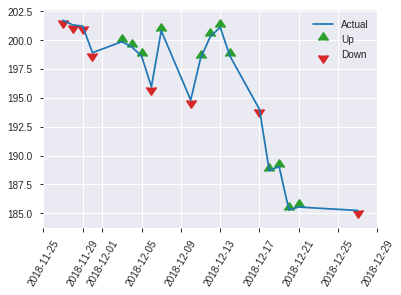


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.21695851778194739
RMSE: 0.46578806101267495
LogLoss: 0.6212828620765408
Mean Per-Class Error: 0.33093362603305787
AUC: 0.7301136363636364
pr_auc: 0.7357345584973048
Gini: 0.4602272727272727
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.20335005223751068: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      37   84   0.6942   (84.0/121.0)
1      7    121  0.0547   (7.0/128.0)
Total  44   205  0.3655   (91.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.20335      0.726727  204
max f2                       0.123802     0.860215  231
max f0point5                 0.496146     0.680147  103
max accuracy                 0.361391     0.670683  139
max precision                0.864846     1         0
max recall                   0.123802     1         231
max specificity              0.864846     1         0
max absolute_mcc             0.686616     0.359984  48
max min_per_class_accuracy   0.412828     0.644628  125
max mean_per_class_accuracy  0.361391     0.669066  139

Gains/Lift Table: Avg response rate: 51.41 %, avg score: 44.18 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.857817           1.94531   1.94531            1                0.863563  1                           0.863563            0.0234375       0.0234375                  94.5313   94.5313
    2        0.0200803                   0.851941           0.972656  1.55625            0.5              0.853361  0.8                         0.859482            0.0078125       0.03125                    -2.73437  55.625
    3        0.0321285                   0.85017            1.94531   1.70215            1                0.851423  0.875                       0.85646             0.0234375       0.0546875                  94.5313   70.2148
    4        0.0401606                   0.844193           1.94531   1.75078            1                0.848472  0.9                         0.854862            0.015625        0.0703125                  94.5313   75.0781
    5        0.0522088                   0.830435           1.29688   1.64603            0.666667         0.840013  0.846154                    0.851435            0.015625        0.0859375                  29.6875   64.6034
    6        0.100402                    0.805451           1.94531   1.78969            1                0.813737  0.92                        0.83334             0.09375         0.179688                   94.5313   78.9688
    7        0.15261                     0.740895           1.49639   1.68935            0.769231         0.77402   0.868421                    0.813047            0.078125        0.257812                   49.6394   68.935
    8        0.200803                    0.681275           1.62109   1.67297            0.833333         0.705094  0.86                        0.787138            0.078125        0.335938                   62.1094   67.2969
    9        0.301205                    0.580544           1.01156   1.4525             0.52             0.630867  0.746667                    0.735048            0.101562        0.4375                     1.15625   45.25
    10       0.401606                    0.513287           1.16719   1.38117            0.6              0.545157  0.71                        0.687575            0.117188        0.554688                   16.7188   38.1172
    11       0.502008                    0.413224           0.855938  1.27613            0.44             0.465554  0.656                       0.643171            0.0859375       0.640625                   -14.4062  27.6125
    12       0.598394                    0.324416           0.972656  1.22724            0.5              0.370404  0.630872                    0.599235            0.09375         0.734375                   -2.73437  22.7244
    13       0.698795                    0.269014           1.01156   1.19626            0.52             0.295009  0.614943                    0.555524            0.101562        0.835938                   1.15625   19.6255
    14       0.799197                    0.20977            0.778125  1.14373            0.4              0.241656  0.58794                     0.516094            0.078125        0.914062                   -22.1875  14.3726
    15       0.899598                    0.154517           0.544688  1.07687            0.28             0.184669  0.553571                    0.479104            0.0546875       0.96875                    -45.5312  7.68694
    16       1                           0.0527624          0.31125   1                  0.16             0.107373  0.514056                    0.441782            0

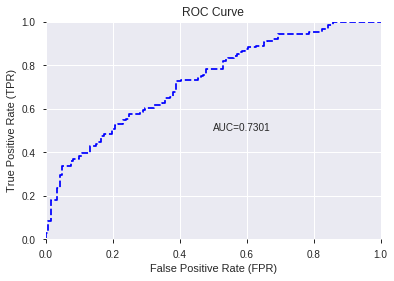

This function is available for GLM models only


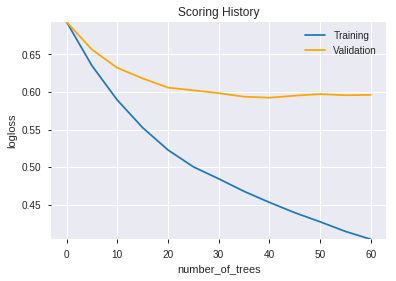

--2019-08-27 22:02:03--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.232.107
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.232.107|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNod

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190827_220138_model_7',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190827_220138_model_7',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_8479',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'STOCHF_fastk',
 'CCI_8',
 'DIV',
 'SUB',
 'TRANGE',
 'ADOSC',
 'ULTOSC',
 'STOCHRSI_fastk',
 'WILLR_30',
 'WILLR_12',
 'WILLR_20',
 'WILLR_8',
 'CMO_12',
 'WILLR_14',
 'WILLR_24',
 'CMO_8',
 'CDLBELTHOLD',
 'RSI_12',
 'RSI_8',
 'CDLCLOSINGMARUBOZU',
 'CDLSHORTLINE',
 'CDLENGULFING',
 'CDLLONGLINE']

In [49]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [50]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

73

['BBANDS_lowerband_14_5_2',
 'BBANDS_upperband_14_7_3',
 'BBANDS_upperband_20_1_2',
 'BBANDS_upperband_20_2_4',
 'BBANDS_lowerband_20_5_3',
 'BBANDS_lowerband_20_5_4',
 'BBANDS_upperband_20_6_2',
 'BBANDS_lowerband_24_1_4',
 'BOP',
 'aroondown_8',
 'aroonup_8',
 'CCI_8',
 'MFI_8',
 'MOM_8',
 'RSI_8',
 'TRIX_8',
 'aroonup_12',
 'MACDFIX_12',
 'MACDFIX_hist_12',
 'MINUS_DM_12',
 'MOM_12',
 'ROCR_12',
 'aroondown_14',
 'aroonup_14',
 'CCI_14',
 'CMO_14',
 'DX_14',
 'MINUS_DI_14',
 'ROCP_14',
 'ROCR_14',
 'RSI_14',
 'WILLR_14',
 'aroondown_20',
 'DX_20',
 'MACDFIX_20',
 'ROCR_20',
 'aroonup_24',
 'CCI_24',
 'CMO_24',
 'MACDFIX_signal_24',
 'ROCR_24',
 'WILLR_24',
 'aroonup_30',
 'CMO_30',
 'MFI_30',
 'PLUS_DI_30',
 'ROCP_30',
 'WILLR_30',
 'MACDEXT',
 'STOCH_slowk',
 'STOCH_slowd',
 'STOCHF_fastk',
 'ULTOSC',
 'ADOSC',
 'ATR_12',
 'ATR_30',
 'TRANGE',
 'HT_PHASOR_inphase',
 'HT_PHASOR_quadrature',
 'CDLBELTHOLD',
 'CDLCLOSINGMARUBOZU',
 'CDLHIGHWAVE',
 'CDLLONGLINE',
 'BETA_8',
 'STDDEV_8'

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190827_220410_model_6  0.739024  0.599194              0.318020  0.455361  0.207354
1  DeepLearning_grid_1_AutoML_20190827_220410_model_9  0.732438  0.639563              0.326737  0.472685  0.223431
2  DeepLearning_grid_1_AutoML_20190827_220410_model_8  0.716813  0.626078              0.378131  0.468744  0.219721
3  DeepLearning_grid_1_AutoML_20190827_220410_model_5  0.707193  0.648661              0.400149  0.472608  0.223358
4  DeepLearning_grid_1_AutoML_20190827_220410_model_3  0.681108  1.391412              0.385718  0.579420  0.335728
5  DeepLearning_grid_1_AutoML_20190827_220410_model_2  0.679106  1.923173              0.412545  0.604062  0.364890
6  DeepLearning_grid_1_AutoML_20190827_220410_model_7  0.678525  0.808206              0.342588  0.517416  0.267719
7  DeepLearning_grid_1_AutoML_20190827_220410_model_4  0.677557  0.789883              0.395790  0.511616  0.261751
8               DeepLearning_1_AutoML_20190827_220410  0.676007  0.792777              0.384362  0.510869  0.260987
9  DeepLearning_grid_1_AutoML_20190827_220410_model_1  0.659672  1.211957              0.372869  0.544872  0.296885

variable  relative_importance  scaled_importance  percentage
0                       BOP             1.000000           1.000000    0.041245
1        CDLCLOSINGMARUBOZU             0.722966           0.722966    0.029818
2                    TRANGE             0.714797           0.714797    0.029482
3               CDLBELTHOLD             0.665512           0.665512    0.027449
4               CDLLONGLINE             0.534362           0.534362    0.022040
..                      ...                  ...                ...         ...
68                   RSI_14             0.245811           0.245811    0.010138
69                    TSF_8             0.245256           0.245256    0.010115
70  BBANDS_lowerband_24_1_4             0.243267           0.243267    0.010033
71               MACDFIX_12             0.242594           0.242594    0.010006
72  BBANDS_lowerband_20_5_3             0.241438           0.241438    0.009958

[73 rows x 4 columns]

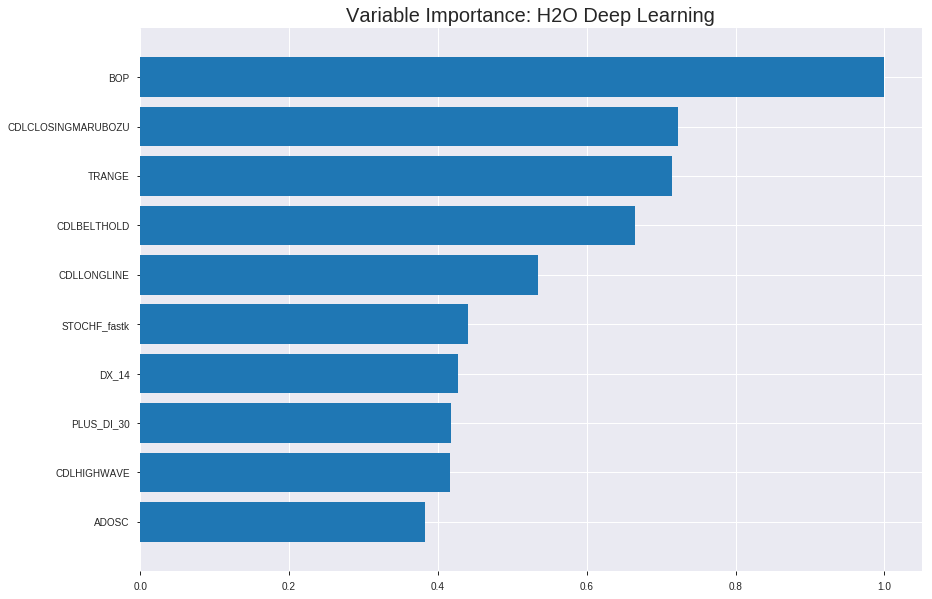

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190827_220410_model_6


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.1749450206022095
RMSE: 0.41826429515583746
LogLoss: 0.5214411753278412
Mean Per-Class Error: 0.2567710397674725
AUC: 0.824090368608799
pr_auc: 0.8301650022532003
Gini: 0.6481807372175981
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4999465698381006: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      517  324   0.3853   (324.0/841.0)
1      124  776   0.1378   (124.0/900.0)
Total  641  1100  0.2573   (448.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.499947     0.776     224
max f2                       0.327855     0.867826  294
max f0point5                 0.596347     0.757173  166
max accuracy                 0.553631     0.7444    193
max precision                0.999311     1         0
max recall                   0.0800867    1         383
max specificity              0.999311     1         0
max absolute_mcc             0.499947     0.494176  224
max min_per_class_accuracy   0.567906     0.731111  185
max mean_per_class_accuracy  0.553631     0.743229  193

Gains/Lift Table: Avg response rate: 51.69 %, avg score: 54.53 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.987436           1.93444   1.93444            1                0.991853  1                           0.991853            0.02            0.02                       93.4444   93.4444
    2        0.0201034                   0.977093           1.93444   1.93444            1                0.982852  1                           0.987481            0.0188889       0.0388889                  93.4444   93.4444
    3        0.0304423                   0.96192            1.82698   1.89795            0.944444         0.969972  0.981132                    0.981534            0.0188889       0.0577778                  82.6975   89.7945
    4        0.0402068                   0.950749           1.93444   1.90681            1                0.956134  0.985714                    0.975366            0.0188889       0.0766667                  93.4444   90.681
    5        0.0505457                   0.928851           1.82698   1.89048            0.944444         0.940276  0.977273                    0.968188            0.0188889       0.0955556                  82.6975   89.048
    6        0.100517                    0.850604           1.73433   1.81285            0.896552         0.892962  0.937143                    0.93079             0.0866667       0.182222                   73.433    81.2851
    7        0.150488                    0.792563           1.75656   1.79416            0.908046         0.823134  0.927481                    0.895042            0.0877778       0.27                       75.6564   79.416
    8        0.20046                     0.74311            1.60092   1.74599            0.827586         0.767956  0.902579                    0.863361            0.08            0.35                       60.092    74.5989
    9        0.300402                    0.657122           1.42304   1.63854            0.735632         0.699992  0.847036                    0.809009            0.142222        0.492222                   42.304    63.8545
    10       0.400345                    0.599839           1.25628   1.54311            0.649425         0.627029  0.797704                    0.763579            0.125556        0.617778                   25.6277   54.3115
    11       0.500287                    0.569445           1.06728   1.44806            0.551724         0.583624  0.748565                    0.72763             0.106667        0.724444                   6.72797   44.8057
    12       0.60023                     0.523975           1.02281   1.37725            0.528736         0.548311  0.711962                    0.697772            0.102222        0.826667                   2.28097   37.725
    13       0.700172                    0.439591           0.733755  1.2854             0.37931          0.482666  0.664479                    0.667068            0.0733333       0.9                        -26.6245  28.5398
    14       0.800115                    0.333738           0.611462  1.20122            0.316092         0.385592  0.620962                    0.631908            0.0611111       0.961111                   -38.8538  20.1216
    15       0.900057                    0.207264           0.300172  1.10116            0.155172         0.268701  0.569241                    0.591578            0.03            0.991111                   -69.9828  10.1164
    16       1                           0.00540709         0.08894   1                  0.045977         0.128523  0.516944                    0.545299            0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.20801967159430676
RMSE: 0.4560917359416927
LogLoss: 0.6021342294792713
Mean Per-Class Error: 0.31211109670728543
AUC: 0.7390134819808141
pr_auc: 0.7385405508930459
Gini: 0.47802696396162814
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.43731964657541705: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      100  132  0.569    (132.0/232.0)
1      28   238  0.1053   (28.0/266.0)
Total  128  370  0.3213   (160.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.43732      0.748428  279
max f2                       0.242577     0.86071   361
max f0point5                 0.553404     0.707763  191
max accuracy                 0.494395     0.694779  245
max precision                0.973165     1         0
max recall                   0.0701534    1         395
max specificity              0.973165     1         0
max absolute_mcc             0.491069     0.389961  247
max min_per_class_accuracy   0.557584     0.676724  186
max mean_per_class_accuracy  0.534638     0.687889  213

Gains/Lift Table: Avg response rate: 53.41 %, avg score: 53.13 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100402                   0.935751           1.87218   1.87218            1                0.956075  1                           0.956075            0.018797        0.018797                   87.218    87.218
    2        0.0200803                   0.898313           1.87218   1.87218            1                0.915545  1                           0.93581             0.018797        0.037594                   87.218    87.218
    3        0.0301205                   0.870696           1.87218   1.87218            1                0.889197  1                           0.920273            0.018797        0.056391                   87.218    87.218
    4        0.0401606                   0.847852           1.49774   1.77857            0.8              0.857138  0.95                        0.904489            0.0150376       0.0714286                  49.7744   77.8571
    5        0.0502008                   0.816457           0.748872  1.57263            0.4              0.835843  0.84                        0.89076             0.0075188       0.0789474                  -25.1128  57.2632
    6        0.100402                    0.755902           1.42286   1.49774            0.76             0.783971  0.8                         0.837366            0.0714286       0.150376                   42.2857   49.7744
    7        0.150602                    0.69546            1.49774   1.49774            0.8              0.729328  0.8                         0.801353            0.075188        0.225564                   49.7744   49.7744
    8        0.200803                    0.659831           1.1982    1.42286            0.64             0.677689  0.76                        0.770437            0.0601504       0.285714                   19.8195   42.2857
    9        0.301205                    0.597158           1.31053   1.38541            0.7              0.623238  0.74                        0.721371            0.131579        0.417293                   31.0526   38.5414
    10       0.399598                    0.572345           1.33727   1.37356            0.714286         0.583135  0.733668                    0.687333            0.131579        0.548872                   33.7272   37.356
    11       0.5                         0.560919           1.16075   1.33083            0.62             0.567497  0.710843                    0.663269            0.116541        0.665414                   16.0752   33.0827
    12       0.600402                    0.529415           1.04842   1.2836             0.56             0.544751  0.685619                    0.64345             0.105263        0.770677                   4.84211   28.3602
    13       0.698795                    0.475661           0.840571  1.22122            0.44898          0.503747  0.652299                    0.623779            0.0827068       0.853383                   -15.9429  22.1221
    14       0.799197                    0.402859           0.711429  1.15718            0.38             0.433593  0.61809                     0.599887            0.0714286       0.924812                   -28.8571  15.7177
    15       0.899598                    0.265446           0.449323  1.07818            0.24             0.343172  0.575893                    0.571235            0.0451128       0.969925                   -55.0677  7.81753
    16       1                           0.0265249          0.299549  1                  0.16             0.173052  0.534137                    0.531257            0


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 22:08:22  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-27 22:08:25  2 min 12.859 sec  958 obs/sec       1.46468   1             2550       0.468285         0.669655            0.121828       0.74795         0.741601           1.93444          0.327972                         0.545222           0.926192              -0.194637        0.650627          0.654352             1.87218            0.385542
    2019-08-27 22:08:31  2 min 19.201 sec  1205 obs/sec      5.86617   4             10213      0.449102         0.586669            0.1923         0.762544        0.768291           1.93444          0.313038                         0.467684           0.628974              0.120988         0.723279          0.707762             1.49774            0.337349
    2019-08-27 22:08:37  2 min 24.511 sec  1737 obs/sec      13.2211   9             23018      0.440823         0.568509            0.221806       0.773796        0.774987           1.93444          0.309018                         0.47249            0.638173              0.10283          0.687994          0.687591             1.49774            0.385542
    2019-08-27 22:08:42  2 min 30.229 sec  2080 obs/sec      22.023    15            38342      0.431509         0.549067            0.254345       0.794892        0.795116           1.93444          0.293509                         0.461208           0.613904              0.145163         0.740707          0.733982             1.49774            0.323293
    2019-08-27 22:08:48  2 min 35.737 sec  2291 obs/sec      30.8196   21            53657      0.429905         0.545238            0.259877       0.799184        0.802933           1.93444          0.287766                         0.466983           0.624421              0.123624         0.730401          0.730679             1.87218            0.327309
    2019-08-27 22:08:53  2 min 41.158 sec  2438 obs/sec      39.6152   27            68970      0.422635         0.529796            0.284696       0.810173        0.814485           1.93444          0.270534                         0.454291           0.602537              0.170614         0.7462            0.739376             1.49774            0.313253
    2019-08-27 22:08:59  2 min 47.349 sec  2562 obs/sec      49.9052   34            86885      0.418264         0.521441            0.299415       0.82409         0.830165           1.93444          0.257323                         0.456092           0.602134              0.164025         0.739013          0.738541             1.87218            0.321285
    2019-08-27 22:09:05  2 min 53.292 sec  2661 obs/sec      60.1223   41            104673     0.412903         0.509877            0.317259       0.830826        0.838181           1.93444          0.258472                         0.456647           0.603279              0.161987         0.740407          0.740538             1.87218            0.319277
    2019-08-27 22:09:11

Variable Importances: 


variable                 relative_importance    scaled_importance    percentage
-----------------------  ---------------------  -------------------  --------------------
BOP                      1.0                    1.0                  0.04124459601985923
CDLCLOSINGMARUBOZU       0.7229664921760559     0.7229664921760559   0.02981846090569614
TRANGE                   0.7147971391677856     0.7147971391677856   0.02948151924112641
CDLBELTHOLD              0.6655119061470032     0.6655119061470032   0.02744876971543961
CDLLONGLINE              0.5343624353408813     0.5343624353408813   0.022039562773822796
---                      ---                    ---                  ---
RSI_14                   0.24581125378608704    0.24581125378608704  0.010138385859542251
TSF_8                    0.2452561855316162     0.2452561855316162   0.010115492293623154
BBANDS_lowerband_24_1_4  0.24326744675636292    0.24326744675636292  0.010033467566248802
MACDFIX_12               0.24259373545646667    0.24259373545646667  0.010005680615850568
BBANDS_lowerband_20_5_3  0.2414383739233017     0.2414383739233017   0.009958028196158292


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6867469879518072)

('F1', 0.7364864864864866)

('auc', 0.7390237603305785)

('logloss', 0.5991939062192513)

('mean_per_class_error', 0.315599173553719)

('rmse', 0.45536143512118216)

('mse', 0.2073540365956226)

deeplearning prediction progress: |███████████████████████████████████████| 100%


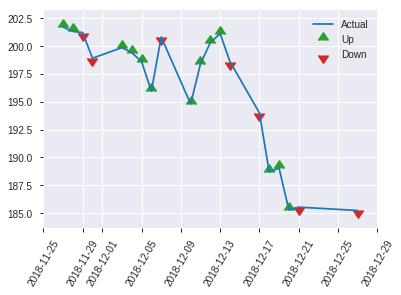


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2073540365956226
RMSE: 0.45536143512118216
LogLoss: 0.5991939062192513
Mean Per-Class Error: 0.315599173553719
AUC: 0.7390237603305785
pr_auc: 0.7460240342550588
Gini: 0.47804752066115697
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4142740167594684: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      62   59   0.4876   (59.0/121.0)
1      19   109  0.1484   (19.0/128.0)
Total  81   168  0.3133   (78.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.414274     0.736486  161
max f2                       0.230113     0.855978  217
max f0point5                 0.529698     0.699301  104
max accuracy                 0.414274     0.686747  161
max precision                0.940333     1         0
max recall                   0.141164     1         235
max specificity              0.940333     1         0
max absolute_mcc             0.414274     0.388287  161
max min_per_class_accuracy   0.515328     0.65625   116
max mean_per_class_accuracy  0.529698     0.684401  104

Gains/Lift Table: Avg response rate: 51.41 %, avg score: 47.92 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.837395           1.94531   1.94531            1                0.904838  1                           0.904838            0.0234375       0.0234375                  94.5313   94.5313
    2        0.0200803                   0.815335           1.94531   1.94531            1                0.828292  1                           0.874219            0.015625        0.0390625                  94.5313   94.5313
    3        0.0321285                   0.784485           1.94531   1.94531            1                0.798642  1                           0.845878            0.0234375       0.0625                     94.5313   94.5313
    4        0.0401606                   0.778277           0.972656  1.75078            0.5              0.779493  0.9                         0.832601            0.0078125       0.0703125                  -2.73437  75.0781
    5        0.0522088                   0.774829           1.94531   1.79567            1                0.776904  0.923077                    0.819748            0.0234375       0.09375                    94.5313   79.5673
    6        0.100402                    0.659348           1.94531   1.8675             1                0.73082   0.96                        0.777063            0.09375         0.1875                     94.5313   86.75
    7        0.15261                     0.617909           1.34675   1.68935            0.692308         0.63717   0.868421                    0.729205            0.0703125       0.257812                   34.6755   68.935
    8        0.200803                    0.586089           0.972656  1.51734            0.5              0.602659  0.78                        0.698834            0.046875        0.304688                   -2.73437  51.7344
    9        0.317269                    0.569337           1.27452   1.4282             0.655172         0.575128  0.734177                    0.653423            0.148438        0.453125                   27.4515   42.8204
    10       0.401606                    0.545908           1.38951   1.42008            0.714286         0.5558    0.73                        0.632922            0.117188        0.570312                   38.9509   42.0078
    11       0.502008                    0.510785           0.855938  1.30725            0.44             0.527669  0.672                       0.611872            0.0859375       0.65625                    -14.4062  30.725
    12       0.598394                    0.468384           0.972656  1.25336            0.5              0.492613  0.644295                    0.592662            0.09375         0.75                       -2.73437  25.3356
    13       0.698795                    0.398772           1.01156   1.21862            0.52             0.434724  0.626437                    0.56997             0.101562        0.851562                   1.15625   21.8615
    14       0.799197                    0.331048           0.6225    1.14373            0.32             0.365963  0.58794                     0.544341            0.0625          0.914062                   -37.75    14.3726
    15       0.899598                    0.229129           0.700313  1.09424            0.36             0.283849  0.5625                      0.515268            0.0703125       0.984375                   -29.9688  9.42383
    16       1                           0.0285391          0.155625  1                  0.08             0.156527  0.514056                    0.47925             0

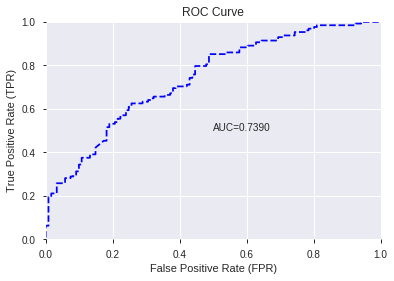

This function is available for GLM models only


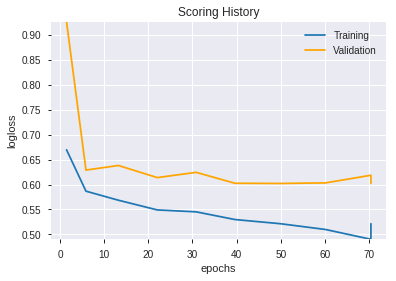

--2019-08-27 22:12:43--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.114.155
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.114.155|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190827_220410_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190827_220410_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_8479',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'CDLCLOSINGMARUBOZU',
 'TRANGE',
 'CDLBELTHOLD',
 'CDLLONGLINE',
 'STOCHF_fastk',
 'DX_14',
 'PLUS_DI_30',
 'CDLHIGHWAVE',
 'ADOSC',
 'aroondown_14',
 'ULTOSC',
 'STOCH_slowk',
 'HT_PHASOR_quadrature',
 'STOCH_slowd',
 'MINUS_DI_14',
 'aroonup_8',
 'DX_20',
 'STDDEV_8',
 'CCI_14',
 'BETA_20',
 'ATR_30',
 'MFI_8',
 'BETA_8',
 'HT_PHASOR_inphase',
 'BETA_12',
 'aroondown_8',
 'MACDEXT',
 'aroonup_30',
 'STDDEV_14',
 'ATR_12',
 'ROCR_24',
 'MINUS_DM_12',
 'BETA_14',
 'MOM_8',
 'WILLR_14',
 'MACDFIX_signal_24',
 'WILLR_24',
 'CCI_8',
 'RSI_8',
 'ROCP_14',
 'aroondown_20',
 'CMO_14',
 'TRIX_8',
 'CCI_24',
 'aroonup_14',
 'ROCR_20',
 'WILLR_30',
 'ROCP_30',
 'aroonup_24',
 'LINEARREG_SLOPE_14',
 'CMO_30',
 'LINEARREG_ANGLE_14',
 'aroonup_12',
 'BBANDS_lowerband_14_5_2',
 'MACDFIX_20',
 'CMO_24',
 'ROCR_14',
 'MOM_12',
 'MFI_30',
 'BBANDS_upperband_20_2_4',
 'BBANDS_upperband_20_6_2',
 'BBANDS_upperband_20_1_2',
 'MACDFIX_hist_12',
 'ROCR_12',
 'BBANDS_upperband_14_7_3',
 'LINEARREG_

In [51]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190827_221339_model_1  0.722882  0.674451              0.309756  0.488284  0.238421

variable  relative_importance  scaled_importance  percentage
0                       BOP             0.398167           1.000000    0.118097
1                    TRANGE             0.163600           0.410882    0.048524
2              STOCHF_fastk             0.155133           0.389617    0.046012
3        CDLCLOSINGMARUBOZU             0.146152           0.367062    0.043349
4               CDLBELTHOLD             0.121974           0.306340    0.036178
..                      ...                  ...                ...         ...
68  BBANDS_lowerband_20_5_3             0.001692           0.004251    0.000502
69                  BETA_12             0.001481           0.003720    0.000439
70        MACDFIX_signal_24             0.001321           0.003318    0.000392
71  BBANDS_lowerband_24_1_4             0.001185           0.002977    0.000352
72                    TSF_8             0.000213           0.000535    0.000063

[73 rows x 4 columns]

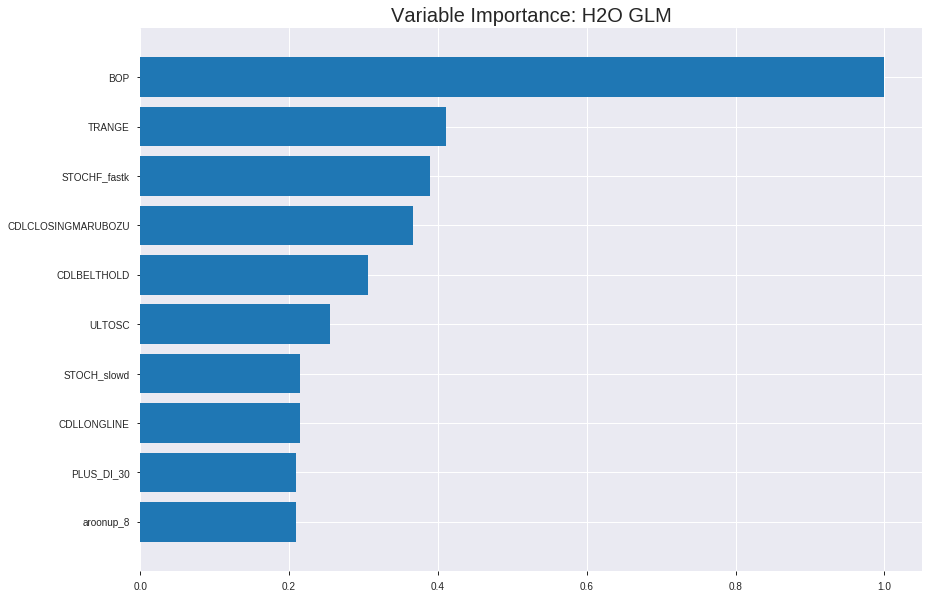

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190827_221339_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.19712525377115803
RMSE: 0.44398789822601925
LogLoss: 0.5790872404669656
Null degrees of freedom: 1740
Residual degrees of freedom: 1667
Null deviance: 2411.5386742145683
Residual deviance: 2016.381771305974
AIC: 2164.3817713059743
AUC: 0.7727685295283393
pr_auc: 0.7732338534983194
Gini: 0.5455370590566786
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4000988514889776: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      378  463   0.5505   (463.0/841.0)
1      86   814   0.0956   (86.0/900.0)
Total  464  1277  0.3153   (549.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.400099     0.747818  266
max f2                       0.222202     0.848857  350
max f0point5                 0.565809     0.721741  167
max accuracy                 0.501148     0.707065  206
max precision                0.923468     1         0
max recall                   0.147787     1         383
max specificity              0.923468     1         0
max absolute_mcc             0.501148     0.413051  206
max min_per_class_accuracy   0.524121     0.700357  191
max mean_per_class_accuracy  0.501148     0.705598  206

Gains/Lift Table: Avg response rate: 51.69 %, avg score: 51.69 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.880751           1.82698   1.82698            0.944444         0.895826  0.944444                    0.895826            0.0188889       0.0188889                  82.6975   82.6975
    2        0.0201034                   0.864396           1.93444   1.87917            1                0.872313  0.971429                    0.884405            0.0188889       0.0377778                  93.4444   87.9175
    3        0.0304423                   0.842961           1.71951   1.82495            0.888889         0.853975  0.943396                    0.87407             0.0177778       0.0555556                  71.9506   82.4948
    4        0.0402068                   0.816818           1.82065   1.8239             0.941176         0.832166  0.942857                    0.863894            0.0177778       0.0733333                  82.0654   82.3905
    5        0.0505457                   0.806509           1.61204   1.78057            0.833333         0.810678  0.920455                    0.853009            0.0166667       0.09                       61.2037   78.0568
    6        0.100517                    0.752241           1.64539   1.71337            0.850575         0.778282  0.885714                    0.815859            0.0822222       0.172222                   64.539    71.3365
    7        0.150488                    0.709641           1.48974   1.63911            0.770115         0.729611  0.847328                    0.787219            0.0744444       0.246667                   48.9745   63.9109
    8        0.20046                     0.677061           1.44527   1.59079            0.747126         0.692873  0.82235                     0.7637              0.0722222       0.318889                   44.5275   59.079
    9        0.300402                    0.627123           1.37857   1.52018            0.712644         0.651869  0.785851                    0.726494            0.137778        0.456667                   37.857    52.0185
    10       0.400345                    0.577457           1.28963   1.46263            0.666667         0.60333   0.756098                    0.695748            0.128889        0.585556                   28.963    46.2629
    11       0.500287                    0.528143           1.0784    1.38587            0.557471         0.555012  0.716418                    0.667633            0.107778        0.693333                   7.83972   38.5871
    12       0.60023                     0.475003           0.97834   1.31801            0.505747         0.500072  0.68134                     0.639733            0.0977778       0.791111                   -2.16603  31.8014
    13       0.700172                    0.418014           0.856047  1.25207            0.442529         0.447935  0.647252                    0.612355            0.0855556       0.876667                   -14.3953  25.2073
    14       0.800115                    0.350969           0.555875  1.16511            0.287356         0.386344  0.602297                    0.584124            0.0555556       0.932222                   -44.4125  16.511
    15       0.900057                    0.247644           0.389112  1.07894            0.201149         0.305781  0.557754                    0.553217            0.0388889       0.971111                   -61.0888  7.89435
    16       1                           0.0488628          0.289055  1                  0.149425         0.190282  0.516944                    0.516944           



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.21082248637374745
RMSE: 0.45915409872258295
LogLoss: 0.61029592693748
Null degrees of freedom: 497
Residual degrees of freedom: 424
Null deviance: 688.6415356931332
Residual deviance: 607.8547432297302
AIC: 755.8547432297302
AUC: 0.7444500259268862
pr_auc: 0.7325164760946508
Gini: 0.4889000518537725
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.33408431976596176: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      102  130  0.5603   (130.0/232.0)
1      26   240  0.0977   (26.0/266.0)
Total  128  370  0.3133   (156.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.334084     0.754717  288
max f2                       0.175014     0.860927  356
max f0point5                 0.469627     0.728314  188
max accuracy                 0.469627     0.700803  188
max precision                0.883951     1         0
max recall                   0.0338967    1         398
max specificity              0.883951     1         0
max absolute_mcc             0.469627     0.405621  188
max min_per_class_accuracy   0.447047     0.698276  202
max mean_per_class_accuracy  0.469627     0.703121  188

Gains/Lift Table: Avg response rate: 53.41 %, avg score: 45.78 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0100402                   0.830675           1.87218   1.87218            1                0.871441  1                           0.871441            0.018797        0.018797                   87.218     87.218
    2        0.0200803                   0.815394           1.87218   1.87218            1                0.825523  1                           0.848482            0.018797        0.037594                   87.218     87.218
    3        0.0301205                   0.79978            1.49774   1.74737            0.8              0.809139  0.933333                    0.835368            0.0150376       0.0526316                  49.7744    74.7368
    4        0.0401606                   0.793752           1.49774   1.68496            0.8              0.797768  0.9                         0.825968            0.0150376       0.0676692                  49.7744    68.4962
    5        0.0502008                   0.785657           1.12331   1.57263            0.6              0.789893  0.84                        0.818753            0.0112782       0.0789474                  12.3308    57.2632
    6        0.100402                    0.722671           1.12331   1.34797            0.6              0.753346  0.72                        0.78605             0.056391        0.135338                   12.3308    34.797
    7        0.150602                    0.67732            1.64752   1.44782            0.88             0.697543  0.773333                    0.756547            0.0827068       0.218045                   64.7519    44.782
    8        0.200803                    0.63522            1.42286   1.44158            0.76             0.6558    0.77                        0.731361            0.0714286       0.289474                   42.2857    44.1579
    9        0.301205                    0.579631           1.31053   1.39789            0.7              0.605298  0.746667                    0.68934             0.131579        0.421053                   31.0526    39.7895
    10       0.399598                    0.512856           1.4519    1.41119            0.77551          0.547055  0.753769                    0.654305            0.142857        0.56391                    45.1895    41.1191
    11       0.5                         0.450837           1.1982    1.36842            0.64             0.484833  0.730924                    0.620274            0.120301        0.684211                   19.8195    36.8421
    12       0.600402                    0.404484           0.823759  1.27734            0.44             0.42724   0.682274                    0.587994            0.0827068       0.766917                   -17.6241   27.7341
    13       0.698795                    0.358246           0.993402  1.23736            0.530612         0.382736  0.66092                     0.559093            0.0977444       0.864662                   -0.659813  23.7361
    14       0.799197                    0.293261           0.673985  1.16658            0.36             0.327129  0.623116                    0.529952            0.0676692       0.932331                   -32.6015   16.6585
    15       0.899598                    0.16798            0.449323  1.08653            0.24             0.231829  0.580357                    0.496679            0.0451128       0.977444                   -55.0677   8.65333
    16       1                           0.029889           0.224662  1                  0.12             0.109233  0.534137                    0.45


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-27 22:13:39  0.000 sec   2            21        74            1.37118           1.36757
    2019-08-27 22:13:39  0.015 sec   4            13        74            1.36385           1.3601
    2019-08-27 22:13:39  0.027 sec   6            8.2       74            1.35331           1.34989
    2019-08-27 22:13:39  0.041 sec   8            5.1       74            1.3388            1.33662
    2019-08-27 22:13:39  0.052 sec   10           3.2       74            1.31986           1.32032
    2019-08-27 22:13:39  0.063 sec   12           2         74            1.29677           1.30174
    2019-08-27 22:13:39  0.077 sec   14           1.2       74            1.27086           1.2823
    2019-08-27 22:13:40  0.089 sec   16           0.76      74            1.24411           1.26356
    2019-08-27 22:13:40  0.101 sec   18           0.47      74            1.21845           1.24712
    2019-08-27 22:13:40  0.113 sec   20           0.29      74            1.19523           1.234
    2019-08-27 22:13:40  0.126 sec   22           0.18      74            1.17509           1.22495
    2019-08-27 22:13:40  0.141 sec   24           0.11      74            1.15817           1.22059
    2019-08-27 22:13:40  0.157 sec   26           0.07      74            1.14439           1.22127
    2019-08-27 22:13:40  0.171 sec   28           0.043     74            1.13352           1.22702
    2019-08-27 22:13:40  0.184 sec   30           0.027     74            1.12525           1.23683
    2019-08-27 22:13:40  0.196 sec   32           0.017     74            1.1191            1.25037
    2019-08-27 22:13:40  0.208 sec   34           0.01      74            1.11466           1.2671

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6947791164658634)

('F1', 0.7414965986394557)

('auc', 0.7228822314049587)

('logloss', 0.6744509335993506)

('mean_per_class_error', 0.30885201446280997)

('rmse', 0.4882841593940212)

('mse', 0.23842142031512592)

glm prediction progress: |████████████████████████████████████████████████| 100%


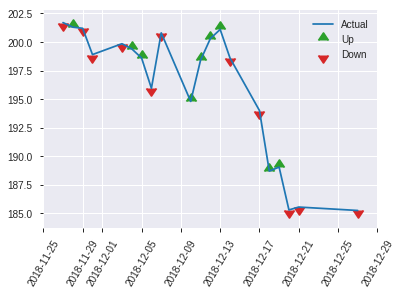


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.23842142031512592
RMSE: 0.4882841593940212
LogLoss: 0.6744509335993506
Null degrees of freedom: 248
Residual degrees of freedom: 175
Null deviance: 344.9987988800806
Residual deviance: 335.8765649324766
AIC: 483.8765649324766
AUC: 0.7228822314049587
pr_auc: 0.7106382725618694
Gini: 0.44576446280991733
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2527270554863285: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      64   57   0.4711   (57.0/121.0)
1      19   109  0.1484   (19.0/128.0)
Total  83   166  0.3052   (76.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.252727     0.741497  165
max f2                       0.130551     0.85282   214
max f0point5                 0.265431     0.690789  157
max accuracy                 0.265431     0.694779  157
max precision                0.832715     1         0
max recall                   0.0309963    1         246
max specificity              0.832715     1         0
max absolute_mcc             0.252727     0.403409  165
max min_per_class_accuracy   0.341803     0.640625  124
max mean_per_class_accuracy  0.265431     0.691148  157

Gains/Lift Table: Avg response rate: 51.41 %, avg score: 35.36 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.796143           1.29688   1.29688            0.666667         0.820881   0.666667                    0.820881            0.015625        0.015625                   29.6875   29.6875
    2        0.0200803                   0.781086           1.94531   1.55625            1                0.785168   0.8                         0.806596            0.015625        0.03125                    94.5313   55.625
    3        0.0321285                   0.75825            1.94531   1.70215            1                0.771857   0.875                       0.793569            0.0234375       0.0546875                  94.5313   70.2148
    4        0.0401606                   0.726687           1.94531   1.75078            1                0.749306   0.9                         0.784716            0.015625        0.0703125                  94.5313   75.0781
    5        0.0522088                   0.70503            1.94531   1.79567            1                0.715472   0.923077                    0.768737            0.0234375       0.09375                    94.5313   79.5673
    6        0.100402                    0.626194           1.29688   1.55625            0.666667         0.673198   0.8                         0.722878            0.0625          0.15625                    29.6875   55.625
    7        0.15261                     0.56266            1.94531   1.68935            1                0.591217   0.868421                    0.677836            0.101562        0.257812                   94.5313   68.935
    8        0.200803                    0.508379           0.972656  1.51734            0.5              0.534789   0.78                        0.643505            0.046875        0.304688                   -2.73437  51.7344
    9        0.301205                    0.447615           1.01156   1.34875            0.52             0.475321   0.693333                    0.587444            0.101562        0.40625                    1.15625   34.875
    10       0.401606                    0.389249           1.245     1.32281            0.64             0.417568   0.68                        0.544975            0.125           0.53125                    24.5      32.2813
    11       0.502008                    0.341803           1.08938   1.27613            0.56             0.367968   0.656                       0.509573            0.109375        0.640625                   8.9375    27.6125
    12       0.598394                    0.28149            1.21582   1.26641            0.625            0.311432   0.651007                    0.477658            0.117188        0.757812                   21.582    26.6411
    13       0.698795                    0.239101           1.08938   1.24098            0.56             0.258287   0.637931                    0.446139            0.109375        0.867188                   8.9375    24.0975
    14       0.799197                    0.176608           0.466875  1.14373            0.24             0.208576   0.58794                     0.416295            0.046875        0.914062                   -53.3125  14.3726
    15       0.899598                    0.108843           0.544688  1.07687            0.28             0.141239   0.553571                    0.385596            0.0546875       0.96875                    -45.5312  7.68694
    16       1                           0.00840425         0.31125   1                  0.16             0.0667977  0.514056                    0.3

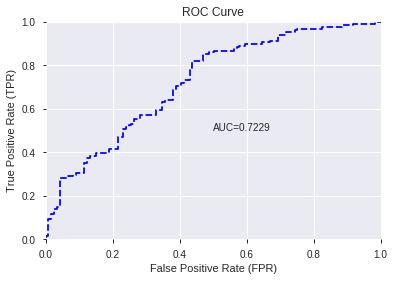

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


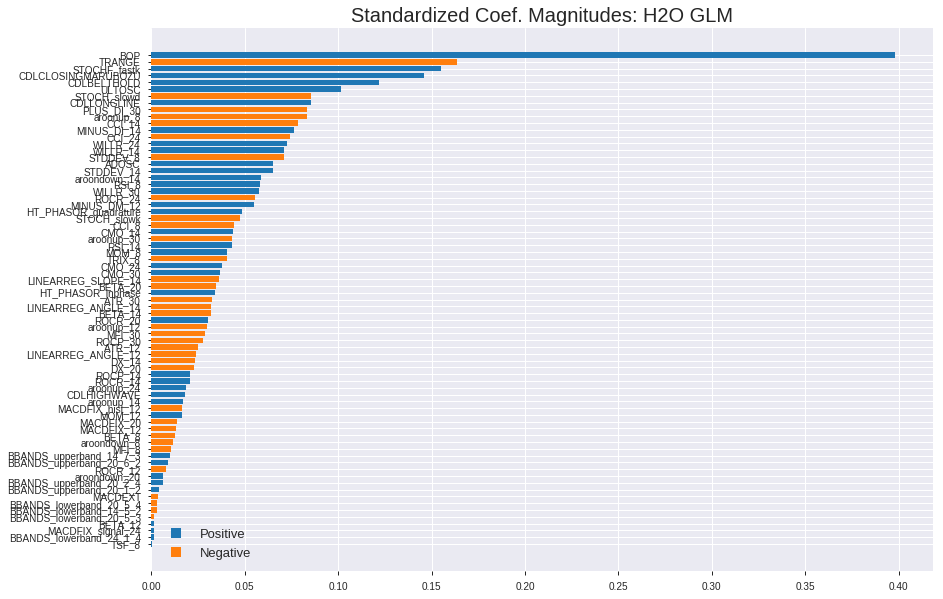

'log_likelihood'
--2019-08-27 22:13:50--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.145.235
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.145.235|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190827_221339_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190827_221339_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_8479',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['BOP',
 'TRANGE',
 'STOCHF_fastk',
 'CDLCLOSINGMARUBOZU',
 'CDLBELTHOLD',
 'ULTOSC',
 'STOCH_slowd',
 'CDLLONGLINE',
 'PLUS_DI_30',
 'aroonup_8',
 'CCI_14',
 'MINUS_DI_14',
 'CCI_24',
 'WILLR_24',
 'WILLR_14',
 'STDDEV_8',
 'ADOSC',
 'STDDEV_14',
 'aroondown_14',
 'RSI_8',
 'WILLR_30',
 'ROCR_24',
 'MINUS_DM_12',
 'HT_PHASOR_quadrature',
 'STOCH_slowk',
 'CCI_8',
 'CMO_14',
 'aroonup_30',
 'RSI_14',
 'MOM_8',
 'TRIX_8',
 'CMO_24',
 'CMO_30',
 'LINEARREG_SLOPE_14',
 'BETA_20',
 'HT_PHASOR_inphase',
 'ATR_30',
 'LINEARREG_ANGLE_14',
 'BETA_14',
 'ROCR_20',
 'aroonup_12',
 'MFI_30',
 'ROCP_30',
 'ATR_12',
 'LINEARREG_ANGLE_12',
 'DX_14',
 'DX_20',
 'ROCP_14',
 'ROCR_14',
 'aroonup_24',
 'CDLHIGHWAVE',
 'aroonup_14',
 'MACDFIX_hist_12',
 'MOM_12',
 'MACDFIX_20',
 'MACDFIX_12',
 'BETA_8',
 'aroondown_8',
 'MFI_8',
 'BBANDS_upperband_14_7_3',
 'BBANDS_upperband_20_6_2',
 'ROCR_12',
 'aroondown_20',
 'BBANDS_upperband_20_2_4',
 'BBANDS_upperband_20_1_2',
 'MACDEXT',
 'BBANDS_lowerband_20_5_4

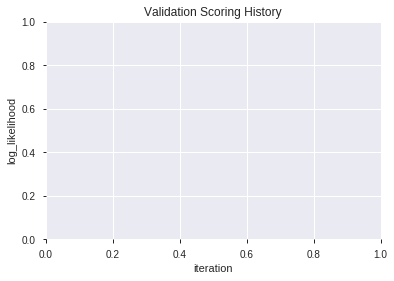

In [52]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190827_221447_model_3  0.737862  0.601740              0.369415  0.455400  0.207389
1  XGBoost_grid_1_AutoML_20190827_221447_model_5  0.737087  0.613329              0.333645  0.459705  0.211329
2  XGBoost_grid_1_AutoML_20190827_221447_model_7  0.735085  0.613778              0.377002  0.460082  0.211676
3  XGBoost_grid_1_AutoML_20190827_221447_model_6  0.733923  0.610025              0.361151  0.458857  0.210550
4  XGBoost_grid_1_AutoML_20190827_221447_model_1  0.731114  0.613532              0.347172  0.460127  0.211717
5               XGBoost_3_AutoML_20190827_221447  0.729081  0.615211              0.334549  0.460862  0.212394
6               XGBoost_2_AutoML_20190827_221447  0.723915  0.618709              0.338908  0.461751  0.213214
7  XGBoost_grid_1_AutoML_20190827_221447_model_4  0.716942  0.618591              0.347398  0.462713  0.214104
8  XGBoost_grid_1_AutoML_20190827_221447_model_2  0.708484  0.626927              0.347398  0.467040  0.218126
9               XGBoost_1_AutoML_20190827_221447  0.707515  0.633954              0.403151  0.469400  0.220336

variable  relative_importance  scaled_importance  percentage
0                       BOP          1875.041504           1.000000    0.236713
1                    TRANGE           497.533020           0.265345    0.062811
2              STOCHF_fastk           436.752380           0.232929    0.055138
3                    CCI_14           242.417343           0.129286    0.030604
4                     ADOSC           193.066040           0.102966    0.024373
..                      ...                  ...                ...         ...
67                   CMO_14            21.427483           0.011428    0.002705
68  BBANDS_upperband_14_7_3            17.253298           0.009202    0.002178
69                   RSI_14            15.862719           0.008460    0.002003
70               MACDFIX_12            15.313419           0.008167    0.001933
71                aroonup_8            12.427605           0.006628    0.001569

[72 rows x 4 columns]

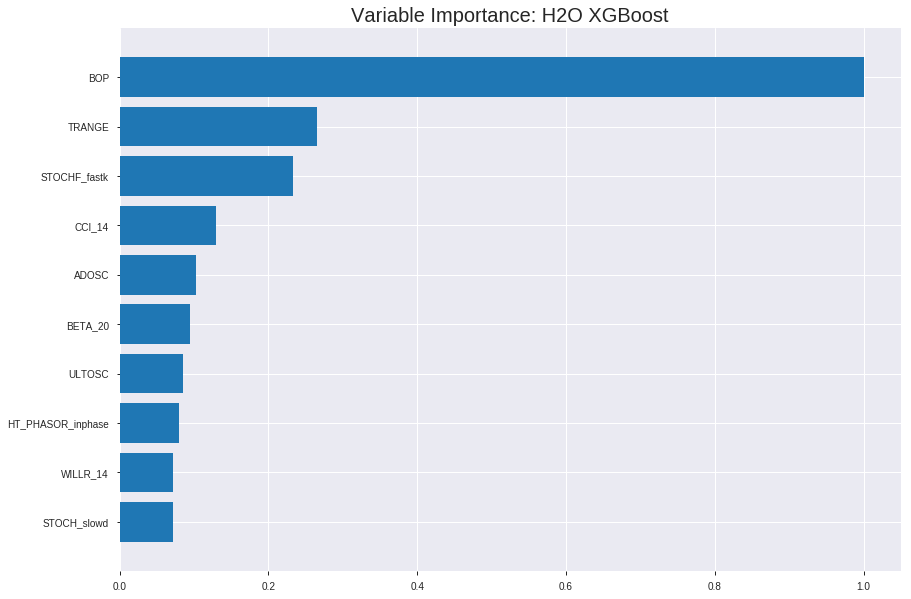

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190827_221447_model_3


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.13501652517379187
RMSE: 0.36744594864250696
LogLoss: 0.43707381806298645
Mean Per-Class Error: 0.1618892852424363
AUC: 0.922541947417096
pr_auc: 0.9287949750736534
Gini: 0.8450838948341921
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48729000240564346: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      652  189  0.2247   (189.0/841.0)
1      103  797  0.1144   (103.0/900.0)
Total  755  986  0.1677   (292.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.48729      0.845175  217
max f2                       0.31287      0.90419   297
max f0point5                 0.633811     0.866591  139
max accuracy                 0.541028     0.838024  191
max precision                0.916087     1         0
max recall                   0.208528     1         346
max specificity              0.916087     1         0
max absolute_mcc             0.541028     0.67594   191
max min_per_class_accuracy   0.538041     0.836667  192
max mean_per_class_accuracy  0.541028     0.838111  191

Gains/Lift Table: Avg response rate: 51.69 %, avg score: 51.85 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.888831           1.93444   1.93444            1                0.90241   1                           0.90241             0.02            0.02                       93.4444   93.4444
    2        0.0201034                   0.876641           1.93444   1.93444            1                0.883458  1                           0.893205            0.0188889       0.0388889                  93.4444   93.4444
    3        0.0304423                   0.86873            1.93444   1.93444            1                0.872435  1                           0.886151            0.02            0.0588889                  93.4444   93.4444
    4        0.0402068                   0.858074           1.93444   1.93444            1                0.864201  1                           0.88082             0.0188889       0.0777778                  93.4444   93.4444
    5        0.0505457                   0.850143           1.93444   1.93444            1                0.854046  1                           0.875344            0.02            0.0977778                  93.4444   93.4444
    6        0.100517                    0.816185           1.91221   1.92339            0.988506         0.834086  0.994286                    0.854833            0.0955556       0.193333                   91.2209   92.339
    7        0.150488                    0.781317           1.93444   1.92706            1                0.800915  0.996183                    0.836929            0.0966667       0.29                       93.4444   92.7061
    8        0.20046                     0.747131           1.91221   1.92336            0.988506         0.764044  0.994269                    0.81876             0.0955556       0.385556                   91.2209   92.3359
    9        0.300402                    0.681786           1.75656   1.86787            0.908046         0.714058  0.965583                    0.783926            0.175556        0.561111                   75.6564   86.7867
    10       0.400345                    0.612655           1.41192   1.75404            0.729885         0.647365  0.906743                    0.749835            0.141111        0.702222                   41.1922   75.4044
    11       0.500287                    0.543621           1.22292   1.64794            0.632184         0.577068  0.851894                    0.715321            0.122222        0.824444                   22.2925   64.7942
    12       0.60023                     0.459555           0.84493   1.51423            0.436782         0.500703  0.782775                    0.679586            0.0844444       0.908889                   -15.507   51.4235
    13       0.700172                    0.363891           0.544757  1.37585            0.281609         0.415121  0.711239                    0.641836            0.0544444       0.963333                   -45.5243  37.5852
    14       0.800115                    0.26713            0.277937  1.23871            0.143678         0.316545  0.640345                    0.601204            0.0277778       0.991111                   -72.2063  23.8711
    15       0.900057                    0.19319            0.08894   1.11104            0.045977         0.228492  0.574346                    0.559818            0.00888889      1                          -91.106   11.104
    16       1                           0.0815933          0         1                  0                0.146037  0.516944                    0.518464           



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.20512268390075047
RMSE: 0.45290471834675167
LogLoss: 0.5998556241321595
Mean Per-Class Error: 0.29880736323567536
AUC: 0.7414846383199378
pr_auc: 0.7232075727416389
Gini: 0.48296927663987566
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37383513152599335: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      108  124  0.5345   (124.0/232.0)
1      33   233  0.1241   (33.0/266.0)
Total  141  357  0.3153   (157.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.373835     0.747994  283
max f2                       0.214154     0.85733   366
max f0point5                 0.558184     0.725938  193
max accuracy                 0.531871     0.700803  204
max precision                0.896343     1         0
max recall                   0.158142     1         393
max specificity              0.896343     1         0
max absolute_mcc             0.531871     0.401498  204
max min_per_class_accuracy   0.531871     0.695489  204
max mean_per_class_accuracy  0.531871     0.701193  204

Gains/Lift Table: Avg response rate: 53.41 %, avg score: 52.96 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100402                   0.878843           1.87218   1.87218            1                0.888904  1                           0.888904            0.018797        0.018797                   87.218    87.218
    2        0.0200803                   0.871009           1.12331   1.49774            0.6              0.875423  0.8                         0.882164            0.0112782       0.0300752                  12.3308   49.7744
    3        0.0301205                   0.86677            0.748872  1.24812            0.4              0.869253  0.666667                    0.87786             0.0075188       0.037594                   -25.1128  24.812
    4        0.0401606                   0.856371           0.748872  1.12331            0.4              0.863885  0.6                         0.874366            0.0075188       0.0451128                  -25.1128  12.3308
    5        0.0502008                   0.854711           1.87218   1.27308            1                0.855415  0.68                        0.870576            0.018797        0.0639098                  87.218    27.3083
    6        0.100402                    0.82311            1.49774   1.38541            0.8              0.839343  0.74                        0.85496             0.075188        0.139098                   49.7744   38.5414
    7        0.150602                    0.78482            1.57263   1.44782            0.84             0.80182   0.773333                    0.837246            0.0789474       0.218045                   57.2632   44.782
    8        0.200803                    0.739419           1.64752   1.49774            0.88             0.760973  0.8                         0.818178            0.0827068       0.300752                   64.7519   49.7744
    9        0.301205                    0.675247           1.34797   1.44782            0.72             0.707866  0.773333                    0.781408            0.135338        0.43609                    34.797    44.782
    10       0.399598                    0.605546           1.33727   1.4206             0.714286         0.636734  0.758794                    0.745784            0.131579        0.567669                   33.7272   42.0599
    11       0.5                         0.534558           1.16075   1.36842            0.62             0.576773  0.730924                    0.711846            0.116541        0.684211                   16.0752   36.8421
    12       0.600402                    0.468268           0.786316  1.27108            0.42             0.50346   0.67893                     0.676999            0.0789474       0.763158                   -21.3684  27.1079
    13       0.698795                    0.386065           0.955194  1.2266             0.510204         0.42716   0.655172                    0.641821            0.093985        0.857143                   -4.48059  22.6601
    14       0.799197                    0.305923           0.599098  1.14777            0.32             0.345625  0.613065                    0.60461             0.0601504       0.917293                   -40.0902  14.7769
    15       0.899598                    0.228572           0.486767  1.074              0.26             0.270466  0.573661                    0.567317            0.0488722       0.966165                   -51.3233  7.39964
    16       1                           0.104587           0.336992  1                  0.18             0.191173  0.534137                    0.529552            0


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 22:14:54  2.217 sec   0                  0.5              0.693147            0.5             0                  1                0.483056                         0.5                0.693147              0.5               0                    1                  0.465863
    2019-08-27 22:14:54  2.363 sec   5                  0.472886         0.640023            0.827366        0.830451           1.93444          0.269385                         0.482155           0.657862              0.721002          0.71758              1.49774            0.323293
    2019-08-27 22:14:54  2.441 sec   10                 0.453541         0.602873            0.847054        0.852396           1.93444          0.240666                         0.472179           0.638169              0.72874           0.733186             1.87218            0.319277
    2019-08-27 22:14:54  2.534 sec   15                 0.439223         0.575267            0.853779        0.859906           1.93444          0.236071                         0.463757           0.621492              0.742368          0.741297             1.87218            0.331325
    2019-08-27 22:14:55  2.615 sec   20                 0.426863         0.55122             0.86255         0.869744           1.93444          0.225732                         0.458384           0.610502              0.743178          0.741808             1.87218            0.315261
    2019-08-27 22:14:55  2.703 sec   25                 0.415669         0.529651            0.876646        0.885631           1.93444          0.208501                         0.45678            0.606798              0.742595          0.739313             1.87218            0.325301
    2019-08-27 22:14:55  2.785 sec   30                 0.406749         0.511857            0.880268        0.888355           1.93444          0.20448                          0.455111           0.603005              0.744507          0.738815             1.87218            0.313253
    2019-08-27 22:14:55  2.873 sec   35                 0.399137         0.496782            0.887372        0.896016           1.93444          0.198162                         0.45373            0.599977              0.745382          0.732562             1.49774            0.327309
    2019-08-27 22:14:55  2.970 sec   40                 0.391587         0.482563            0.897097        0.903216           1.93444          0.193567                         0.454322           0.600782              0.744004          0.732366             1.87218            0.323293
    2019-08-27 22:14:55  3.067 sec   45                 0.385122         0.470067            0.903756        0.909972           1.93444          0.183228                         0.455005           0.602947              0.743591          0.723149             1.49774            0.305221
    2019-08-27 22:14:55  3.158 sec   50                 0.379151         0.458865            0.910406        0.915866           1.93444          0.17691                          0.454353           0.601905              0.742384          0.722151             1.87218            0.315261
    2019-08-27 22:14:55  3.261 sec   55                 0.373304         0.447679            0.915883        0.923611           1.93444          0.168868                         0.453098           0.599913              0.742206          0

Variable Importances: 


variable                 relative_importance    scaled_importance     percentage
-----------------------  ---------------------  --------------------  ---------------------
BOP                      1875.04150390625       1.0                   0.23671333654559717
TRANGE                   497.53302001953125     0.265345070486721     0.0628107169708384
STOCHF_fastk             436.75238037109375     0.23292944687422285   0.05513750654931771
CCI_14                   242.41734313964844     0.12928638786641442   0.030603812241787168
ADOSC                    193.0660400390625      0.1029662754860895    0.024373490621985378
---                      ---                    ---                   ---
CMO_14                   21.42748260498047      0.011427737764919265  0.002705097935502165
BBANDS_upperband_14_7_3  17.253297805786133     0.009201555149495388  0.0021781308208453747
RSI_14                   15.86271858215332      0.008459929313088121  0.0020025780946409913
MACDFIX_12               15.313419342041016     0.008166976203000715  0.0019332321865007916
aroonup_8                12.427604675292969     0.006627909115293021  0.001568914481001988


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6907630522088354)

('F1', 0.7222222222222222)

('auc', 0.7378615702479339)

('logloss', 0.6017404465332501)

('mean_per_class_error', 0.30891658057851235)

('rmse', 0.45539970610170555)

('mse', 0.2073888923175198)

xgboost prediction progress: |████████████████████████████████████████████| 100%


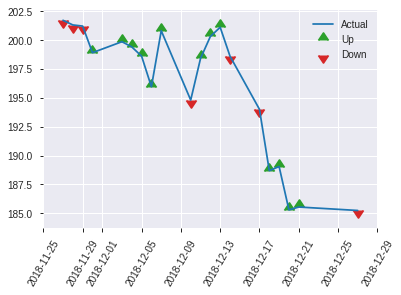


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2073888923175198
RMSE: 0.45539970610170555
LogLoss: 0.6017404465332501
Mean Per-Class Error: 0.30891658057851235
AUC: 0.7378615702479339
pr_auc: 0.7489542316082122
Gini: 0.4757231404958677
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3005426526069641: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      42   79   0.6529   (79.0/121.0)
1      11   117  0.0859   (11.0/128.0)
Total  53   196  0.3614   (90.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.300543     0.722222  195
max f2                       0.172122     0.848806  241
max f0point5                 0.590857     0.71875   87
max accuracy                 0.510005     0.690763  122
max precision                0.886284     1         0
max recall                   0.172122     1         241
max specificity              0.886284     1         0
max absolute_mcc             0.590857     0.399438  87
max min_per_class_accuracy   0.503072     0.6875    124
max mean_per_class_accuracy  0.510005     0.691083  122

Gains/Lift Table: Avg response rate: 51.41 %, avg score: 49.84 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.860744           1.94531   1.94531            1                0.870062  1                           0.870062            0.0234375       0.0234375                  94.5313   94.5313
    2        0.0200803                   0.853478           1.94531   1.94531            1                0.85726   1                           0.864941            0.015625        0.0390625                  94.5313   94.5313
    3        0.0321285                   0.846981           1.94531   1.94531            1                0.851995  1                           0.860086            0.0234375       0.0625                     94.5313   94.5313
    4        0.0401606                   0.836492           1.94531   1.94531            1                0.842665  1                           0.856602            0.015625        0.078125                   94.5313   94.5313
    5        0.0522088                   0.821764           1.29688   1.79567            0.666667         0.830661  0.923077                    0.850616            0.015625        0.09375                    29.6875   79.5673
    6        0.100402                    0.767521           1.62109   1.71188            0.833333         0.798722  0.88                        0.825707            0.078125        0.171875                   62.1094   71.1875
    7        0.15261                     0.737884           1.49639   1.63816            0.769231         0.750995  0.842105                    0.800147            0.078125        0.25                       49.6394   63.8158
    8        0.200803                    0.693524           1.13477   1.51734            0.583333         0.717631  0.78                        0.780343            0.0546875       0.304688                   13.4766   51.7344
    9        0.301205                    0.630211           1.32281   1.4525             0.68             0.665172  0.746667                    0.741953            0.132812        0.4375                     32.2813   45.25
    10       0.401606                    0.566882           1.40063   1.43953            0.72             0.596941  0.74                        0.7057              0.140625        0.578125                   40.0625   43.9531
    11       0.502008                    0.503072           1.08938   1.3695             0.56             0.532813  0.704                       0.671123            0.109375        0.6875                     8.9375    36.95
    12       0.598394                    0.435184           0.567383  1.2403             0.291667         0.471559  0.637584                    0.638978            0.0546875       0.742188                   -43.2617  24.03
    13       0.698795                    0.366612           1.01156   1.20744            0.52             0.396846  0.62069                     0.604189            0.101562        0.84375                    1.15625   20.7435
    14       0.799197                    0.284147           0.700313  1.14373            0.36             0.32548   0.58794                     0.569175            0.0703125       0.914062                   -29.9688  14.3726
    15       0.899598                    0.22329            0.389063  1.0595             0.2              0.249776  0.544643                    0.533528            0.0390625       0.953125                   -61.0937  5.95006
    16       1                           0.139708           0.466875  1                  0.24             0.183928  0.514056                    0.498428            0.0

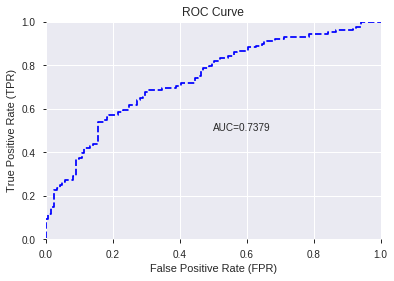

This function is available for GLM models only


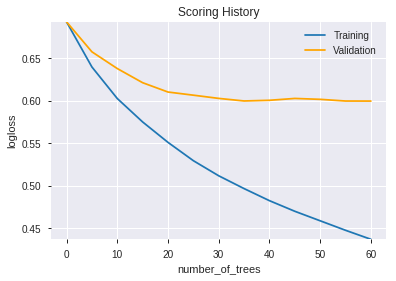

--2019-08-27 22:15:14--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 54.231.49.72
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|54.231.49.72|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.ge

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190827_221447_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190827_221447_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_8479',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_trainin

['BOP',
 'TRANGE',
 'STOCHF_fastk',
 'CCI_14',
 'ADOSC',
 'BETA_20',
 'ULTOSC',
 'HT_PHASOR_inphase',
 'WILLR_14',
 'STOCH_slowd',
 'HT_PHASOR_quadrature',
 'CCI_8',
 'BETA_14',
 'MACDFIX_hist_12',
 'LINEARREG_ANGLE_14',
 'MFI_8',
 'CDLCLOSINGMARUBOZU',
 'BETA_8',
 'CDLBELTHOLD',
 'ATR_30',
 'WILLR_24',
 'ROCP_30',
 'MOM_8',
 'MOM_12',
 'aroonup_30',
 'DX_20',
 'MINUS_DI_14',
 'STDDEV_8',
 'ROCR_12',
 'PLUS_DI_30',
 'ROCR_24',
 'WILLR_30',
 'ROCR_20',
 'STDDEV_14',
 'aroondown_14',
 'BETA_12',
 'aroonup_24',
 'ATR_12',
 'aroonup_14',
 'CCI_24',
 'DX_14',
 'MFI_30',
 'LINEARREG_ANGLE_12',
 'MINUS_DM_12',
 'MACDEXT',
 'TRIX_8',
 'CMO_24',
 'MACDFIX_20',
 'ROCP_14',
 'BBANDS_lowerband_20_5_4',
 'CMO_30',
 'aroondown_20',
 'ROCR_14',
 'CDLLONGLINE',
 'MACDFIX_signal_24',
 'BBANDS_upperband_20_1_2',
 'aroonup_12',
 'LINEARREG_SLOPE_14',
 'BBANDS_lowerband_20_5_3',
 'RSI_8',
 'BBANDS_lowerband_14_5_2',
 'BBANDS_lowerband_24_1_4',
 'BBANDS_upperband_20_2_4',
 'TSF_8',
 'aroondown_8',
 'STOCH_

In [53]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [54]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.687
GLM             0.695
XGBoost         0.703
dtype: float64

DeepLearning    GLM  XGBoost
All          0.514  0.514    0.703
DLF          0.671  0.675    0.679
Fwe          0.679  0.655    0.671
RFE          0.687  0.695    0.691
XGBF         0.667  0.675    0.679





F1


DeepLearning    0.737
GLM             0.752
XGBoost         0.745
dtype: float64

DeepLearning    GLM  XGBoost
All          0.679  0.679    0.745
DLF          0.737  0.752    0.713
Fwe          0.726  0.723    0.727
RFE          0.736  0.741    0.722
XGBF         0.727  0.752    0.713





auc


DeepLearning    0.739
GLM             0.723
XGBoost         0.738
dtype: float64

DeepLearning    GLM  XGBoost
All          0.500  0.500    0.738
DLF          0.706  0.717    0.725
Fwe          0.720  0.716    0.730
RFE          0.739  0.723    0.738
XGBF         0.719  0.717    0.725





logloss


DeepLearning    16.784
GLM             16.784
XGBoost          0.621
dtype: float64

DeepLearning     GLM  XGBoost
All         16.784  16.784    0.602
DLF          0.662   0.723    0.618
Fwe          0.625   0.720    0.621
RFE          0.599   0.674    0.602
XGBF         0.798   0.723    0.618





mean_per_class_error


DeepLearning    0.500
GLM             0.500
XGBoost         0.331
dtype: float64

DeepLearning    GLM  XGBoost
All          0.500  0.500    0.299
DLF          0.335  0.332    0.320
Fwe          0.325  0.340    0.331
RFE          0.316  0.309    0.309
XGBF         0.332  0.332    0.320





rmse


DeepLearning    0.697
GLM             0.697
XGBoost         0.466
dtype: float64

DeepLearning    GLM  XGBoost
All          0.697  0.697    0.455
DLF          0.485  0.505    0.463
Fwe          0.467  0.501    0.466
RFE          0.455  0.488    0.455
XGBF         0.537  0.505    0.463





mse


DeepLearning    0.486
GLM             0.486
XGBoost         0.217
dtype: float64

DeepLearning    GLM  XGBoost
All          0.486  0.486    0.207
DLF          0.235  0.255    0.214
Fwe          0.218  0.251    0.217
RFE          0.207  0.238    0.207
XGBF         0.288  0.255    0.214

{'F1':       DeepLearning    GLM  XGBoost
 All          0.679    NaN      NaN
 DLF          0.737    NaN      NaN
 DLF            NaN  0.752      NaN
 DLF            NaN    NaN    0.713
 All            NaN  0.679      NaN
 All            NaN    NaN    0.745
 XGBF         0.727    NaN      NaN
 XGBF           NaN  0.752      NaN
 XGBF           NaN    NaN    0.713
 Fwe          0.726    NaN      NaN
 Fwe            NaN  0.723      NaN
 Fwe            NaN    NaN    0.727
 RFE          0.736    NaN      NaN
 RFE            NaN  0.741      NaN
 RFE            NaN    NaN    0.722,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.514    NaN      NaN
 DLF          0.671    NaN      NaN
 DLF            NaN  0.675      NaN
 DLF            NaN    NaN    0.679
 All            NaN  0.514      NaN
 All            NaN    NaN    0.703
 XGBF         0.667    NaN      NaN
 XGBF           NaN  0.675      NaN
 XGBF           NaN    NaN    0.679
 Fwe          0.679    NaN      NaN
 Fwe     